# Importing relevant libraries

In [1]:
!pip install numpy pandas scikit-learn matplotlib seaborn tqdm

In [2]:
# install cu129 torch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129

Looking in indexes: https://download.pytorch.org/whl/cu129


# Importing relevant libraries

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
from datetime import datetime

# Download and Import Dataset

### Run the first 2 cells if running on Colab

In [4]:
#!pip install kaggle unzip

# # Assuming you have your kaggle.json in your Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Download the dataset
# !kaggle datasets download -d shayanfazeli/heartbeat
# !unzip heartbeat.zip

In [5]:
# Download the dataset
#!kaggle datasets download -d sadmansakib7/ecg-arrhythmia-classification-dataset
#!unzip ecg-arrhythmia-classification-dataset.zip

In [6]:
import pandas as pd

mitbih_train = pd.read_csv('mitbih_train.csv', header=None) # 80%
mitbih_test = pd.read_csv('mitbih_test.csv', header=None)   # 20%

In [7]:
print(mitbih_train.shape)
print(mitbih_test.shape)

(87554, 188)
(21892, 188)


# Preprocessing Data

In [8]:
class ECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        #     # Split temp into validation and test sets
        #val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42
        )

        # Reshape for RNN input (batch_size, sequence_length, input_size)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test



In [9]:
def analyze_dataset(file_path, name):
    """
    Analyze a dataset file and print information about its structure
    """
    print(f"\nAnalyzing {name} dataset...")
    df = pd.read_csv(file_path, header=None, nrows=5)
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nColumn types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isnull().sum())

In [10]:
# Set file paths
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'mitbih_train.csv'
mitbih_test_path = 'mitbih_test.csv'

# Create processor instance
processor = ECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Loading MIT-BIH dataset...
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [11]:
class ECGDataset(Dataset):
    """
    Custom Dataset class for ECG data
    """
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def plot_sample_signals(X, y, dataset_name, num_samples=3):
    """
    Plot sample ECG signals from each class
    """
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))

    for i, class_id in enumerate(classes):
        # Get indices for current class
        class_indices = np.where(y == class_id)[0]
        # Randomly select samples
        sample_indices = np.random.choice(class_indices,
                                        min(num_samples, len(class_indices)),
                                        replace=False)

        for j, idx in enumerate(sample_indices):
            signal = X[idx].reshape(-1) if len(X[idx].shape) > 1 else X[idx]
            axes[i, j].plot(signal)
            axes[i, j].set_title(f'Class {class_id}')
            axes[i, j].set_xticks([])
            if j == 0:
                axes[i, j].set_ylabel('Amplitude')

    plt.suptitle(f'Sample ECG Signals from {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()


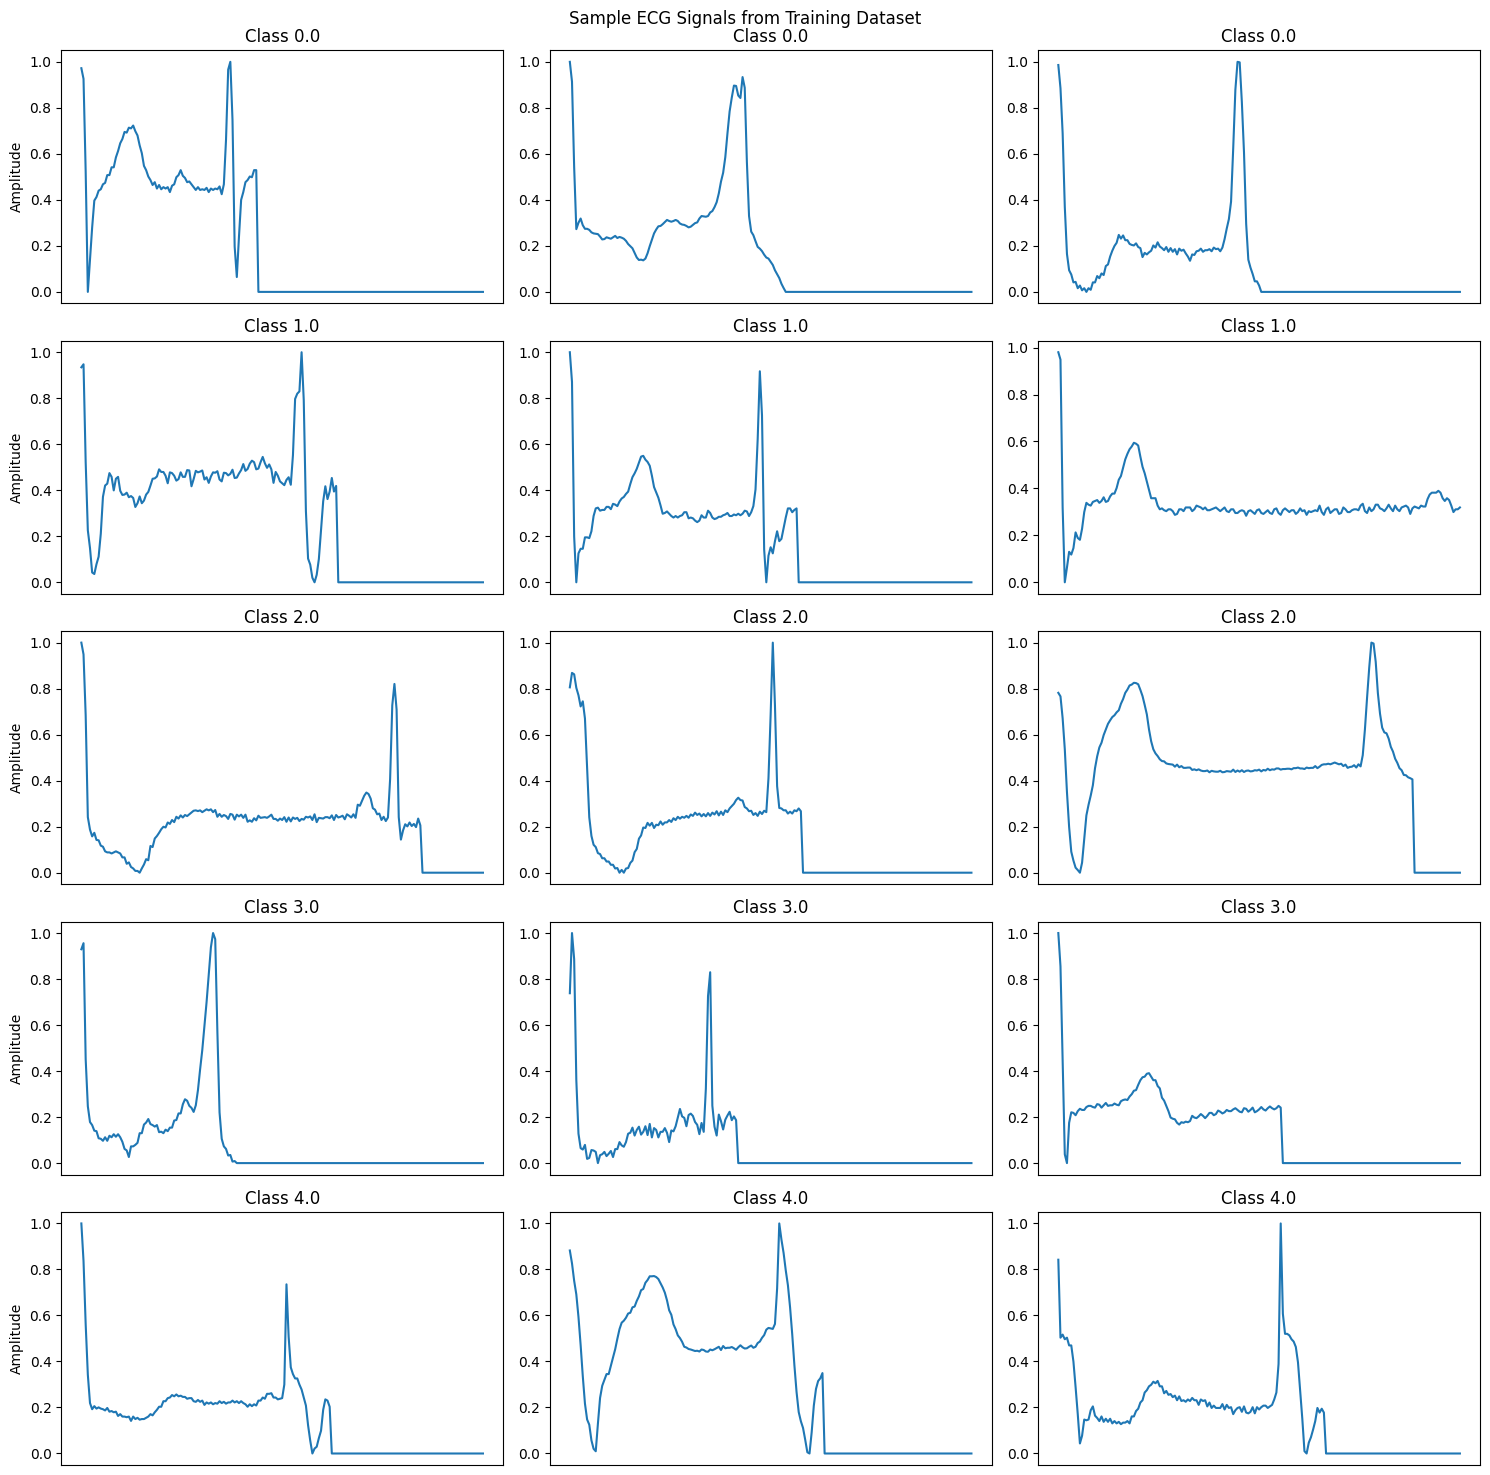


Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [12]:
 # Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Plot sample signals from each dataset
plot_sample_signals(X_train, y_train, "Training")

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# ECG Dataset on RNN Model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ECG_RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, num_heads=4, num_classes=5, dropout=0.3):
        """
        Hierarchical Attention-Gated RNN for ECG classification.

        Args:
            input_size (int): Number of input features per timestep
            hidden_size (int): Hidden state size of RNNs
            num_layers (int): Number of RNN layers
            num_heads (int): Number of attention heads
            num_classes (int): Number of output classes
            dropout (float): Dropout rate
        """
        super(ECG_RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_heads = num_heads

        # --- 1. Short-term RNN ---
        self.short_rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- 2. Long-term RNN ---
        self.long_rnn = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- 3. Gated Residual Fusion ---
        self.gate = nn.Sequential(
            nn.Linear(hidden_size * 4, hidden_size * 2),
            nn.Sigmoid()
        )

        # --- 4. Multi-Head Attention ---
        self.attn_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 1)
            )
            for _ in range(num_heads)
        ])

        # --- 5. Context Refinement RNN ---
        self.context_rnn = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # --- 6. Classification Head ---
        self.fc = nn.Sequential(
            nn.LayerNorm(hidden_size * 2),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        batch_size, seq_len, _ = x.size()

        # --- Short-term encoding ---
        short_out, _ = self.short_rnn(x)  # (b, t, 2H)

        # --- Long-term encoding ---
        long_out, _ = self.long_rnn(short_out)  # (b, t, 2H)

        # --- Gated fusion of short- and long-term features ---
        combined = torch.cat([short_out, long_out], dim=-1)
        gate = self.gate(combined)  # (b, t, 2H)
        fused = gate * short_out + (1 - gate) * long_out  # Adaptive residual fusion

        # --- Multi-head attention ---
        attn_outputs = []
        for head in self.attn_heads:
            weights = head(fused)                # (b, t, 1)
            weights = F.softmax(weights, dim=1)  # normalize
            context = torch.sum(weights * fused, dim=1)  # (b, 2H)
            attn_outputs.append(context)

        # Concatenate multiple attention heads
        multihead_context = torch.stack(attn_outputs, dim=1)  # (b, heads, 2H)

        # --- Context refinement RNN ---
        refined, _ = self.context_rnn(multihead_context)  # (b, heads, 2H)
        refined = torch.mean(refined, dim=1)              # global fusion

        # --- Classification ---
        out = self.fc(refined)
        return out

# New: SE block and Conv+BiGRU+Attention model
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        hidden = max(1, channels // reduction)
        self.fc = nn.Sequential(
            nn.Linear(channels, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # x: (B, C, T)
        w = x.mean(dim=-1)             # (B, C)
        w = self.fc(w)                 # (B, C)
        w = w.unsqueeze(-1)            # (B, C, 1)
        return x * w                   # scale

class ECG_ConvBiGRU_Attn(nn.Module):
    def __init__(self, input_size=1, num_classes=5, conv_channels=64, gru_hidden=128, num_gru_layers=2, dropout=0.3):
        super().__init__()
        C = conv_channels
        # 1D Conv frontend with multi-dilation to capture morphology
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, C, kernel_size=7, padding=3, dilation=1),
            nn.BatchNorm1d(C),
            nn.ReLU(inplace=True),
        )
        self.se1 = SEBlock(C)

        self.conv2 = nn.Sequential(
            nn.Conv1d(C, 2*C, kernel_size=5, padding=4, dilation=2),
            nn.BatchNorm1d(2*C),
            nn.ReLU(inplace=True),
        )
        self.se2 = SEBlock(2*C)

        # BiGRU backbone
        self.bigru = nn.GRU(
            input_size=2*C,
            hidden_size=gru_hidden,
            num_layers=num_gru_layers,
            batch_first=True,
            bidirectional=True,
        )

        # Attention pooling over time
        self.attn = nn.Sequential(
            nn.Linear(2*gru_hidden, gru_hidden),
            nn.Tanh(),
            nn.Linear(gru_hidden, 1)
        )

        # Classifier
        self.fc = nn.Sequential(
            nn.LayerNorm(2*gru_hidden),
            nn.Linear(2*gru_hidden, gru_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(gru_hidden, num_classes),
        )

    def forward(self, x):
        # x: (B, T, 1)
        x = x.transpose(1, 2)          # (B, 1, T)
        x = self.conv1(x)              # (B, C, T)
        x = self.se1(x)
        x = self.conv2(x)              # (B, 2C, T)
        x = self.se2(x)
        x = x.transpose(1, 2)          # (B, T, 2C)

        # BiGRU
        h, _ = self.bigru(x)           # (B, T, 2H)

        # Attention pooling
        w = self.attn(h)               # (B, T, 1)
        w = F.softmax(w, dim=1)        # (B, T, 1)
        ctx = (w * h).sum(dim=1)       # (B, 2H)

        # Classifier
        out = self.fc(ctx)             # (B, num_classes)
        return out

In [14]:
# Improved training configuration
def get_training_config():
    """
    Returns improved training configuration with:
    - Cyclical learning rates
    - Gradual warmup
    - Label smoothing
    - Mixed precision training
    """
    config = {
        'CNN': {
            'model_params': {
                'input_channels': 1,
                'sequence_length': 187,
                'num_classes': 5,
            },
            'training_params': {
                'initial_lr': 1e-4,  # Lower initial learning rate
                'max_lr': 3e-3,      # Maximum learning rate for cyclical schedule
                'batch_size': 64,    # Increased batch size
                'num_epochs': 100,   # More epochs for gradual learning
                'warmup_epochs': 5,  # Gradual warmup
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,  # Increased weight decay
                'gradient_clip_val': 0.5,
            }
        }
    }
    return config

In [15]:
# Quick sanity check for Conv+BiGRU+Attention model output shape
try:
    cfg = get_training_config()
    dummy_num_classes = cfg['ConvBiGRU']['model_params']['num_classes']
    m = ECG_ConvBiGRU_Attn(**cfg['ConvBiGRU']['model_params'])
    dummy_x = torch.randn(4, 187, 1)
    dummy_y = m(dummy_x)
    print('ConvBiGRU sanity:', dummy_y.shape)
except Exception as e:
    print('ConvBiGRU sanity test failed:', e)

ConvBiGRU sanity test failed: 'ConvBiGRU'


## Research-backed alternative RNN: Conv + BiGRU + Attention
#
# Motivation:
# - Local morphological features (QRS complexes, ST segments) benefit from 1D convolutions capturing short-term patterns at multiple receptive fields.
# - GRUs often match LSTMs with fewer parameters on physiological time-series (useful for efficiency and regularization on MIT-BIH).
# - Squeeze-and-Excitation (SE) channel attention (Hu et al., 2018) improves representational power by recalibrating feature maps.
# - Attention pooling highlights salient timesteps for classification (commonly adopted in ECG literature: attention BiRNNs for arrhythmia detection).
#
# Architecture:
#   Conv1D(1->C, k=7, dilations) + SE -> Conv1D(C->2C, k=5, dilations) + SE -> BiGRU(hidden=H, layers=L) -> Attn Pool -> FC.
#
# References (high-level):
# - Hu et al., "Squeeze-and-Excitation Networks", CVPR 2018.
# - Yildirim (2018)/and subsequent works: attention with BiRNNs for ECG arrhythmia classification.
# - Empirical results across time-series show CNN+RNN hybrids outperform single-stage models by combining local+long-range dependencies.

In [16]:
class CustomLRScheduler:
    def __init__(self, optimizer, initial_lr, max_lr, warmup_epochs, total_epochs):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.current_epoch = 0

    def step(self):
        self.current_epoch += 1
        if self.current_epoch <= self.warmup_epochs:
            # Linear warmup
            lr = self.initial_lr + (self.max_lr - self.initial_lr) * (self.current_epoch / self.warmup_epochs)
        else:
            # Cosine annealing
            progress = (self.current_epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.initial_lr + 0.5 * (self.max_lr - self.initial_lr) * (1 + np.cos(progress * np.pi))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

In [17]:
class SmoothCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1, weight=None):
        super(SmoothCrossEntropyLoss, self).__init__()
        self.smoothing = smoothing
        # weight: tensor/array of shape (C,) or None
        self.register_buffer('weight', None)
        if weight is not None:
            self.register_buffer('weight', torch.as_tensor(weight, dtype=torch.float))

    def forward(self, pred, target):
        """
        pred: (B, C), target: (B,) class indices
        Applies label smoothing and optional class weights (like nn.CrossEntropyLoss).
        """
        log_probs = F.log_softmax(pred, dim=1)
        n_classes = pred.size(1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.scatter_(1, target.unsqueeze(1), 1)
            true_dist = true_dist * (1 - self.smoothing) + self.smoothing / n_classes
        per_sample = -(true_dist * log_probs).sum(dim=1)  # (B,)
        if self.weight is not None:
            sample_w = self.weight[target]
            loss = (per_sample * sample_w).sum() / sample_w.sum()
        else:
            loss = per_sample.mean()
        return loss

In [18]:
def get_training_config():
    """
    Returns improved training configuration for RNN and ConvBiGRU models
    """
    config = {
        'RNN': {
            'model_params': {
                'input_size': 1,
                'hidden_size': 128,
                'num_layers': 2,
                'num_classes': 5,
                'dropout': 0.3,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 3e-3,
                'batch_size': 64,
                'num_epochs': 100,
                'warmup_epochs': 5,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 0.5,
                'early_stopping': {  # new
                    'patience': 10,
                    'min_delta': 1e-3,
                    'restore_best': True
                }
            },
        },
        'CNN': {
            'model_params': {
                'input_channels': 1,
                'sequence_length': 187,
                'num_classes': 5,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 3e-3,
                'batch_size': 64,
                'num_epochs': 100,
                'warmup_epochs': 5,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 0.5,
                'early_stopping': {  # new
                    'patience': 10,
                    'min_delta': 1e-3,
                    'restore_best': True
                }
            },
        },
        'ConvBiGRU': {  # new model
            'model_params': {
                'input_size': 1,
                'num_classes': 5,
                'conv_channels': 64,
                'gru_hidden': 128,
                'num_gru_layers': 2,
                'dropout': 0.3,
            },
            'training_params': {
                'initial_lr': 1e-4,
                'max_lr': 3e-3,
                'batch_size': 64,
                'num_epochs': 100,
                'warmup_epochs': 5,
                'label_smoothing': 0.1,
                'weight_decay': 1e-4,
                'gradient_clip_val': 0.5,
                'early_stopping': {
                    'patience': 10,
                    'min_delta': 1e-4,
                    'restore_best': True
                }
            }
        }
    }
    return config

In [19]:
# Initialize RNN model
rnn_model = ECG_RNN(
    input_size=1,
    hidden_size=128,
    num_layers=2,
    num_classes=5,
    dropout=0.3
)

# Get recommended training configurations
config = get_training_config()

In [20]:
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [21]:
class ModelTrainer:
    def __init__(self, model, model_name, device, criterion, config):
        from copy import deepcopy
        from torch.optim.swa_utils import AveragedModel
        self._deepcopy = deepcopy  # store reference for later use without re-import

        self.model = model.to(device)
        self.model_name = model_name
        self.device = device
        self.criterion = criterion
        self.config = config

        # Initialize optimizer with weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['initial_lr'],
            weight_decay=config['weight_decay']
        )

        # Scheduler config (created in train when train_loader is known)
        self.scheduler = None
        self.scheduler_type = config.get('scheduler', 'custom')

        # Initialize tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_val_loss = float('inf')

        # Early stopping setup
        es_cfg = config.get('early_stopping', {})
        self.es_patience = int(es_cfg.get('patience', 10))
        self.es_min_delta = float(es_cfg.get('min_delta', 0.0))
        self.es_restore_best = bool(es_cfg.get('restore_best', True))
        self.es_no_improve = 0
        self.best_state_dict = None

        # Fine-tuning additions
        self.grad_accum_steps = int(config.get('grad_accum_steps', 1))
        self.mixed_precision = bool(config.get('mixed_precision', False)) and torch.cuda.is_available()
        self.mixup_alpha = float(config.get('mixup_alpha', 0.0))
        self.use_swa = bool(config.get('use_swa', False))
        self.swa_start_fraction = float(config.get('swa_start', 0.8))
        self.swa_eval = bool(config.get('swa_eval', True))
        self.swa_model = None  # AveragedModel when enabled

        # AMP scaler
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.mixed_precision)

        # Create directory for saving models
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.save_dir = os.path.join('models', f"{model_name}_{timestamp}")
        os.makedirs(self.save_dir, exist_ok=True)

    def _build_scheduler(self, train_loader_len):
        if self.scheduler_type == 'onecycle':
            total_steps = train_loader_len * int(self.config['num_epochs'])
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
                self.optimizer,
                max_lr=self.config['max_lr'],
                total_steps=total_steps,
                pct_start=max(1, int(self.config['warmup_epochs'])) / max(1, int(self.config['num_epochs'])),
                div_factor=max(1.0, self.config['max_lr'] / max(1e-8, self.config['initial_lr'])),
                final_div_factor=100.0
            )
        else:
            self.scheduler = CustomLRScheduler(
                self.optimizer,
                self.config['initial_lr'],
                self.config['max_lr'],
                self.config['warmup_epochs'],
                self.config['num_epochs']
            )

    def _mixup(self, x, y):
        if self.mixup_alpha <= 0:
            return x, y, None, None, 1.0
        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
        index = torch.randperm(x.size(0), device=x.device)
        mixed_x = lam * x + (1 - lam) * x[index]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, index, lam

    def train_epoch(self, train_loader, epoch, total_epochs):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        steps = 0

        for step, (batch_X, batch_y) in enumerate(tqdm(train_loader, desc='Training')):
            batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

            # Mixup (if enabled)
            inputs, targets_a, targets_b, index, lam = self._mixup(batch_X, batch_y)

            with torch.cuda.amp.autocast(enabled=self.mixed_precision):
                result = self.model(inputs)
                outputs = result[0] if isinstance(result, (tuple, list)) else result
                if targets_b is None:
                    loss = self.criterion(outputs, batch_y)
                else:
                    loss = lam * self.criterion(outputs, targets_a) + (1 - lam) * self.criterion(outputs, targets_b)

            # Gradient scaling/accumulation
            self.scaler.scale(loss / self.grad_accum_steps).backward()

            if (step + 1) % self.grad_accum_steps == 0:
                # Gradient clipping
                if self.config.get('gradient_clip_val', None) is not None:
                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=self.config['gradient_clip_val'])
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)
                # Scheduler per-step for OneCycle
                if isinstance(self.scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    try:
                        self.scheduler.step()
                    except Exception:
                        pass

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            steps += 1

        epoch_loss = total_loss / max(1, steps)
        epoch_acc = 100 * correct / max(1, total)
        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        steps = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                # Handle different model outputs robustly (model may return logits or (logits, extra))
                result = self.model(batch_X)
                outputs = result[0] if isinstance(result, (tuple, list)) else result

                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
                steps += 1

        epoch_loss = total_loss / max(1, steps)
        epoch_acc = 100 * correct / max(1, total)
        return epoch_loss, epoch_acc

    def train(self, train_loader, val_loader, num_epochs, epoch_callback=None):
        """Complete training process with early stopping + HPO callback support"""
        print(f"\nStarting training for {self.model_name}...")
        if self.scheduler is None:
            self._build_scheduler(len(train_loader))

        swa_begin_epoch = int(np.floor(self.swa_start_fraction * num_epochs)) if self.use_swa else None

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = self.train_epoch(train_loader, epoch, num_epochs)

            # Validation phase
            val_loss, val_acc = self.validate(val_loader)

            # Update learning rate
            if isinstance(self.scheduler, CustomLRScheduler):
                current_lr = self.scheduler.step()
            else:
                current_lr = self.optimizer.param_groups[0]['lr']

            # Save metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Print epoch results
            print(f'\nEpoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {current_lr:.6f}')

            # Optional epoch callback (for Optuna pruning)
            if epoch_callback is not None:
                epoch_callback(epoch, train_loss, val_loss, train_acc, val_acc, current_lr)

            # Early stopping check with best model saving
            if val_loss < self.best_val_loss - self.es_min_delta:
                self.best_val_loss = val_loss
                self.es_no_improve = 0
                self.best_state_dict = self._deepcopy(self.model.state_dict())
                self.save_model('best_model.pth')
                print(f'New best model saved! (Val Loss: {val_loss:.4f})')
            else:
                self.es_no_improve += 1
                print(f'No improvement: {self.es_no_improve}/{self.es_patience}')

            # SWA update
            if self.use_swa and epoch + 1 >= (swa_begin_epoch or num_epochs+1):
                if self.swa_model is None:
                    from torch.optim.swa_utils import AveragedModel
                    self.swa_model = AveragedModel(self.model)
                    print('Initialized SWA model averaging.')
                else:
                    self.swa_model.update_parameters(self.model)

            if self.es_no_improve >= self.es_patience:
                print(f'Early stopping triggered at epoch {epoch+1}. Best val loss: {self.best_val_loss:.4f}')
                if self.es_restore_best and self.best_state_dict is not None:
                    self.model.load_state_dict(self.best_state_dict)
                    print('Restored best model weights.')
                break

        # Finalize SWA (compute BN updates if available) and swap for eval/save
        if self.swa_model is not None and self.swa_eval:
            try:
                from torch.optim.swa_utils import update_bn
                update_bn(train_loader, self.swa_model, device=self.device)
                self.model = self.swa_model
                print('SWA model swapped in for evaluation and saving.')
            except Exception as e:
                print('SWA BN update failed or not applicable:', e)

        # Save final model
        self.save_model(f'{self.model_name.lower()}_final_model.pth')

    def save_model(self, filename):
        """Save model checkpoint"""
        path = os.path.join(self.save_dir, filename)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'config': self.config
        }, path)

    def plot_training_history(self):
        """Plot training metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot losses
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title(f'{self.model_name} - Training History (Loss)')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Training Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title(f'{self.model_name} - Training History (Accuracy)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'training_history.png'))
        plt.show()

    def evaluate(self, test_loader):
        """Evaluate model on test set"""
        self.model.eval()
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                # Handle different model outputs robustly (model may return logits or (logits, extra))
                result = self.model(batch_X)
                outputs = result[0] if isinstance(result, (tuple, list)) else result

                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(batch_y.cpu().numpy())

        # Print classification report
        print(f"\nClassification Report ({self.model_name}):")
        print(classification_report(true_labels, predictions))

        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix ({self.model_name})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(os.path.join(self.save_dir, 'confusion_matrix.png'))
        plt.show()


In [22]:
def train_rnn_model(X_train, X_val, X_test, y_train, y_val, y_test, config_override=None):
    """Train RNN model with fine-tuning features"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    base = get_training_config()
    if config_override is not None:
        cfg = {'RNN': config_override}
    else:
        cfg = base
    tr_cfg = cfg['RNN']['training_params']

    # Build train transform
    train_transform = build_train_transform(tr_cfg) if 'build_train_transform' in globals() else None

    # Create data loaders
    train_dataset = ECGDataset(X_train, y_train, transform=train_transform) if 'transform' in ECGDataset.__init__.__code__.co_varnames else ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    batch_size = tr_cfg['batch_size']
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Class weights
    class_weights = None
    if tr_cfg.get('class_weighting', None) == 'inv_freq' and 'compute_class_weights' in globals():
        class_weights = compute_class_weights(y_train)
        print('Using class weights:', class_weights)

    # Initialize model
    rnn_model = ECG_RNN(**cfg['RNN']['model_params'])

    # Criterion with label smoothing and optional class weights
    rnn_criterion = SmoothCrossEntropyLoss(smoothing=tr_cfg['label_smoothing'], weight=class_weights)

    # Train
    rnn_trainer = ModelTrainer(
        model=rnn_model,
        model_name='RNN',
        device=device,
        criterion=rnn_criterion,
        config=tr_cfg
    )
    rnn_trainer.train(train_loader, val_loader, tr_cfg['num_epochs'])
    rnn_trainer.plot_training_history()
    rnn_trainer.evaluate(test_loader)

    return rnn_trainer

In [23]:
def train_conv_bigru_model(X_train, X_val, X_test, y_train, y_val, y_test, config_override=None):
    """Train Conv+BiGRU+Attention model with fine-tuning features"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    base = get_training_config()
    if config_override is not None:
        cfg = {'ConvBiGRU': config_override}
    else:
        cfg = base
    tr_cfg = cfg['ConvBiGRU']['training_params']

    # Build train transform
    train_transform = build_train_transform(tr_cfg) if 'build_train_transform' in globals() else None

    # Create data loaders
    train_dataset = ECGDataset(X_train, y_train, transform=train_transform) if 'transform' in ECGDataset.__init__.__code__.co_varnames else ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    batch_size = tr_cfg['batch_size']
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Class weights
    class_weights = None
    if tr_cfg.get('class_weighting', None) == 'inv_freq' and 'compute_class_weights' in globals():
        class_weights = compute_class_weights(y_train)
        print('Using class weights:', class_weights)

    # Initialize model
    conv_bigru_model = ECG_ConvBiGRU_Attn(**cfg['ConvBiGRU']['model_params'])

    # Criterion
    criterion = SmoothCrossEntropyLoss(smoothing=tr_cfg['label_smoothing'], weight=class_weights)

    # Train
    trainer = ModelTrainer(
        model=conv_bigru_model,
        model_name='ConvBiGRU',
        device=device,
        criterion=criterion,
        config=tr_cfg
    )
    trainer.train(train_loader, val_loader, tr_cfg['num_epochs'])
    trainer.plot_training_history()
    trainer.evaluate(test_loader)

    return trainer


Updated configuration:
Number of classes: 5
Sequence length: 187
Using device: cuda


C:\Users\leona\AppData\Local\Temp\ipykernel_15532\3116528764.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.mixed_precision)



Starting training for RNN...


Training:   0%|          | 0/1232 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_15532\3116528764.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.mixed_precision):
Training:   0%|          | 1/1232 [00:00<04:19,  4.74it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_15532\3116528764.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.mixed_precision):
Training: 100%|██████████| 1232/1232 [00:10<00:00, 122.88it/s]




Epoch [1/100]
Train Loss: 0.7626, Train Acc: 85.09%
Val   Loss: 0.5963, Val   Acc: 92.14%
Learning Rate: 0.000680
New best model saved! (Val Loss: 0.5963)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.60it/s]




Epoch [2/100]
Train Loss: 0.6001, Train Acc: 92.10%
Val   Loss: 0.5353, Val   Acc: 94.46%
Learning Rate: 0.001260
New best model saved! (Val Loss: 0.5353)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.59it/s]




Epoch [3/100]
Train Loss: 0.5511, Train Acc: 94.14%
Val   Loss: 0.5234, Val   Acc: 94.38%
Learning Rate: 0.001840
New best model saved! (Val Loss: 0.5234)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.92it/s]




Epoch [4/100]
Train Loss: 0.5096, Train Acc: 95.40%
Val   Loss: 0.4711, Val   Acc: 96.51%
Learning Rate: 0.002420
New best model saved! (Val Loss: 0.4711)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.15it/s]




Epoch [5/100]
Train Loss: 0.4836, Train Acc: 96.40%
Val   Loss: 0.4629, Val   Acc: 97.00%
Learning Rate: 0.003000
New best model saved! (Val Loss: 0.4629)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.36it/s]




Epoch [6/100]
Train Loss: 0.4750, Train Acc: 96.74%
Val   Loss: 0.4588, Val   Acc: 97.25%
Learning Rate: 0.002999
New best model saved! (Val Loss: 0.4588)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.60it/s]




Epoch [7/100]
Train Loss: 0.4834, Train Acc: 96.39%
Val   Loss: 0.4528, Val   Acc: 97.51%
Learning Rate: 0.002997
New best model saved! (Val Loss: 0.4528)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.38it/s]




Epoch [8/100]
Train Loss: 0.4534, Train Acc: 97.57%
Val   Loss: 0.4419, Val   Acc: 97.84%
Learning Rate: 0.002993
New best model saved! (Val Loss: 0.4419)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.80it/s]




Epoch [9/100]
Train Loss: 0.4469, Train Acc: 97.84%
Val   Loss: 0.4375, Val   Acc: 98.04%
Learning Rate: 0.002987
New best model saved! (Val Loss: 0.4375)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.94it/s]




Epoch [10/100]
Train Loss: 0.4420, Train Acc: 98.03%
Val   Loss: 0.4454, Val   Acc: 97.74%
Learning Rate: 0.002980
No improvement: 1/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.44it/s]




Epoch [11/100]
Train Loss: 0.4382, Train Acc: 98.15%
Val   Loss: 0.4388, Val   Acc: 97.97%
Learning Rate: 0.002972
No improvement: 2/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.35it/s]




Epoch [12/100]
Train Loss: 0.4347, Train Acc: 98.29%
Val   Loss: 0.4320, Val   Acc: 98.10%
Learning Rate: 0.002961
New best model saved! (Val Loss: 0.4320)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.83it/s]




Epoch [13/100]
Train Loss: 0.4318, Train Acc: 98.40%
Val   Loss: 0.4322, Val   Acc: 98.09%
Learning Rate: 0.002950
No improvement: 1/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.06it/s]




Epoch [14/100]
Train Loss: 0.4293, Train Acc: 98.53%
Val   Loss: 0.4340, Val   Acc: 98.22%
Learning Rate: 0.002936
No improvement: 2/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.16it/s]




Epoch [15/100]
Train Loss: 0.4281, Train Acc: 98.54%
Val   Loss: 0.4300, Val   Acc: 98.32%
Learning Rate: 0.002921
New best model saved! (Val Loss: 0.4300)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 124.40it/s]



Epoch [16/100]
Train Loss: 0.4242, Train Acc: 98.68%
Val   Loss: 0.4314, Val   Acc: 98.31%
Learning Rate: 0.002905
No improvement: 1/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.20it/s]




Epoch [17/100]
Train Loss: 0.4271, Train Acc: 98.50%
Val   Loss: 0.4315, Val   Acc: 98.25%
Learning Rate: 0.002887
No improvement: 2/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.55it/s]




Epoch [18/100]
Train Loss: 0.4216, Train Acc: 98.76%
Val   Loss: 0.4237, Val   Acc: 98.65%
Learning Rate: 0.002868
New best model saved! (Val Loss: 0.4237)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 124.53it/s]




Epoch [19/100]
Train Loss: 0.4197, Train Acc: 98.83%
Val   Loss: 0.4231, Val   Acc: 98.56%
Learning Rate: 0.002847
No improvement: 1/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 124.27it/s]




Epoch [20/100]
Train Loss: 0.4170, Train Acc: 98.94%
Val   Loss: 0.4231, Val   Acc: 98.53%
Learning Rate: 0.002825
No improvement: 2/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 124.65it/s]




Epoch [21/100]
Train Loss: 0.4150, Train Acc: 99.04%
Val   Loss: 0.4242, Val   Acc: 98.54%
Learning Rate: 0.002802
No improvement: 3/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 124.62it/s]




Epoch [22/100]
Train Loss: 0.4153, Train Acc: 99.00%
Val   Loss: 0.4216, Val   Acc: 98.65%
Learning Rate: 0.002777
New best model saved! (Val Loss: 0.4216)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.09it/s]




Epoch [23/100]
Train Loss: 0.4123, Train Acc: 99.15%
Val   Loss: 0.4218, Val   Acc: 98.69%
Learning Rate: 0.002751
No improvement: 1/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.63it/s]




Epoch [24/100]
Train Loss: 0.4126, Train Acc: 99.13%
Val   Loss: 0.4236, Val   Acc: 98.55%
Learning Rate: 0.002723
No improvement: 2/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.71it/s]




Epoch [25/100]
Train Loss: 0.4103, Train Acc: 99.22%
Val   Loss: 0.4228, Val   Acc: 98.58%
Learning Rate: 0.002694
No improvement: 3/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.39it/s]




Epoch [26/100]
Train Loss: 0.4088, Train Acc: 99.30%
Val   Loss: 0.4222, Val   Acc: 98.71%
Learning Rate: 0.002664
No improvement: 4/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.33it/s]




Epoch [27/100]
Train Loss: 0.4085, Train Acc: 99.31%
Val   Loss: 0.4219, Val   Acc: 98.60%
Learning Rate: 0.002633
No improvement: 5/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.03it/s]



Epoch [28/100]
Train Loss: 0.4087, Train Acc: 99.29%
Val   Loss: 0.4191, Val   Acc: 98.80%
Learning Rate: 0.002600
New best model saved! (Val Loss: 0.4191)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.08it/s]




Epoch [29/100]
Train Loss: 0.4066, Train Acc: 99.38%
Val   Loss: 0.4241, Val   Acc: 98.66%
Learning Rate: 0.002567
No improvement: 1/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.14it/s]




Epoch [30/100]
Train Loss: 0.4075, Train Acc: 99.34%
Val   Loss: 0.4258, Val   Acc: 98.55%
Learning Rate: 0.002532
No improvement: 2/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.99it/s]




Epoch [31/100]
Train Loss: 0.4071, Train Acc: 99.36%
Val   Loss: 0.4258, Val   Acc: 98.62%
Learning Rate: 0.002496
No improvement: 3/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.56it/s]




Epoch [32/100]
Train Loss: 0.4049, Train Acc: 99.46%
Val   Loss: 0.4184, Val   Acc: 98.78%
Learning Rate: 0.002459
No improvement: 4/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.95it/s]




Epoch [33/100]
Train Loss: 0.4051, Train Acc: 99.44%
Val   Loss: 0.4230, Val   Acc: 98.65%
Learning Rate: 0.002422
No improvement: 5/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.39it/s]




Epoch [34/100]
Train Loss: 0.4040, Train Acc: 99.48%
Val   Loss: 0.4238, Val   Acc: 98.61%
Learning Rate: 0.002383
No improvement: 6/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.72it/s]




Epoch [35/100]
Train Loss: 0.4029, Train Acc: 99.56%
Val   Loss: 0.4223, Val   Acc: 98.76%
Learning Rate: 0.002343
No improvement: 7/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.11it/s]




Epoch [36/100]
Train Loss: 0.4027, Train Acc: 99.55%
Val   Loss: 0.4221, Val   Acc: 98.73%
Learning Rate: 0.002303
No improvement: 8/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.00it/s]




Epoch [37/100]
Train Loss: 0.4020, Train Acc: 99.59%
Val   Loss: 0.4260, Val   Acc: 98.52%
Learning Rate: 0.002261
No improvement: 9/10


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.70it/s]




Epoch [38/100]
Train Loss: 0.4019, Train Acc: 99.58%
Val   Loss: 0.4243, Val   Acc: 98.64%
Learning Rate: 0.002219
No improvement: 10/10
Early stopping triggered at epoch 38. Best val loss: 0.4191
Restored best model weights.


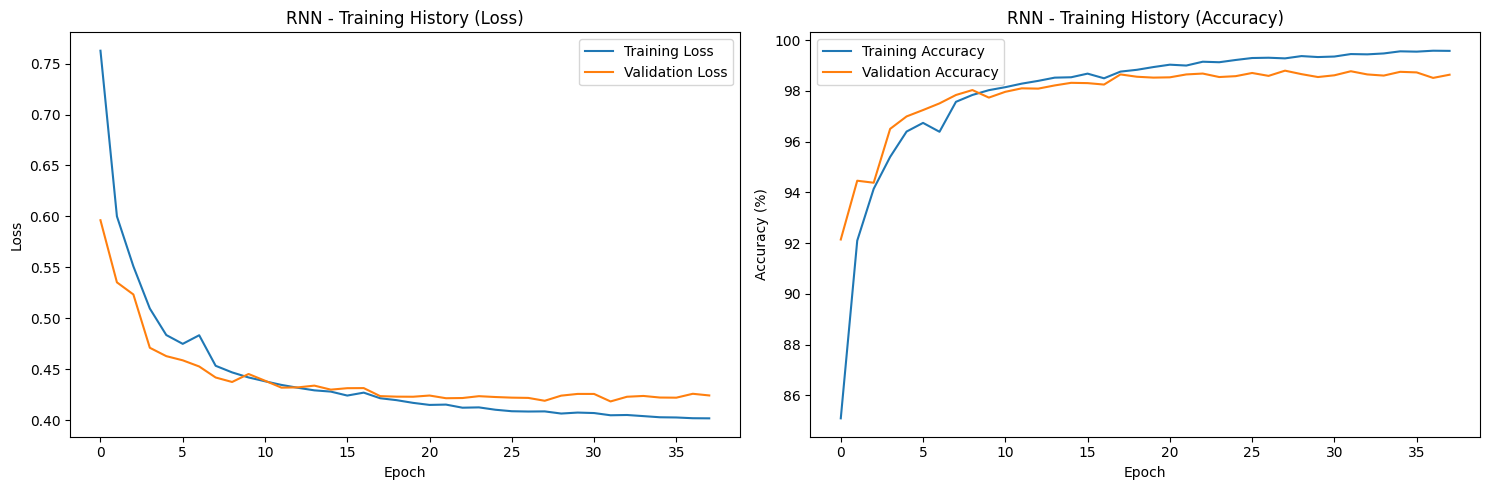

Testing: 100%|██████████| 343/343 [00:01<00:00, 316.63it/s]




Classification Report (RNN):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.96      0.75      0.84       556
           2       0.97      0.96      0.96      1448
           3       0.86      0.80      0.83       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.95      0.90      0.92     21892
weighted avg       0.99      0.99      0.99     21892



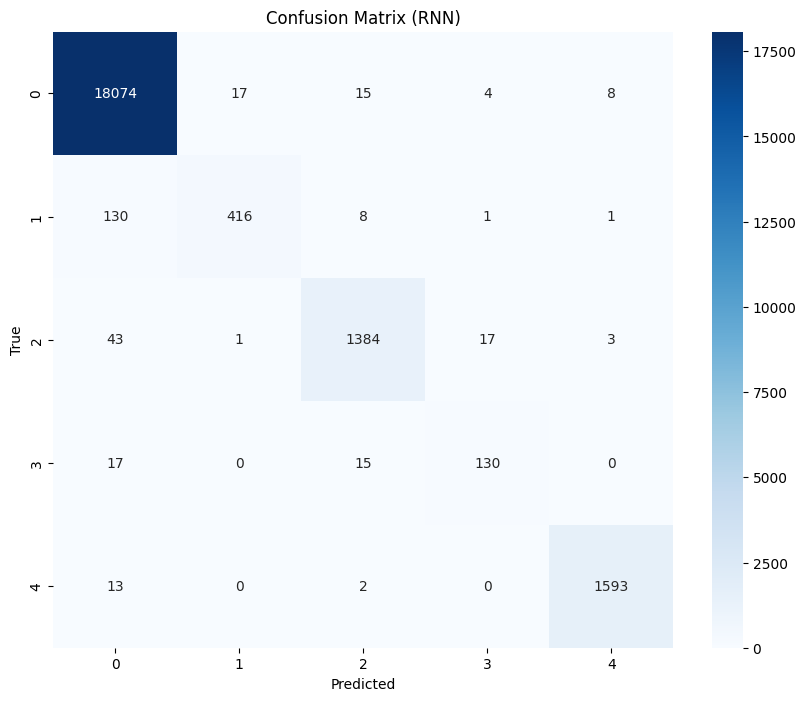

C:\Users\leona\AppData\Local\Temp\ipykernel_15532\3116528764.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.mixed_precision)


Using device: cuda

Starting training for ConvBiGRU...


Training:   0%|          | 0/1232 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_15532\3116528764.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.mixed_precision):
C:\Users\leona\AppData\Local\Temp\ipykernel_15532\3116528764.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.mixed_precision):
Training: 100%|██████████| 1232/1232 [00:06<00:00, 186.81it/s]




Epoch [1/100]
Train Loss: 0.5640, Train Acc: 93.16%
Val   Loss: 0.4882, Val   Acc: 96.00%
Learning Rate: 0.000680
New best model saved! (Val Loss: 0.4882)


Training: 100%|██████████| 1232/1232 [00:06<00:00, 188.44it/s]



Epoch [2/100]
Train Loss: 0.5082, Train Acc: 95.68%
Val   Loss: 0.4759, Val   Acc: 96.59%
Learning Rate: 0.001260
New best model saved! (Val Loss: 0.4759)


Training: 100%|██████████| 1232/1232 [00:06<00:00, 188.47it/s]



Epoch [3/100]
Train Loss: 0.4814, Train Acc: 96.70%
Val   Loss: 0.4542, Val   Acc: 97.45%
Learning Rate: 0.001840
New best model saved! (Val Loss: 0.4542)


Training: 100%|██████████| 1232/1232 [00:06<00:00, 187.97it/s]




Epoch [4/100]
Train Loss: 0.4689, Train Acc: 97.20%
Val   Loss: 0.4522, Val   Acc: 97.65%
Learning Rate: 0.002420
New best model saved! (Val Loss: 0.4522)


Training: 100%|██████████| 1232/1232 [00:06<00:00, 188.35it/s]



Epoch [5/100]
Train Loss: 0.4624, Train Acc: 97.36%
Val   Loss: 0.4460, Val   Acc: 97.72%
Learning Rate: 0.003000
New best model saved! (Val Loss: 0.4460)


Training: 100%|██████████| 1232/1232 [00:06<00:00, 188.40it/s]




Epoch [6/100]
Train Loss: 0.4573, Train Acc: 97.61%
Val   Loss: 0.4446, Val   Acc: 97.83%
Learning Rate: 0.002999
New best model saved! (Val Loss: 0.4446)


Training: 100%|██████████| 1232/1232 [00:06<00:00, 190.37it/s]




Epoch [7/100]
Train Loss: 0.4493, Train Acc: 97.80%
Val   Loss: 0.4472, Val   Acc: 97.54%
Learning Rate: 0.002997
No improvement: 1/10


Training: 100%|██████████| 1232/1232 [00:06<00:00, 188.53it/s]




Epoch [8/100]
Train Loss: 0.4455, Train Acc: 97.94%
Val   Loss: 0.4412, Val   Acc: 97.93%
Learning Rate: 0.002993
New best model saved! (Val Loss: 0.4412)


Training: 100%|██████████| 1232/1232 [00:06<00:00, 186.73it/s]




Epoch [9/100]
Train Loss: 0.4429, Train Acc: 98.03%
Val   Loss: 0.4615, Val   Acc: 96.95%
Learning Rate: 0.002987
No improvement: 1/10


Training: 100%|██████████| 1232/1232 [00:06<00:00, 188.42it/s]




Epoch [10/100]
Train Loss: 0.4422, Train Acc: 98.00%
Val   Loss: 0.4377, Val   Acc: 97.94%
Learning Rate: 0.002980
New best model saved! (Val Loss: 0.4377)


Training: 100%|██████████| 1232/1232 [00:06<00:00, 188.07it/s]




Epoch [11/100]
Train Loss: 0.4422, Train Acc: 98.02%
Val   Loss: 0.4373, Val   Acc: 98.09%
Learning Rate: 0.002972
New best model saved! (Val Loss: 0.4373)


Training: 100%|██████████| 1232/1232 [00:06<00:00, 190.03it/s]




Epoch [12/100]
Train Loss: 0.4416, Train Acc: 98.05%
Val   Loss: 0.4433, Val   Acc: 97.94%
Learning Rate: 0.002961
No improvement: 1/10


Training: 100%|██████████| 1232/1232 [00:06<00:00, 187.56it/s]




Epoch [13/100]
Train Loss: 0.4410, Train Acc: 98.05%
Val   Loss: 0.4441, Val   Acc: 97.78%
Learning Rate: 0.002950
No improvement: 2/10


Training: 100%|██████████| 1232/1232 [00:06<00:00, 189.48it/s]




Epoch [14/100]
Train Loss: 0.4440, Train Acc: 97.97%
Val   Loss: 0.4388, Val   Acc: 98.10%
Learning Rate: 0.002936
No improvement: 3/10


Training: 100%|██████████| 1232/1232 [00:06<00:00, 187.76it/s]




Epoch [15/100]
Train Loss: 0.4425, Train Acc: 98.03%
Val   Loss: 0.4485, Val   Acc: 97.65%
Learning Rate: 0.002921
No improvement: 4/10


Training: 100%|██████████| 1232/1232 [00:06<00:00, 188.85it/s]




Epoch [16/100]
Train Loss: 0.4438, Train Acc: 97.98%
Val   Loss: 0.4452, Val   Acc: 97.84%
Learning Rate: 0.002905
No improvement: 5/10


Training: 100%|██████████| 1232/1232 [00:06<00:00, 188.28it/s]




Epoch [17/100]
Train Loss: 0.4461, Train Acc: 97.87%
Val   Loss: 0.4545, Val   Acc: 97.45%
Learning Rate: 0.002887
No improvement: 6/10


Training: 100%|██████████| 1232/1232 [00:06<00:00, 186.65it/s]




Epoch [18/100]
Train Loss: 0.4494, Train Acc: 97.70%
Val   Loss: 0.4467, Val   Acc: 97.78%
Learning Rate: 0.002868
No improvement: 7/10


Training: 100%|██████████| 1232/1232 [00:06<00:00, 186.80it/s]




Epoch [19/100]
Train Loss: 0.4512, Train Acc: 97.62%
Val   Loss: 0.4559, Val   Acc: 97.35%
Learning Rate: 0.002847
No improvement: 8/10


Training: 100%|██████████| 1232/1232 [00:06<00:00, 180.94it/s]




Epoch [20/100]
Train Loss: 0.4490, Train Acc: 97.72%
Val   Loss: 0.4452, Val   Acc: 97.72%
Learning Rate: 0.002825
No improvement: 9/10


Training: 100%|██████████| 1232/1232 [00:06<00:00, 179.70it/s]




Epoch [21/100]
Train Loss: 0.4515, Train Acc: 97.62%
Val   Loss: 0.4462, Val   Acc: 97.73%
Learning Rate: 0.002802
No improvement: 10/10
Early stopping triggered at epoch 21. Best val loss: 0.4373
Restored best model weights.


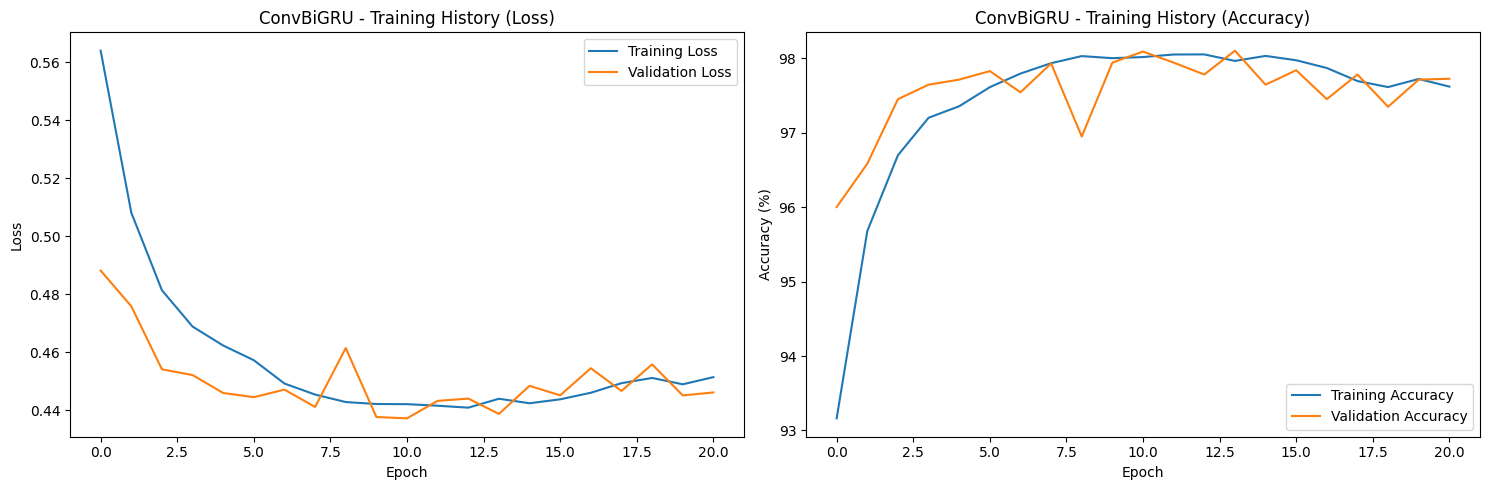

Testing: 100%|██████████| 343/343 [00:00<00:00, 490.98it/s]



Classification Report (ConvBiGRU):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18118
           1       0.96      0.62      0.75       556
           2       0.95      0.94      0.94      1448
           3       0.78      0.76      0.77       162
           4       0.99      0.98      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.93      0.86      0.89     21892
weighted avg       0.98      0.98      0.98     21892



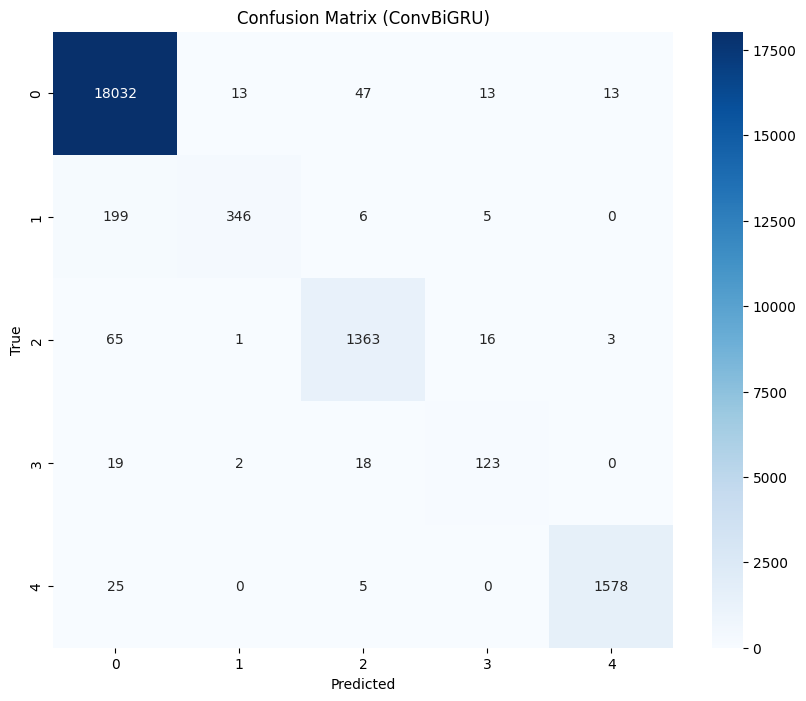

In [24]:
# Update configuration based on actual data
config = get_training_config()
num_classes = len(np.unique(y_train))
sequence_length = X_train.shape[1]

# Update model configurations with dataset-derived values
config['RNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['num_classes'] = num_classes
config['CNN']['model_params']['sequence_length'] = sequence_length
config['ConvBiGRU']['model_params']['num_classes'] = num_classes

print("\nUpdated configuration:")
print(f"Number of classes: {num_classes}")
print(f"Sequence length: {sequence_length}")

# Train models
rnn_trainer = train_rnn_model(X_train, X_val, X_test, y_train, y_val, y_test)
convbigru_trainer = train_conv_bigru_model(X_train, X_val, X_test, y_train, y_val, y_test)

In [25]:
def get_test_accuracy(model, test_loader, device, model_name=''):
    model.eval()
    correct = 0
    total = 0
    
    print(f"\nEvaluating {model_name} model...")
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Handle different model outputs robustly (model may return logits or (logits, extra))
            result = model(batch_X)
            outputs = result[0] if isinstance(result, (tuple, list)) else result
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    print(f"{model_name} Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [26]:
# Create test loader
test_dataset = ECGDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get accuracies
rnn_accuracy = get_test_accuracy(rnn_trainer.model, test_loader, device, "RNN")
convbigru_accuracy = get_test_accuracy(convbigru_trainer.model, test_loader, device, "ConvBiGRU")

print("\nSummary:")
print(f"RNN Test Accuracy: {rnn_accuracy:.2f}%")
print(f"ConvBiGRU Test Accuracy: {convbigru_accuracy:.2f}%")


Evaluating RNN model...
RNN Test Accuracy: 98.65%

Evaluating ConvBiGRU model...
RNN Test Accuracy: 98.65%

Evaluating ConvBiGRU model...
ConvBiGRU Test Accuracy: 97.94%

Summary:
RNN Test Accuracy: 98.65%
ConvBiGRU Test Accuracy: 97.94%
ConvBiGRU Test Accuracy: 97.94%

Summary:
RNN Test Accuracy: 98.65%
ConvBiGRU Test Accuracy: 97.94%


In [27]:
#save RNN and ConvBiGRU models
# torch.save(rnn_trainer.model.state_dict(), 'rnn_final_model.pth')

torch.save({
            'model_state_dict': rnn_trainer.model.state_dict(),
            'optimizer_state_dict': rnn_trainer.optimizer.state_dict(),
            'train_losses': rnn_trainer.train_losses,
            'val_losses': rnn_trainer.val_losses,
            'train_accuracies': rnn_trainer.train_accuracies,
            'val_accuracies': rnn_trainer.val_accuracies,
            'config': rnn_trainer.config
        }, 'rnn_final_model.pth')

# Save ConvBiGRU model
torch.save({
            'model_state_dict': convbigru_trainer.model.state_dict(),
            'optimizer_state_dict': convbigru_trainer.optimizer.state_dict(),
            'train_losses': convbigru_trainer.train_losses,
            'val_losses': convbigru_trainer.val_losses,
            'train_accuracies': convbigru_trainer.train_accuracies,
            'val_accuracies': convbigru_trainer.val_accuracies,
            'config': convbigru_trainer.config
        }, 'conv_bigru_final_model.pth')

In [28]:
# Install Optuna if needed
import importlib, sys
if importlib.util.find_spec('optuna') is None:
    !pip install optuna -q
import optuna

c:\Users\leona\miniconda3\envs\sc4001\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
# Optuna objective functions for HPO
import math
from copy import deepcopy
import numpy as np
import torch
from torch.utils.data import DataLoader
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

def _trial_train_once(model_name, model_ctor, base_config, trial, X_train, X_val, X_test, y_train, y_val, y_test, tune_epochs=20):
    cfg = deepcopy(base_config)
    tp = cfg['training_params']

    # Search space (common)
    tp['scheduler'] = trial.suggest_categorical('scheduler', ['onecycle','custom'])
    tp['initial_lr'] = trial.suggest_float('initial_lr', 1e-5, 5e-3, log=True)
    tp['max_lr'] = trial.suggest_float('max_lr', tp['initial_lr']*2, 1e-2, log=True)
    tp['weight_decay'] = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    tp['label_smoothing'] = trial.suggest_float('label_smoothing', 0.0, 0.2)
    tp['batch_size'] = trial.suggest_categorical('batch_size', [32, 64])
    tp['grad_accum_steps'] = trial.suggest_categorical('grad_accum_steps', [1, 2])
    tp['mixed_precision'] = trial.suggest_categorical('mixed_precision', [True, False])
    tp['use_swa'] = trial.suggest_categorical('use_swa', [True, False])
    tp['swa_start'] = trial.suggest_float('swa_start', 0.7, 0.9)
    tp['mixup_alpha'] = trial.suggest_float('mixup_alpha', 0.0, 0.4)
    tp['early_stopping']['patience'] = trial.suggest_int('patience', 5, 15)

    # Augmentations
    aug = tp.get('augment', {})
    aug['jitter_sigma'] = trial.suggest_float('jitter_sigma', 0.0, 0.02)
    aug['scale_sigma'] = trial.suggest_float('scale_sigma', 0.0, 0.15)
    aug['time_mask'] = {
        'p': trial.suggest_float('time_mask_p', 0.0, 0.7),
        'max_width': trial.suggest_int('time_mask_width', 0, 30),
        'num_masks': trial.suggest_int('time_mask_num', 0, 3),
    }
    aug['shift'] = {
        'p': trial.suggest_float('shift_p', 0.0, 0.7),
        'max_shift': trial.suggest_int('shift_max', 0, 12),
    }
    tp['augment'] = aug

    # Model-specific space
    mp = cfg['model_params']
    if model_name == 'RNN':
        mp['hidden_size'] = trial.suggest_categorical('rnn_hidden', [64, 128, 192, 256])
        mp['num_layers'] = trial.suggest_int('rnn_layers', 1, 3)
        mp['dropout'] = trial.suggest_float('rnn_dropout', 0.1, 0.5)
    elif model_name == 'ConvBiGRU':
        mp['conv_channels'] = trial.suggest_categorical('conv_channels', [32, 64, 96])
        mp['gru_hidden'] = trial.suggest_categorical('gru_hidden', [96, 128, 160, 192])
        mp['num_gru_layers'] = trial.suggest_int('gru_layers', 1, 3)
        mp['dropout'] = trial.suggest_float('gru_dropout', 0.1, 0.5)

    # Shorten epochs for tuning only
    tp['num_epochs'] = tune_epochs

    # Build datasets/loaders
    try:
        train_transform = build_train_transform(tp) if 'build_train_transform' in globals() else None
    except Exception:
        train_transform = None
    train_dataset = ECGDataset(X_train, y_train, transform=train_transform) if 'ECGDataset' in globals() and 'transform' in ECGDataset.__init__.__code__.co_varnames else ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=tp['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=tp['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=tp['batch_size'])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Class weights (inverse frequency)
    class_weights = None
    if tp.get('class_weighting', 'inv_freq') == 'inv_freq':
        class_weights = compute_class_weights(y_train) if 'compute_class_weights' in globals() else None
    criterion = SmoothCrossEntropyLoss(smoothing=tp['label_smoothing'], weight=class_weights)

    # Init model + trainer
    model = model_ctor(**mp)
    trainer = ModelTrainer(model=model, model_name=model_name, device=device, criterion=criterion, config=tp)

    # Epoch callback to report intermediate scores and prune
    def _epoch_cb(epoch, tr_loss, va_loss, tr_acc, va_acc, lr):
        trial.report(va_loss, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    trainer.train(train_loader, val_loader, tp['num_epochs'], epoch_callback=_epoch_cb)
    # Return best validation loss observed
    best_val = min(trainer.val_losses) if len(trainer.val_losses) else math.inf
    return best_val

def make_objective(model_name):
    config = get_training_config()[model_name]
    # Choose constructor
    if model_name == 'RNN':
        ctor = ECG_RNN
    elif model_name == 'ConvBiGRU':
        ctor = ECG_ConvBiGRU_Attn
    else:
        raise ValueError('Unknown model name for HPO')
    def _objective(trial):
        return _trial_train_once(model_name, ctor, config, trial, X_train, X_val, X_test, y_train, y_val, y_test, tune_epochs=20)
    return _objective

## Hyperparameter optimization (HPO) with Optuna
- Uses TPE sampler (Bayesian optimization) and MedianPruner for efficient early stopping of bad trials.
- Reports validation loss each epoch through a callback—no dataset changes, only training loop tweaks.
- Search covers scheduler, learning rates, weight decay, label smoothing, batch size, AMP, SWA, MixUp, and augmentation strengths.
- Model-specific spaces include RNN hidden size/layers/dropout or ConvBiGRU conv/gru sizes and dropout.
- To tune the RNN instead of ConvBiGRU, set `model_name = 'RNN'` in the HPO cell and re-run the three HPO cells in order.

In [35]:
def train_with_best_params(model_name, best_params):
    """
    Retrain model with Optuna's best hyperparameters for full epochs.
    
    Args:
        model_name: 'RNN' or 'ConvBiGRU'
        best_params: Dictionary of best hyperparameters from Optuna study
    
    Returns:
        ModelTrainer instance with the trained model
    """
    from copy import deepcopy
    
    # Get base config
    base_config = get_training_config()[model_name]
    cfg = deepcopy(base_config)
    tp = cfg['training_params']
    mp = cfg['model_params']
    
    # Apply best hyperparameters to training config
    tp['scheduler'] = best_params['scheduler']
    tp['initial_lr'] = best_params['initial_lr']
    tp['max_lr'] = best_params['max_lr']
    tp['weight_decay'] = best_params['weight_decay']
    tp['label_smoothing'] = best_params['label_smoothing']
    tp['batch_size'] = best_params['batch_size']
    tp['grad_accum_steps'] = best_params['grad_accum_steps']
    tp['mixed_precision'] = best_params['mixed_precision']
    tp['use_swa'] = best_params['use_swa']
    tp['swa_start'] = best_params['swa_start']
    tp['mixup_alpha'] = best_params['mixup_alpha']
    tp['early_stopping']['patience'] = best_params['patience']
    
    # Apply augmentation params
    aug = {}
    aug['jitter_sigma'] = best_params['jitter_sigma']
    aug['scale_sigma'] = best_params['scale_sigma']
    aug['time_mask'] = {
        'p': best_params['time_mask_p'],
        'max_width': best_params['time_mask_width'],
        'num_masks': best_params['time_mask_num'],
    }
    aug['shift'] = {
        'p': best_params['shift_p'],
        'max_shift': best_params['shift_max'],
    }
    tp['augment'] = aug
    
    # Apply model-specific params
    if model_name == 'RNN':
        mp['hidden_size'] = best_params['rnn_hidden']
        mp['num_layers'] = best_params['rnn_layers']
        mp['dropout'] = best_params['rnn_dropout']
        model_ctor = ECG_RNN
    elif model_name == 'ConvBiGRU':
        mp['conv_channels'] = best_params['conv_channels']
        mp['gru_hidden'] = best_params['gru_hidden']
        mp['num_gru_layers'] = best_params['gru_layers']
        mp['dropout'] = best_params['gru_dropout']
        model_ctor = ECG_ConvBiGRU_Attn
    else:
        raise ValueError(f'Unknown model name: {model_name}')
    
    # Keep full num_epochs (not reduced tune_epochs)
    # tp['num_epochs'] is already set to 100 in base config
    
    # Build datasets/loaders
    try:
        train_transform = build_train_transform(tp) if 'build_train_transform' in globals() else None
    except Exception:
        train_transform = None
    
    train_dataset = ECGDataset(X_train, y_train, transform=train_transform) if 'ECGDataset' in globals() and 'transform' in ECGDataset.__init__.__code__.co_varnames else ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=tp['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=tp['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=tp['batch_size'])
    
    # Device and criterion
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    class_weights = None
    if tp.get('class_weighting', 'inv_freq') == 'inv_freq':
        class_weights = compute_class_weights(y_train) if 'compute_class_weights' in globals() else None
    criterion = SmoothCrossEntropyLoss(smoothing=tp['label_smoothing'], weight=class_weights)
    
    # Initialize model and trainer
    model = model_ctor(**mp)
    trainer = ModelTrainer(model=model, model_name=model_name, device=device, criterion=criterion, config=tp)
    
    # Train for full epochs
    print(f"Training {model_name} with best params for {tp['num_epochs']} epochs...")
    trainer.train(train_loader, val_loader, tp['num_epochs'])
    
    return trainer

## Automated HPO for Both Models with Baseline Comparison

This section runs Optuna optimization for both RNN and ConvBiGRU models, then compares their tuned performance against baseline test accuracies.

In [36]:
def optimize_both_models(n_trials_per_model=15, tune_epochs=20):
    """
    Optimize both RNN and ConvBiGRU models with Optuna, retrain with best params,
    and compare against baseline test accuracies.
    
    Args:
        n_trials_per_model: Number of Optuna trials per model
        tune_epochs: Number of epochs for HPO trials (reduced for faster search)
    
    Returns:
        Dictionary with results for both models
    """
    global best_trainer_rnn, best_trainer_convbigru
    results = {}
    
    print("="*80)
    print("AUTOMATED HPO FOR BOTH MODELS")
    print("="*80)
    
    # Evaluate baselines first
    print("\n📊 Evaluating baseline models on test set...")
    baseline_rnn_acc = get_test_accuracy(rnn_trainer.model, test_loader, device, 'RNN')
    baseline_convbigru_acc = get_test_accuracy(convbigru_trainer.model, test_loader, device, 'ConvBiGRU')
    
    print(f"\n✅ Baseline RNN Test Accuracy: {baseline_rnn_acc:.4f}")
    print(f"✅ Baseline ConvBiGRU Test Accuracy: {baseline_convbigru_acc:.4f}")
    
    # ========================
    # OPTIMIZE RNN
    # ========================
    print("\n" + "="*80)
    print("🔍 OPTIMIZING RNN MODEL")
    print("="*80)
    
    study_rnn = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=3)
    )
    
    # Store tune_epochs for the objective function
    global TUNE_EPOCHS
    TUNE_EPOCHS = tune_epochs
    
    objective_rnn = make_objective('RNN')
    study_rnn.optimize(objective_rnn, n_trials=n_trials_per_model, show_progress_bar=True)
    
    print(f"\n🎯 RNN Best Trial: {study_rnn.best_trial.number}")
    print(f"   Best Val Accuracy: {study_rnn.best_value:.4f}")
    
    # Retrain RNN with best params
    print("\n🔄 Retraining RNN with best hyperparameters for full epochs...")
    best_trainer_rnn = train_with_best_params('RNN', study_rnn.best_params)
    
    # Evaluate tuned RNN
    tuned_rnn_acc = get_test_accuracy(best_trainer_rnn.model, test_loader, device, 'RNN')
    print(f"✅ Tuned RNN Test Accuracy: {tuned_rnn_acc:.4f}")
    print(f"   Improvement: {tuned_rnn_acc - baseline_rnn_acc:+.4f}")
    
    results['RNN'] = {
        'study': study_rnn,
        'best_params': study_rnn.best_params,
        'best_trainer': best_trainer_rnn,
        'baseline_acc': baseline_rnn_acc,
        'tuned_acc': tuned_rnn_acc,
        'improvement': tuned_rnn_acc - baseline_rnn_acc
    }
    
    # ========================
    # OPTIMIZE ConvBiGRU
    # ========================
    print("\n" + "="*80)
    print("🔍 OPTIMIZING ConvBiGRU MODEL")
    print("="*80)
    
    study_convbigru = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=3)
    )
    
    objective_convbigru = make_objective('ConvBiGRU')
    study_convbigru.optimize(objective_convbigru, n_trials=n_trials_per_model, show_progress_bar=True)
    
    print(f"\n🎯 ConvBiGRU Best Trial: {study_convbigru.best_trial.number}")
    print(f"   Best Val Accuracy: {study_convbigru.best_value:.4f}")
    
    # Retrain ConvBiGRU with best params
    print("\n🔄 Retraining ConvBiGRU with best hyperparameters for full epochs...")
    best_trainer_convbigru = train_with_best_params('ConvBiGRU', study_convbigru.best_params)
    
    # Evaluate tuned ConvBiGRU
    tuned_convbigru_acc = get_test_accuracy(best_trainer_convbigru.model, test_loader, device, 'ConvBiGRU')
    print(f"✅ Tuned ConvBiGRU Test Accuracy: {tuned_convbigru_acc:.4f}")
    print(f"   Improvement: {tuned_convbigru_acc - baseline_convbigru_acc:+.4f}")
    
    results['ConvBiGRU'] = {
        'study': study_convbigru,
        'best_params': study_convbigru.best_params,
        'best_trainer': best_trainer_convbigru,
        'baseline_acc': baseline_convbigru_acc,
        'tuned_acc': tuned_convbigru_acc,
        'improvement': tuned_convbigru_acc - baseline_convbigru_acc
    }
    
    # Store trainers as global variables for easy access
    best_trainer_rnn = results['RNN']['best_trainer']
    best_trainer_convbigru = results['ConvBiGRU']['best_trainer']
    
    print("\n" + "="*80)
    print("✅ OPTIMIZATION COMPLETE")
    print("="*80)
    
    return results

# Run optimization
hpo_results = optimize_both_models(n_trials_per_model=12, tune_epochs=15)

AUTOMATED HPO FOR BOTH MODELS

📊 Evaluating baseline models on test set...

Evaluating RNN model...
RNN Test Accuracy: 98.65%

Evaluating ConvBiGRU model...
RNN Test Accuracy: 98.65%

Evaluating ConvBiGRU model...


[I 2025-11-08 11:42:16,339] A new study created in memory with name: no-name-8bb1dbbf-0b65-4bd3-a693-d2d54452cee2


ConvBiGRU Test Accuracy: 97.94%

✅ Baseline RNN Test Accuracy: 98.6525
✅ Baseline ConvBiGRU Test Accuracy: 97.9445

🔍 OPTIMIZING RNN MODEL


  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_15532\3116528764.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.mixed_precision)
C:\Users\leona\AppData\Local\Temp\ipykernel_15532\3116528764.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.mixed_precision)



Starting training for RNN...


Training:   0%|          | 0/1232 [00:00<?, ?it/s]C:\Users\leona\AppData\Local\Temp\ipykernel_15532\3116528764.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.mixed_precision):
C:\Users\leona\AppData\Local\Temp\ipykernel_15532\3116528764.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.mixed_precision):
Training: 100%|██████████| 1232/1232 [00:10<00:00, 118.67it/s]



Epoch [1/20]
Train Loss: 0.4979, Train Acc: 83.38%
Val   Loss: 0.3733, Val   Acc: 92.94%
Learning Rate: 0.001781
New best model saved! (Val Loss: 0.3733)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.93it/s]




Epoch [2/20]
Train Loss: 0.3967, Train Acc: 82.72%
Val   Loss: 0.3259, Val   Acc: 94.66%
Learning Rate: 0.002617
New best model saved! (Val Loss: 0.3259)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.13it/s]




Epoch [3/20]
Train Loss: 0.3630, Train Acc: 83.27%
Val   Loss: 0.2854, Val   Acc: 95.59%
Learning Rate: 0.003453
New best model saved! (Val Loss: 0.2854)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.41it/s]




Epoch [4/20]
Train Loss: 0.3325, Train Acc: 83.76%
Val   Loss: 0.2829, Val   Acc: 95.65%
Learning Rate: 0.004289
New best model saved! (Val Loss: 0.2829)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.46it/s]




Epoch [5/20]
Train Loss: 0.3159, Train Acc: 83.17%
Val   Loss: 0.2470, Val   Acc: 96.80%
Learning Rate: 0.005125
New best model saved! (Val Loss: 0.2470)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.76it/s]




Epoch [6/20]
Train Loss: 0.3023, Train Acc: 83.93%
Val   Loss: 0.2575, Val   Acc: 96.43%
Learning Rate: 0.005079
No improvement: 1/8


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.23it/s]




Epoch [7/20]
Train Loss: 0.2833, Train Acc: 84.44%
Val   Loss: 0.2334, Val   Acc: 97.48%
Learning Rate: 0.004944
New best model saved! (Val Loss: 0.2334)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.28it/s]




Epoch [8/20]
Train Loss: 0.2699, Train Acc: 84.18%
Val   Loss: 0.2456, Val   Acc: 96.96%
Learning Rate: 0.004726
No improvement: 1/8


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.45it/s]




Epoch [9/20]
Train Loss: 0.2703, Train Acc: 83.70%
Val   Loss: 0.2323, Val   Acc: 97.52%
Learning Rate: 0.004434
New best model saved! (Val Loss: 0.2323)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.93it/s]




Epoch [10/20]
Train Loss: 0.2534, Train Acc: 83.87%
Val   Loss: 0.2244, Val   Acc: 97.61%
Learning Rate: 0.004080
New best model saved! (Val Loss: 0.2244)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.01it/s]




Epoch [11/20]
Train Loss: 0.2489, Train Acc: 83.60%
Val   Loss: 0.2083, Val   Acc: 98.25%
Learning Rate: 0.003681
New best model saved! (Val Loss: 0.2083)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.32it/s]




Epoch [12/20]
Train Loss: 0.2451, Train Acc: 84.35%
Val   Loss: 0.1981, Val   Acc: 98.48%
Learning Rate: 0.003254
New best model saved! (Val Loss: 0.1981)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.62it/s]



Epoch [13/20]
Train Loss: 0.2402, Train Acc: 85.02%
Val   Loss: 0.2047, Val   Acc: 98.32%
Learning Rate: 0.002817
No improvement: 1/8


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.18it/s]




Epoch [14/20]
Train Loss: 0.2306, Train Acc: 84.24%
Val   Loss: 0.1963, Val   Acc: 98.55%
Learning Rate: 0.002389
New best model saved! (Val Loss: 0.1963)
Initialized SWA model averaging.


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.97it/s]




Epoch [15/20]
Train Loss: 0.2247, Train Acc: 85.21%
Val   Loss: 0.1939, Val   Acc: 98.63%
Learning Rate: 0.001990
New best model saved! (Val Loss: 0.1939)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.12it/s]




Epoch [16/20]
Train Loss: 0.2205, Train Acc: 84.73%
Val   Loss: 0.1908, Val   Acc: 98.68%
Learning Rate: 0.001637
New best model saved! (Val Loss: 0.1908)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.70it/s]




Epoch [17/20]
Train Loss: 0.2189, Train Acc: 84.75%
Val   Loss: 0.1946, Val   Acc: 98.55%
Learning Rate: 0.001345
No improvement: 1/8


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.06it/s]




Epoch [18/20]
Train Loss: 0.2147, Train Acc: 84.83%
Val   Loss: 0.1883, Val   Acc: 98.79%
Learning Rate: 0.001126
New best model saved! (Val Loss: 0.1883)


Training: 100%|██████████| 1232/1232 [00:10<00:00, 119.60it/s]




Epoch [19/20]
Train Loss: 0.2150, Train Acc: 84.29%
Val   Loss: 0.1881, Val   Acc: 98.73%
Learning Rate: 0.000991
No improvement: 1/8


Training: 100%|██████████| 1232/1232 [00:10<00:00, 120.11it/s]

Best trial: 0. Best value: 0.188089:   8%|▊         | 1/12 [03:34<39:22, 214.75s/it]


Epoch [20/20]
Train Loss: 0.2145, Train Acc: 85.12%
Val   Loss: 0.1898, Val   Acc: 98.72%
Learning Rate: 0.000945
No improvement: 2/8
SWA model swapped in for evaluation and saving.
[I 2025-11-08 11:45:51,093] Trial 0 finished with value: 0.18808911457984118 and parameters: {'scheduler': 'custom', 'initial_lr': 0.0009454306819536165, 'max_lr': 0.005124995669128948, 'weight_decay': 2.9380279387035354e-06, 'label_smoothing': 0.031198904067240532, 'batch_size': 64, 'grad_accum_steps': 2, 'mixed_precision': False, 'use_swa': True, 'swa_start': 0.73636499344142, 'mixup_alpha': 0.07336180394137352, 'patience': 8, 'jitter_sigma': 0.010495128632644757, 'scale_sigma': 0.06479175279631737, 'time_mask_p': 0.20386039813862933, 'time_mask_width': 18, 'time_mask_num': 0, 'shift_p': 0.20450125397465269, 'shift_max': 4, 'rnn_hidden': 128, 'rnn_layers': 2, 'rnn_dropout': 0.1185801650879991}. Best is trial 0 with value: 0.18808911457984118.

Starting training for RNN...


Training: 100%|██████████| 2463/2463 [00:17<00:00, 142.82it/s]




Epoch [1/20]
Train Loss: 0.8877, Train Acc: 82.75%
Val   Loss: 0.7368, Val   Acc: 92.41%
Learning Rate: 0.000723
New best model saved! (Val Loss: 0.7368)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 139.69it/s]




Epoch [2/20]
Train Loss: 0.7900, Train Acc: 83.22%
Val   Loss: 0.9518, Val   Acc: 83.35%
Learning Rate: 0.002577
No improvement: 1/8


Training: 100%|██████████| 2463/2463 [00:17<00:00, 137.59it/s]




Epoch [3/20]
Train Loss: 0.9566, Train Acc: 82.69%
Val   Loss: 0.9408, Val   Acc: 83.35%
Learning Rate: 0.004869
No improvement: 2/8


Training: 100%|██████████| 2463/2463 [00:18<00:00, 135.13it/s]




Epoch [4/20]
Train Loss: 0.9515, Train Acc: 82.71%
Val   Loss: 0.9408, Val   Acc: 83.35%
Learning Rate: 0.006723
No improvement: 3/8


Training: 100%|██████████| 2463/2463 [00:17<00:00, 137.55it/s]




Epoch [5/20]
Train Loss: 0.9515, Train Acc: 82.71%
Val   Loss: 0.9411, Val   Acc: 83.35%
Learning Rate: 0.007430
No improvement: 4/8


Training: 100%|██████████| 2463/2463 [00:18<00:00, 135.79it/s]




Epoch [6/20]
Train Loss: 0.9516, Train Acc: 82.71%
Val   Loss: 0.9410, Val   Acc: 83.35%
Learning Rate: 0.007349
No improvement: 5/8


Training: 100%|██████████| 2463/2463 [00:18<00:00, 136.71it/s]




Epoch [7/20]
Train Loss: 0.9515, Train Acc: 82.71%
Val   Loss: 0.9409, Val   Acc: 83.35%
Learning Rate: 0.007109
No improvement: 6/8


Training: 100%|██████████| 2463/2463 [00:17<00:00, 138.35it/s]




Epoch [8/20]
Train Loss: 0.9516, Train Acc: 82.71%
Val   Loss: 0.9410, Val   Acc: 83.35%
Learning Rate: 0.006721
No improvement: 7/8


Training: 100%|██████████| 2463/2463 [00:18<00:00, 136.02it/s]

Best trial: 1. Best value: 0.736807:  17%|█▋        | 2/12 [06:22<31:10, 187.07s/it]


Epoch [9/20]
Train Loss: 0.9514, Train Acc: 82.71%
Val   Loss: 0.9408, Val   Acc: 83.35%
Learning Rate: 0.006201
No improvement: 8/8
Early stopping triggered at epoch 9. Best val loss: 0.7368
Restored best model weights.
[I 2025-11-08 11:48:38,788] Trial 1 finished with value: 0.7368067877136008 and parameters: {'scheduler': 'onecycle', 'initial_lr': 1.498208643215546e-05, 'max_lr': 0.007430497321333487, 'weight_decay': 0.0007886714129990489, 'label_smoothing': 0.16167946962329224, 'batch_size': 32, 'grad_accum_steps': 1, 'mixed_precision': False, 'use_swa': False, 'swa_start': 0.7517559963200033, 'mixup_alpha': 0.2650089137415928, 'patience': 8, 'jitter_sigma': 0.010401360423556216, 'scale_sigma': 0.08200654190149194, 'time_mask_p': 0.12939811886786892, 'time_mask_width': 30, 'time_mask_num': 3, 'shift_p': 0.6576492590949323, 'shift_max': 11, 'rnn_hidden': 128, 'rnn_layers': 1, 'rnn_dropout': 0.23013213230530574}. Best is trial 1 with value: 0.7368067877136008.

Starting training for

Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.27it/s]




Epoch [1/20]
Train Loss: 0.7473, Train Acc: 82.93%
Val   Loss: 0.6025, Val   Acc: 92.59%
Learning Rate: 0.001806
New best model saved! (Val Loss: 0.6025)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.41it/s]




Epoch [2/20]
Train Loss: 0.6600, Train Acc: 83.19%
Val   Loss: 0.5660, Val   Acc: 93.41%
Learning Rate: 0.002042
New best model saved! (Val Loss: 0.5660)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.54it/s]




Epoch [3/20]
Train Loss: 0.6286, Train Acc: 83.23%
Val   Loss: 0.5397, Val   Acc: 94.93%
Learning Rate: 0.002409
New best model saved! (Val Loss: 0.5397)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.62it/s]




Epoch [4/20]
Train Loss: 0.6170, Train Acc: 83.36%
Val   Loss: 0.5298, Val   Acc: 95.60%
Learning Rate: 0.002871
New best model saved! (Val Loss: 0.5298)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.65it/s]




Epoch [5/20]
Train Loss: 0.6046, Train Acc: 83.49%
Val   Loss: 0.5145, Val   Acc: 96.03%
Learning Rate: 0.003384
New best model saved! (Val Loss: 0.5145)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.42it/s]




Epoch [6/20]
Train Loss: 0.5931, Train Acc: 83.33%
Val   Loss: 0.4951, Val   Acc: 96.71%
Learning Rate: 0.003897
New best model saved! (Val Loss: 0.4951)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.37it/s]




Epoch [7/20]
Train Loss: 0.5861, Train Acc: 84.08%
Val   Loss: 0.4992, Val   Acc: 96.40%
Learning Rate: 0.004359
No improvement: 1/13


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.58it/s]




Epoch [8/20]
Train Loss: 0.5732, Train Acc: 83.62%
Val   Loss: 0.4914, Val   Acc: 96.95%
Learning Rate: 0.004726
New best model saved! (Val Loss: 0.4914)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.51it/s]




Epoch [9/20]
Train Loss: 0.5704, Train Acc: 84.23%
Val   Loss: 0.4777, Val   Acc: 97.51%
Learning Rate: 0.004962
New best model saved! (Val Loss: 0.4777)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.36it/s]




Epoch [10/20]
Train Loss: 0.5644, Train Acc: 83.76%
Val   Loss: 0.4870, Val   Acc: 97.09%
Learning Rate: 0.005043
No improvement: 1/13


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.35it/s]




Epoch [11/20]
Train Loss: 0.5614, Train Acc: 84.40%
Val   Loss: 0.4711, Val   Acc: 97.82%
Learning Rate: 0.005029
New best model saved! (Val Loss: 0.4711)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.52it/s]




Epoch [12/20]
Train Loss: 0.5553, Train Acc: 84.16%
Val   Loss: 0.4651, Val   Acc: 97.93%
Learning Rate: 0.004988
New best model saved! (Val Loss: 0.4651)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.65it/s]




Epoch [13/20]
Train Loss: 0.5463, Train Acc: 84.59%
Val   Loss: 0.4686, Val   Acc: 97.91%
Learning Rate: 0.004920
No improvement: 1/13


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.55it/s]




Epoch [14/20]
Train Loss: 0.5454, Train Acc: 83.88%
Val   Loss: 0.4656, Val   Acc: 97.96%
Learning Rate: 0.004825
No improvement: 2/13


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.52it/s]




Epoch [15/20]
Train Loss: 0.5430, Train Acc: 84.55%
Val   Loss: 0.4551, Val   Acc: 98.39%
Learning Rate: 0.004706
New best model saved! (Val Loss: 0.4551)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.75it/s]




Epoch [16/20]
Train Loss: 0.5402, Train Acc: 84.58%
Val   Loss: 0.4566, Val   Acc: 98.46%
Learning Rate: 0.004563
No improvement: 1/13


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.66it/s]




Epoch [17/20]
Train Loss: 0.5362, Train Acc: 84.08%
Val   Loss: 0.4630, Val   Acc: 98.21%
Learning Rate: 0.004397
No improvement: 2/13


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.46it/s]




Epoch [18/20]
Train Loss: 0.5348, Train Acc: 84.27%
Val   Loss: 0.4576, Val   Acc: 98.39%
Learning Rate: 0.004211
No improvement: 3/13


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.43it/s]




Epoch [19/20]
Train Loss: 0.5345, Train Acc: 85.07%
Val   Loss: 0.4561, Val   Acc: 98.47%
Learning Rate: 0.004007
No improvement: 4/13


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.31it/s]

Best trial: 1. Best value: 0.736807:  25%|██▌       | 3/12 [17:04<59:13, 394.78s/it]


Epoch [20/20]
Train Loss: 0.5297, Train Acc: 84.19%
Val   Loss: 0.4506, Val   Acc: 98.58%
Learning Rate: 0.003786
New best model saved! (Val Loss: 0.4506)
[I 2025-11-08 11:59:20,748] Trial 2 finished with value: 0.45062394668586064 and parameters: {'scheduler': 'onecycle', 'initial_lr': 0.0017247957710046008, 'max_lr': 0.005042786647498076, 'weight_decay': 6.963114377829292e-06, 'label_smoothing': 0.1085392166316497, 'batch_size': 64, 'grad_accum_steps': 2, 'mixed_precision': True, 'use_swa': False, 'swa_start': 0.8413714687695234, 'mixup_alpha': 0.29160286721639495, 'patience': 13, 'jitter_sigma': 0.0014808930346818072, 'scale_sigma': 0.05376985928164089, 'time_mask_p': 0.08110834166759079, 'time_mask_width': 26, 'time_mask_num': 2, 'shift_p': 0.23162861739685442, 'shift_max': 0, 'rnn_hidden': 192, 'rnn_layers': 3, 'rnn_dropout': 0.28888597006477973}. Best is trial 1 with value: 0.7368067877136008.

Starting training for RNN...


Training: 100%|██████████| 2463/2463 [00:18<00:00, 132.69it/s]




Epoch [1/20]
Train Loss: 0.6568, Train Acc: 83.35%
Val   Loss: 0.5430, Val   Acc: 93.74%
Learning Rate: 0.001946
New best model saved! (Val Loss: 0.5430)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 136.46it/s]




Epoch [2/20]
Train Loss: 0.5779, Train Acc: 83.24%
Val   Loss: 0.5039, Val   Acc: 95.42%
Learning Rate: 0.002762
New best model saved! (Val Loss: 0.5039)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 133.53it/s]




Epoch [3/20]
Train Loss: 0.5380, Train Acc: 83.75%
Val   Loss: 0.4790, Val   Acc: 96.31%
Learning Rate: 0.003578
New best model saved! (Val Loss: 0.4790)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 133.70it/s]




Epoch [4/20]
Train Loss: 0.5167, Train Acc: 84.10%
Val   Loss: 0.4588, Val   Acc: 96.88%
Learning Rate: 0.004393
New best model saved! (Val Loss: 0.4588)


Training: 100%|██████████| 2463/2463 [00:17<00:00, 136.94it/s]




Epoch [5/20]
Train Loss: 0.5102, Train Acc: 83.90%
Val   Loss: 0.4543, Val   Acc: 97.10%
Learning Rate: 0.005209
New best model saved! (Val Loss: 0.4543)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 133.98it/s]




Epoch [6/20]
Train Loss: 0.5026, Train Acc: 84.19%
Val   Loss: 0.4546, Val   Acc: 97.16%
Learning Rate: 0.005164
No improvement: 1/9


Training: 100%|██████████| 2463/2463 [00:18<00:00, 135.61it/s]




Epoch [7/20]
Train Loss: 0.4945, Train Acc: 84.68%
Val   Loss: 0.4455, Val   Acc: 97.84%
Learning Rate: 0.005033
New best model saved! (Val Loss: 0.4455)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 134.98it/s]



Epoch [8/20]
Train Loss: 0.4881, Train Acc: 84.56%
Val   Loss: 0.4339, Val   Acc: 98.10%
Learning Rate: 0.004819
New best model saved! (Val Loss: 0.4339)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 133.79it/s]




Epoch [9/20]
Train Loss: 0.4853, Train Acc: 84.29%
Val   Loss: 0.4338, Val   Acc: 97.97%
Learning Rate: 0.004534
No improvement: 1/9


Training: 100%|██████████| 2463/2463 [00:17<00:00, 137.02it/s]




Epoch [10/20]
Train Loss: 0.4797, Train Acc: 84.05%
Val   Loss: 0.4326, Val   Acc: 98.14%
Learning Rate: 0.004189
New best model saved! (Val Loss: 0.4326)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 134.40it/s]




Epoch [11/20]
Train Loss: 0.4734, Train Acc: 84.97%
Val   Loss: 0.4278, Val   Acc: 98.30%
Learning Rate: 0.003800
New best model saved! (Val Loss: 0.4278)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 136.83it/s]




Epoch [12/20]
Train Loss: 0.4701, Train Acc: 84.31%
Val   Loss: 0.4297, Val   Acc: 98.25%
Learning Rate: 0.003383
No improvement: 1/9


Training: 100%|██████████| 2463/2463 [00:18<00:00, 135.03it/s]



Epoch [13/20]
Train Loss: 0.4598, Train Acc: 84.81%
Val   Loss: 0.4251, Val   Acc: 98.41%
Learning Rate: 0.002957
New best model saved! (Val Loss: 0.4251)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 134.11it/s]




Epoch [14/20]
Train Loss: 0.4608, Train Acc: 84.63%
Val   Loss: 0.4244, Val   Acc: 98.41%
Learning Rate: 0.002540
No improvement: 1/9


Training: 100%|██████████| 2463/2463 [00:18<00:00, 136.15it/s]




Epoch [15/20]
Train Loss: 0.4597, Train Acc: 85.18%
Val   Loss: 0.4234, Val   Acc: 98.34%
Learning Rate: 0.002150
New best model saved! (Val Loss: 0.4234)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 134.38it/s]




Epoch [16/20]
Train Loss: 0.4501, Train Acc: 84.37%
Val   Loss: 0.4198, Val   Acc: 98.57%
Learning Rate: 0.001805
New best model saved! (Val Loss: 0.4198)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 135.51it/s]




Epoch [17/20]
Train Loss: 0.4513, Train Acc: 85.06%
Val   Loss: 0.4191, Val   Acc: 98.62%
Learning Rate: 0.001520
No improvement: 1/9


Training: 100%|██████████| 2463/2463 [00:18<00:00, 134.51it/s]




Epoch [18/20]
Train Loss: 0.4479, Train Acc: 84.38%
Val   Loss: 0.4180, Val   Acc: 98.61%
Learning Rate: 0.001307
New best model saved! (Val Loss: 0.4180)


Training: 100%|██████████| 2463/2463 [00:18<00:00, 134.23it/s]




Epoch [19/20]
Train Loss: 0.4452, Train Acc: 85.03%
Val   Loss: 0.4177, Val   Acc: 98.70%
Learning Rate: 0.001175
No improvement: 1/9


Training: 100%|██████████| 2463/2463 [00:18<00:00, 136.17it/s]

Best trial: 1. Best value: 0.736807:  33%|███▎      | 4/12 [23:24<51:51, 389.00s/it]


Epoch [20/20]
Train Loss: 0.4440, Train Acc: 84.67%
Val   Loss: 0.4185, Val   Acc: 98.50%
Learning Rate: 0.001131
No improvement: 2/9
[I 2025-11-08 12:05:40,870] Trial 3 finished with value: 0.4176760936958076 and parameters: {'scheduler': 'custom', 'initial_lr': 0.0011306704080979888, 'max_lr': 0.0052088955826188246, 'weight_decay': 0.00020554245520150764, 'label_smoothing': 0.09875911927287816, 'batch_size': 32, 'grad_accum_steps': 2, 'mixed_precision': False, 'use_swa': False, 'swa_start': 0.8815132947852187, 'mixup_alpha': 0.09971689165954999, 'patience': 9, 'jitter_sigma': 0.015111022770860974, 'scale_sigma': 0.03431972482374337, 'time_mask_p': 0.05388593688015509, 'time_mask_width': 8, 'time_mask_num': 0, 'shift_p': 0.6507883566398011, 'shift_max': 10, 'rnn_hidden': 128, 'rnn_layers': 3, 'rnn_dropout': 0.31573689676626027}. Best is trial 1 with value: 0.7368067877136008.

Starting training for RNN...


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.22it/s]




Epoch [1/20]
Train Loss: 0.7983, Train Acc: 82.00%
Val   Loss: 0.6961, Val   Acc: 86.28%
Learning Rate: 0.000104
New best model saved! (Val Loss: 0.6961)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.48it/s]




Epoch [2/20]
Train Loss: 0.6479, Train Acc: 82.21%
Val   Loss: 0.5640, Val   Acc: 92.02%
Learning Rate: 0.000135
New best model saved! (Val Loss: 0.5640)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.43it/s]




Epoch [3/20]
Train Loss: 0.5885, Train Acc: 83.14%
Val   Loss: 0.5179, Val   Acc: 93.38%
Learning Rate: 0.000167
New best model saved! (Val Loss: 0.5179)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.34it/s]




Epoch [4/20]
Train Loss: 0.5472, Train Acc: 83.04%
Val   Loss: 0.4954, Val   Acc: 94.39%
Learning Rate: 0.000198
New best model saved! (Val Loss: 0.4954)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.37it/s]




Epoch [5/20]
Train Loss: 0.5323, Train Acc: 83.00%
Val   Loss: 0.4686, Val   Acc: 95.45%
Learning Rate: 0.000230
New best model saved! (Val Loss: 0.4686)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.35it/s]




Epoch [6/20]
Train Loss: 0.5175, Train Acc: 83.43%
Val   Loss: 0.4618, Val   Acc: 95.50%
Learning Rate: 0.000228
New best model saved! (Val Loss: 0.4618)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.43it/s]




Epoch [7/20]
Train Loss: 0.5001, Train Acc: 83.95%
Val   Loss: 0.4421, Val   Acc: 96.30%
Learning Rate: 0.000223
New best model saved! (Val Loss: 0.4421)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.54it/s]




Epoch [8/20]
Train Loss: 0.4870, Train Acc: 83.73%
Val   Loss: 0.4279, Val   Acc: 96.89%
Learning Rate: 0.000215
New best model saved! (Val Loss: 0.4279)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.40it/s]




Epoch [9/20]
Train Loss: 0.4790, Train Acc: 84.46%
Val   Loss: 0.4195, Val   Acc: 97.27%
Learning Rate: 0.000204
New best model saved! (Val Loss: 0.4195)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.57it/s]




Epoch [10/20]
Train Loss: 0.4718, Train Acc: 84.37%
Val   Loss: 0.4104, Val   Acc: 97.41%
Learning Rate: 0.000191
New best model saved! (Val Loss: 0.4104)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.45it/s]




Epoch [11/20]
Train Loss: 0.4656, Train Acc: 83.71%
Val   Loss: 0.4068, Val   Acc: 97.58%
Learning Rate: 0.000176
New best model saved! (Val Loss: 0.4068)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.59it/s]




Epoch [12/20]
Train Loss: 0.4550, Train Acc: 84.76%
Val   Loss: 0.4008, Val   Acc: 97.76%
Learning Rate: 0.000159
New best model saved! (Val Loss: 0.4008)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.56it/s]




Epoch [13/20]
Train Loss: 0.4537, Train Acc: 84.50%
Val   Loss: 0.4027, Val   Acc: 97.73%
Learning Rate: 0.000143
No improvement: 1/10


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.54it/s]




Epoch [14/20]
Train Loss: 0.4479, Train Acc: 84.57%
Val   Loss: 0.3992, Val   Acc: 97.91%
Learning Rate: 0.000127
New best model saved! (Val Loss: 0.3992)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.47it/s]




Epoch [15/20]
Train Loss: 0.4459, Train Acc: 84.57%
Val   Loss: 0.3943, Val   Acc: 98.01%
Learning Rate: 0.000112
New best model saved! (Val Loss: 0.3943)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.40it/s]




Epoch [16/20]
Train Loss: 0.4417, Train Acc: 84.46%
Val   Loss: 0.3959, Val   Acc: 98.02%
Learning Rate: 0.000098
No improvement: 1/10


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.55it/s]




Epoch [17/20]
Train Loss: 0.4426, Train Acc: 84.43%
Val   Loss: 0.3905, Val   Acc: 98.20%
Learning Rate: 0.000087
New best model saved! (Val Loss: 0.3905)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.51it/s]




Epoch [18/20]
Train Loss: 0.4372, Train Acc: 83.85%
Val   Loss: 0.3907, Val   Acc: 98.15%
Learning Rate: 0.000079
No improvement: 1/10


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.30it/s]




Epoch [19/20]
Train Loss: 0.4368, Train Acc: 84.57%
Val   Loss: 0.3889, Val   Acc: 98.25%
Learning Rate: 0.000074
New best model saved! (Val Loss: 0.3889)


Training: 100%|██████████| 1232/1232 [00:30<00:00, 40.37it/s]

Best trial: 1. Best value: 0.736807:  42%|████▏     | 5/12 [34:07<56:04, 480.62s/it]


Epoch [20/20]
Train Loss: 0.4354, Train Acc: 83.90%
Val   Loss: 0.3877, Val   Acc: 98.26%
Learning Rate: 0.000072
New best model saved! (Val Loss: 0.3877)
[I 2025-11-08 12:16:23,962] Trial 4 finished with value: 0.3877016268942478 and parameters: {'scheduler': 'custom', 'initial_lr': 7.215756017643583e-05, 'max_lr': 0.00023008224738592912, 'weight_decay': 4.828424974818325e-06, 'label_smoothing': 0.08542155772525127, 'batch_size': 64, 'grad_accum_steps': 2, 'mixed_precision': True, 'use_swa': False, 'swa_start': 0.8885819407825039, 'mixup_alpha': 0.1292811728083021, 'patience': 10, 'jitter_sigma': 0.014060379177903558, 'scale_sigma': 0.0545444403568941, 'time_mask_p': 0.6802474579046724, 'time_mask_width': 29, 'time_mask_num': 1, 'shift_p': 0.3480739541246698, 'shift_max': 3, 'rnn_hidden': 192, 'rnn_layers': 1, 'rnn_dropout': 0.2114585856946446}. Best is trial 1 with value: 0.7368067877136008.

Starting training for RNN...


Training: 100%|██████████| 1232/1232 [00:42<00:00, 28.78it/s]




Epoch [1/20]
Train Loss: 0.7716, Train Acc: 82.08%
Val   Loss: 0.6939, Val   Acc: 83.35%
Learning Rate: 0.000040
New best model saved! (Val Loss: 0.6939)


Training: 100%|██████████| 1232/1232 [00:42<00:00, 28.77it/s]




Epoch [2/20]
Train Loss: 0.6777, Train Acc: 82.51%
Val   Loss: 0.5353, Val   Acc: 89.72%
Learning Rate: 0.000086
New best model saved! (Val Loss: 0.5353)


Training: 100%|██████████| 1232/1232 [00:42<00:00, 28.72it/s]




Epoch [3/20]
Train Loss: 0.5355, Train Acc: 83.57%
Val   Loss: 0.4455, Val   Acc: 92.78%
Learning Rate: 0.000156
New best model saved! (Val Loss: 0.4455)


Training: 100%|██████████| 1232/1232 [00:42<00:00, 28.78it/s]




Epoch [4/20]
Train Loss: 0.5049, Train Acc: 83.62%
Val   Loss: 0.4456, Val   Acc: 91.93%
Learning Rate: 0.000245
No improvement: 1/8


Training: 100%|██████████| 1232/1232 [00:42<00:00, 28.71it/s]




Epoch [5/20]
Train Loss: 0.4905, Train Acc: 83.58%
Val   Loss: 0.4176, Val   Acc: 93.34%
Learning Rate: 0.000344
New best model saved! (Val Loss: 0.4176)


Training: 100%|██████████| 1232/1232 [00:43<00:00, 28.65it/s]




Epoch [6/20]
Train Loss: 0.4726, Train Acc: 83.25%
Val   Loss: 0.3600, Val   Acc: 95.25%
Learning Rate: 0.000443
New best model saved! (Val Loss: 0.3600)


Training: 100%|██████████| 1232/1232 [00:42<00:00, 28.86it/s]




Epoch [7/20]
Train Loss: 0.4562, Train Acc: 83.88%
Val   Loss: 0.3674, Val   Acc: 95.33%
Learning Rate: 0.000532
No improvement: 1/8


Training: 100%|██████████| 1232/1232 [00:42<00:00, 28.74it/s]




Epoch [8/20]
Train Loss: 0.4449, Train Acc: 83.57%
Val   Loss: 0.3408, Val   Acc: 96.01%
Learning Rate: 0.000602
New best model saved! (Val Loss: 0.3408)


Training: 100%|██████████| 1232/1232 [00:42<00:00, 28.69it/s]




Epoch [9/20]
Train Loss: 0.4361, Train Acc: 84.49%
Val   Loss: 0.3225, Val   Acc: 96.72%
Learning Rate: 0.000648
New best model saved! (Val Loss: 0.3225)


Training: 100%|██████████| 1232/1232 [00:43<00:00, 28.62it/s]




Epoch [10/20]
Train Loss: 0.4224, Train Acc: 84.13%
Val   Loss: 0.3175, Val   Acc: 96.93%
Learning Rate: 0.000663
New best model saved! (Val Loss: 0.3175)


Training: 100%|██████████| 1232/1232 [00:42<00:00, 28.79it/s]




Epoch [11/20]
Train Loss: 0.4109, Train Acc: 84.15%
Val   Loss: 0.3041, Val   Acc: 97.17%
Learning Rate: 0.000661
New best model saved! (Val Loss: 0.3041)


Training: 100%|██████████| 1232/1232 [00:42<00:00, 28.99it/s]




Epoch [12/20]
Train Loss: 0.4053, Train Acc: 83.79%
Val   Loss: 0.2892, Val   Acc: 97.50%
Learning Rate: 0.000656
New best model saved! (Val Loss: 0.2892)


Training: 100%|██████████| 1232/1232 [00:42<00:00, 29.26it/s]




Epoch [13/20]
Train Loss: 0.3968, Train Acc: 83.55%
Val   Loss: 0.2921, Val   Acc: 97.84%
Learning Rate: 0.000647
No improvement: 1/8


Training: 100%|██████████| 1232/1232 [00:42<00:00, 29.27it/s]




Epoch [14/20]
Train Loss: 0.3894, Train Acc: 83.49%
Val   Loss: 0.2832, Val   Acc: 97.96%
Learning Rate: 0.000635
New best model saved! (Val Loss: 0.2832)
Initialized SWA model averaging.


Training: 100%|██████████| 1232/1232 [00:42<00:00, 29.22it/s]




Epoch [15/20]
Train Loss: 0.3901, Train Acc: 84.63%
Val   Loss: 0.2796, Val   Acc: 98.07%
Learning Rate: 0.000619
New best model saved! (Val Loss: 0.2796)


Training: 100%|██████████| 1232/1232 [00:42<00:00, 28.65it/s]




Epoch [16/20]
Train Loss: 0.3807, Train Acc: 84.24%
Val   Loss: 0.2816, Val   Acc: 97.90%
Learning Rate: 0.000600
No improvement: 1/8


Training: 100%|██████████| 1232/1232 [00:44<00:00, 27.98it/s]




Epoch [17/20]
Train Loss: 0.3856, Train Acc: 84.00%
Val   Loss: 0.2768, Val   Acc: 98.08%
Learning Rate: 0.000578
New best model saved! (Val Loss: 0.2768)


Training: 100%|██████████| 1232/1232 [00:45<00:00, 27.07it/s]




Epoch [18/20]
Train Loss: 0.3725, Train Acc: 84.97%
Val   Loss: 0.2784, Val   Acc: 97.82%
Learning Rate: 0.000554
No improvement: 1/8


Training: 100%|██████████| 1232/1232 [00:44<00:00, 27.80it/s]




Epoch [19/20]
Train Loss: 0.3693, Train Acc: 83.95%
Val   Loss: 0.2745, Val   Acc: 98.40%
Learning Rate: 0.000527
New best model saved! (Val Loss: 0.2745)


Training: 100%|██████████| 1232/1232 [00:44<00:00, 27.47it/s]

Best trial: 1. Best value: 0.736807:  50%|█████     | 6/12 [49:03<1:02:11, 621.91s/it]


Epoch [20/20]
Train Loss: 0.3705, Train Acc: 84.04%
Val   Loss: 0.2651, Val   Acc: 98.37%
Learning Rate: 0.000497
New best model saved! (Val Loss: 0.2651)
SWA model swapped in for evaluation and saving.
[I 2025-11-08 12:31:20,146] Trial 5 finished with value: 0.2650936063188706 and parameters: {'scheduler': 'onecycle', 'initial_lr': 2.460746712417505e-05, 'max_lr': 0.0006632945783305399, 'weight_decay': 0.0009056311714376344, 'label_smoothing': 0.04841105430230008, 'batch_size': 64, 'grad_accum_steps': 2, 'mixed_precision': False, 'use_swa': True, 'swa_start': 0.7180579540108816, 'mixup_alpha': 0.3341209982356952, 'patience': 8, 'jitter_sigma': 0.0037303702079970846, 'scale_sigma': 0.006116271233214587, 'time_mask_p': 0.41362506023176926, 'time_mask_width': 21, 'time_mask_num': 0, 'shift_p': 0.35846514080949665, 'shift_max': 2, 'rnn_hidden': 192, 'rnn_layers': 3, 'rnn_dropout': 0.1550083776583973}. Best is trial 1 with value: 0.7368067877136008.

Starting training for RNN...


Training: 100%|██████████| 2463/2463 [01:33<00:00, 26.36it/s]




Epoch [1/20]
Train Loss: 0.9182, Train Acc: 82.65%
Val   Loss: 0.8940, Val   Acc: 83.35%
Learning Rate: 0.003734
New best model saved! (Val Loss: 0.8940)


Training: 100%|██████████| 2463/2463 [01:33<00:00, 26.46it/s]




Epoch [2/20]
Train Loss: 0.9044, Train Acc: 82.71%
Val   Loss: 0.8927, Val   Acc: 83.35%
Learning Rate: 0.005312
New best model saved! (Val Loss: 0.8927)


Training: 100%|██████████| 2463/2463 [01:33<00:00, 26.41it/s]




Epoch [3/20]
Train Loss: 0.9041, Train Acc: 82.71%
Val   Loss: 0.8928, Val   Acc: 83.35%
Learning Rate: 0.007262
No improvement: 1/12


Training: 100%|██████████| 2463/2463 [01:33<00:00, 26.41it/s]




Epoch [4/20]
Train Loss: 0.9041, Train Acc: 82.71%
Val   Loss: 0.8936, Val   Acc: 83.35%
Learning Rate: 0.008840
No improvement: 2/12


Training: 100%|██████████| 2463/2463 [01:33<00:00, 26.35it/s]




Epoch [5/20]
Train Loss: 0.9042, Train Acc: 82.71%
Val   Loss: 0.8933, Val   Acc: 83.35%
Learning Rate: 0.009442
No improvement: 3/12


Training: 100%|██████████| 2463/2463 [01:33<00:00, 26.31it/s]




Epoch [6/20]
Train Loss: 0.9043, Train Acc: 82.71%
Val   Loss: 0.8926, Val   Acc: 83.35%
Learning Rate: 0.009339
No improvement: 4/12


Training: 100%|██████████| 2463/2463 [01:33<00:00, 26.23it/s]




Epoch [7/20]
Train Loss: 0.9041, Train Acc: 82.71%
Val   Loss: 0.8932, Val   Acc: 83.35%
Learning Rate: 0.009035
No improvement: 5/12


Training: 100%|██████████| 2463/2463 [01:33<00:00, 26.41it/s]




Epoch [8/20]
Train Loss: 0.9041, Train Acc: 82.71%
Val   Loss: 0.8927, Val   Acc: 83.35%
Learning Rate: 0.008543
No improvement: 6/12


Training: 100%|██████████| 2463/2463 [01:29<00:00, 27.62it/s]




Epoch [9/20]
Train Loss: 0.9042, Train Acc: 82.71%
Val   Loss: 0.8928, Val   Acc: 83.35%
Learning Rate: 0.007885
No improvement: 7/12


Training: 100%|██████████| 2463/2463 [01:27<00:00, 28.00it/s]




Epoch [10/20]
Train Loss: 0.9043, Train Acc: 82.71%
Val   Loss: 0.8935, Val   Acc: 83.35%
Learning Rate: 0.007089
No improvement: 8/12


Training: 100%|██████████| 2463/2463 [01:29<00:00, 27.65it/s]




Epoch [11/20]
Train Loss: 0.9041, Train Acc: 82.71%
Val   Loss: 0.8928, Val   Acc: 83.35%
Learning Rate: 0.006190
No improvement: 9/12


Training: 100%|██████████| 2463/2463 [01:28<00:00, 27.82it/s]




Epoch [12/20]
Train Loss: 0.9040, Train Acc: 82.71%
Val   Loss: 0.8929, Val   Acc: 83.35%
Learning Rate: 0.005228
No improvement: 10/12


Training: 100%|██████████| 2463/2463 [01:28<00:00, 27.79it/s]




Epoch [13/20]
Train Loss: 0.9039, Train Acc: 82.71%
Val   Loss: 0.8942, Val   Acc: 83.35%
Learning Rate: 0.004244
No improvement: 11/12


Training: 100%|██████████| 2463/2463 [01:28<00:00, 27.71it/s]

Best trial: 6. Best value: 0.89265:  58%|█████▊    | 7/12 [1:11:14<1:11:08, 853.76s/it] 


Epoch [14/20]
Train Loss: 0.9039, Train Acc: 82.71%
Val   Loss: 0.8928, Val   Acc: 83.35%
Learning Rate: 0.003282
No improvement: 12/12
Early stopping triggered at epoch 14. Best val loss: 0.8927
Restored best model weights.
[I 2025-11-08 12:53:31,229] Trial 6 finished with value: 0.8926497201849944 and parameters: {'scheduler': 'onecycle', 'initial_lr': 0.0031312687151430992, 'max_lr': 0.009442114543666282, 'weight_decay': 5.940525755701932e-06, 'label_smoothing': 0.13199680920683582, 'batch_size': 32, 'grad_accum_steps': 1, 'mixed_precision': False, 'use_swa': True, 'swa_start': 0.7678059582097401, 'mixup_alpha': 0.13968382984506436, 'patience': 12, 'jitter_sigma': 0.017942205199051542, 'scale_sigma': 0.13306296363976758, 'time_mask_p': 0.5459128821003366, 'time_mask_width': 19, 'time_mask_num': 0, 'shift_p': 0.11314009986622962, 'shift_max': 11, 'rnn_hidden': 256, 'rnn_layers': 1, 'rnn_dropout': 0.16432322056699947}. Best is trial 6 with value: 0.8926497201849944.

Starting trainin

Training: 100%|██████████| 1232/1232 [00:12<00:00, 96.43it/s]




Epoch [1/20]
Train Loss: 0.5817, Train Acc: 82.58%
Val   Loss: 0.4527, Val   Acc: 91.59%
Learning Rate: 0.000834
New best model saved! (Val Loss: 0.4527)


Training: 100%|██████████| 1232/1232 [00:12<00:00, 97.76it/s]




Epoch [2/20]
Train Loss: 0.4337, Train Acc: 83.15%
Val   Loss: 0.3960, Val   Acc: 94.05%
Learning Rate: 0.001092
New best model saved! (Val Loss: 0.3960)


Training: 100%|██████████| 1232/1232 [00:12<00:00, 97.52it/s]




Epoch [3/20]
Train Loss: 0.4119, Train Acc: 83.28%
Val   Loss: 0.3512, Val   Acc: 95.33%
Learning Rate: 0.001351
New best model saved! (Val Loss: 0.3512)


Training: 100%|██████████| 1232/1232 [00:12<00:00, 97.55it/s]

Best trial: 6. Best value: 0.89265:  67%|██████▋   | 8/12 [1:12:07<39:54, 598.68s/it]  


Epoch [4/20]
Train Loss: 0.3933, Train Acc: 83.39%
Val   Loss: 0.3514, Val   Acc: 95.44%
Learning Rate: 0.001609
[I 2025-11-08 12:54:23,755] Trial 7 pruned. 

Starting training for RNN...


Training: 100%|██████████| 1232/1232 [00:08<00:00, 139.70it/s]




Epoch [1/20]
Train Loss: 0.9928, Train Acc: 82.61%
Val   Loss: 0.9744, Val   Acc: 81.18%
Learning Rate: 0.003790
New best model saved! (Val Loss: 0.9744)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 138.59it/s]




Epoch [2/20]
Train Loss: 0.9826, Train Acc: 82.69%
Val   Loss: 0.9784, Val   Acc: 83.35%
Learning Rate: 0.004634
No improvement: 1/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 139.40it/s]




Epoch [3/20]
Train Loss: 0.9887, Train Acc: 82.71%
Val   Loss: 0.9781, Val   Acc: 83.35%
Learning Rate: 0.005478
No improvement: 2/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 137.07it/s]




Epoch [4/20]
Train Loss: 0.9885, Train Acc: 82.71%
Val   Loss: 0.9783, Val   Acc: 83.35%
Learning Rate: 0.006322
No improvement: 3/15


Training: 100%|██████████| 1232/1232 [00:09<00:00, 136.49it/s]




Epoch [5/20]
Train Loss: 0.9882, Train Acc: 82.71%
Val   Loss: 0.9782, Val   Acc: 83.35%
Learning Rate: 0.007166
No improvement: 4/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 140.37it/s]




Epoch [6/20]
Train Loss: 0.9882, Train Acc: 82.71%
Val   Loss: 0.9785, Val   Acc: 83.35%
Learning Rate: 0.007120
No improvement: 5/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 139.73it/s]




Epoch [7/20]
Train Loss: 0.9882, Train Acc: 82.71%
Val   Loss: 0.9782, Val   Acc: 83.35%
Learning Rate: 0.006984
No improvement: 6/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 137.52it/s]




Epoch [8/20]
Train Loss: 0.9882, Train Acc: 82.71%
Val   Loss: 0.9786, Val   Acc: 83.35%
Learning Rate: 0.006763
No improvement: 7/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 139.45it/s]




Epoch [9/20]
Train Loss: 0.9881, Train Acc: 82.71%
Val   Loss: 0.9782, Val   Acc: 83.35%
Learning Rate: 0.006468
No improvement: 8/15


Training: 100%|██████████| 1232/1232 [00:09<00:00, 134.40it/s]



Epoch [10/20]
Train Loss: 0.9881, Train Acc: 82.71%
Val   Loss: 0.9780, Val   Acc: 83.35%
Learning Rate: 0.006111
No improvement: 9/15


Training: 100%|██████████| 1232/1232 [00:09<00:00, 133.54it/s]




Epoch [11/20]
Train Loss: 0.9882, Train Acc: 82.71%
Val   Loss: 0.9780, Val   Acc: 83.35%
Learning Rate: 0.005708
No improvement: 10/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 140.63it/s]




Epoch [12/20]
Train Loss: 0.9880, Train Acc: 82.71%
Val   Loss: 0.9780, Val   Acc: 83.35%
Learning Rate: 0.005276
No improvement: 11/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.63it/s]




Epoch [13/20]
Train Loss: 0.9881, Train Acc: 82.71%
Val   Loss: 0.9780, Val   Acc: 83.35%
Learning Rate: 0.004835
No improvement: 12/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.07it/s]




Epoch [14/20]
Train Loss: 0.9880, Train Acc: 82.71%
Val   Loss: 0.9781, Val   Acc: 83.35%
Learning Rate: 0.004404
No improvement: 13/15
Initialized SWA model averaging.


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.18it/s]




Epoch [15/20]
Train Loss: 0.9882, Train Acc: 82.71%
Val   Loss: 0.9780, Val   Acc: 83.35%
Learning Rate: 0.004001
No improvement: 14/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.88it/s]

Best trial: 8. Best value: 0.974442:  75%|███████▌  | 9/12 [1:14:32<22:50, 456.98s/it]


Epoch [16/20]
Train Loss: 0.9883, Train Acc: 82.71%
Val   Loss: 0.9779, Val   Acc: 83.35%
Learning Rate: 0.003644
No improvement: 15/15
Early stopping triggered at epoch 16. Best val loss: 0.9744
Restored best model weights.
SWA model swapped in for evaluation and saving.
[I 2025-11-08 12:56:49,165] Trial 8 finished with value: 0.9744424245653361 and parameters: {'scheduler': 'custom', 'initial_lr': 0.002945720568636424, 'max_lr': 0.007165987362401672, 'weight_decay': 1.112678892549329e-06, 'label_smoothing': 0.1856637125175451, 'batch_size': 64, 'grad_accum_steps': 1, 'mixed_precision': False, 'use_swa': True, 'swa_start': 0.7338985493372184, 'mixup_alpha': 0.22272050498334006, 'patience': 15, 'jitter_sigma': 0.013920595933499461, 'scale_sigma': 0.08550917551340474, 'time_mask_p': 0.06802354563953797, 'time_mask_width': 19, 'time_mask_num': 3, 'shift_p': 0.09805881066556682, 'shift_max': 6, 'rnn_hidden': 64, 'rnn_layers': 2, 'rnn_dropout': 0.21743673770579736}. Best is trial 8 with v

Training: 100%|██████████| 2463/2463 [01:00<00:00, 40.68it/s]




Epoch [1/20]
Train Loss: 0.7837, Train Acc: 81.88%
Val   Loss: 0.8434, Val   Acc: 83.35%
Learning Rate: 0.003613
New best model saved! (Val Loss: 0.8434)


Training: 100%|██████████| 2463/2463 [01:03<00:00, 38.78it/s]




Epoch [2/20]
Train Loss: 0.8569, Train Acc: 82.62%
Val   Loss: 0.8504, Val   Acc: 83.35%
Learning Rate: 0.005037
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [01:05<00:00, 37.74it/s]




Epoch [3/20]
Train Loss: 0.7220, Train Acc: 82.42%
Val   Loss: 0.6049, Val   Acc: 91.64%
Learning Rate: 0.006461
New best model saved! (Val Loss: 0.6049)


Training: 100%|██████████| 2463/2463 [01:01<00:00, 40.32it/s]




Epoch [4/20]
Train Loss: 0.5789, Train Acc: 83.53%
Val   Loss: 0.5233, Val   Acc: 94.84%
Learning Rate: 0.007884
New best model saved! (Val Loss: 0.5233)


Training: 100%|██████████| 2463/2463 [00:59<00:00, 41.21it/s]



Epoch [5/20]
Train Loss: 0.5429, Train Acc: 83.56%
Val   Loss: 0.5588, Val   Acc: 93.41%
Learning Rate: 0.009308
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [01:01<00:00, 40.08it/s]




Epoch [6/20]
Train Loss: 0.5429, Train Acc: 83.71%
Val   Loss: 0.5407, Val   Acc: 94.61%
Learning Rate: 0.009231
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [00:58<00:00, 42.26it/s]




Epoch [7/20]
Train Loss: 0.5313, Train Acc: 83.85%
Val   Loss: 0.5058, Val   Acc: 95.31%
Learning Rate: 0.009001
New best model saved! (Val Loss: 0.5058)


Training: 100%|██████████| 2463/2463 [00:59<00:00, 41.16it/s]




Epoch [8/20]
Train Loss: 0.5555, Train Acc: 83.11%
Val   Loss: 0.8433, Val   Acc: 82.90%
Learning Rate: 0.008629
No improvement: 1/10


Training: 100%|██████████| 2463/2463 [01:03<00:00, 38.62it/s]




Epoch [9/20]
Train Loss: 0.7480, Train Acc: 81.82%
Val   Loss: 0.6473, Val   Acc: 89.77%
Learning Rate: 0.008131
No improvement: 2/10


Training: 100%|██████████| 2463/2463 [01:02<00:00, 39.13it/s]




Epoch [10/20]
Train Loss: 0.6349, Train Acc: 82.98%
Val   Loss: 0.5963, Val   Acc: 92.30%
Learning Rate: 0.007528
No improvement: 3/10


Training: 100%|██████████| 2463/2463 [01:00<00:00, 40.38it/s]




Epoch [11/20]
Train Loss: 0.6101, Train Acc: 83.27%
Val   Loss: 0.5840, Val   Acc: 92.43%
Learning Rate: 0.006849
No improvement: 4/10


Training: 100%|██████████| 2463/2463 [01:01<00:00, 40.02it/s]




Epoch [12/20]
Train Loss: 0.5817, Train Acc: 83.18%
Val   Loss: 0.5562, Val   Acc: 94.10%
Learning Rate: 0.006121
No improvement: 5/10


Training: 100%|██████████| 2463/2463 [01:01<00:00, 40.21it/s]




Epoch [13/20]
Train Loss: 0.5732, Train Acc: 83.33%
Val   Loss: 0.5418, Val   Acc: 94.20%
Learning Rate: 0.005376
No improvement: 6/10


Training: 100%|██████████| 2463/2463 [01:00<00:00, 40.60it/s]




Epoch [14/20]
Train Loss: 0.5560, Train Acc: 83.97%
Val   Loss: 0.5371, Val   Acc: 94.50%
Learning Rate: 0.004649
No improvement: 7/10


Training: 100%|██████████| 2463/2463 [01:00<00:00, 40.48it/s]




Epoch [15/20]
Train Loss: 0.5463, Train Acc: 83.66%
Val   Loss: 0.5304, Val   Acc: 94.62%
Learning Rate: 0.003969
No improvement: 8/10


Training: 100%|██████████| 2463/2463 [01:02<00:00, 39.38it/s]




Epoch [16/20]
Train Loss: 0.5388, Train Acc: 83.95%
Val   Loss: 0.5165, Val   Acc: 95.34%
Learning Rate: 0.003367
No improvement: 9/10
Initialized SWA model averaging.


Training: 100%|██████████| 2463/2463 [01:01<00:00, 39.83it/s]

Best trial: 8. Best value: 0.974442:  83%|████████▎ | 10/12 [1:32:38<21:41, 650.99s/it]


Epoch [17/20]
Train Loss: 0.5324, Train Acc: 83.92%
Val   Loss: 0.5186, Val   Acc: 95.19%
Learning Rate: 0.002869
No improvement: 10/10
Early stopping triggered at epoch 17. Best val loss: 0.5058
Restored best model weights.
SWA model swapped in for evaluation and saving.
[I 2025-11-08 13:14:54,566] Trial 9 finished with value: 0.5058083887735423 and parameters: {'scheduler': 'custom', 'initial_lr': 0.0021887803414498827, 'max_lr': 0.009308367083943808, 'weight_decay': 3.420008587735e-05, 'label_smoothing': 0.10030325893743992, 'batch_size': 32, 'grad_accum_steps': 2, 'mixed_precision': True, 'use_swa': True, 'swa_start': 0.8156560281992348, 'mixup_alpha': 0.014376909518696836, 'patience': 10, 'jitter_sigma': 0.010852892694151533, 'scale_sigma': 0.04298118781924266, 'time_mask_p': 0.4135832823983075, 'time_mask_width': 0, 'time_mask_num': 0, 'shift_p': 0.5758203924617608, 'shift_max': 4, 'rnn_hidden': 192, 'rnn_layers': 2, 'rnn_dropout': 0.1341389859975072}. Best is trial 8 with value

Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.83it/s]




Epoch [1/20]
Train Loss: 0.9916, Train Acc: 81.92%
Val   Loss: 0.8753, Val   Acc: 87.48%
Learning Rate: 0.000629
New best model saved! (Val Loss: 0.8753)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 142.40it/s]




Epoch [2/20]
Train Loss: 0.8873, Train Acc: 83.08%
Val   Loss: 0.7836, Val   Acc: 92.87%
Learning Rate: 0.001068
New best model saved! (Val Loss: 0.7836)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 139.91it/s]




Epoch [3/20]
Train Loss: 0.8527, Train Acc: 83.10%
Val   Loss: 0.7596, Val   Acc: 94.72%
Learning Rate: 0.001507
New best model saved! (Val Loss: 0.7596)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 140.49it/s]




Epoch [4/20]
Train Loss: 0.8346, Train Acc: 84.12%
Val   Loss: 0.7527, Val   Acc: 95.09%
Learning Rate: 0.001946
New best model saved! (Val Loss: 0.7527)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 149.90it/s]




Epoch [5/20]
Train Loss: 0.8201, Train Acc: 83.96%
Val   Loss: 0.7350, Val   Acc: 95.97%
Learning Rate: 0.002385
New best model saved! (Val Loss: 0.7350)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 142.03it/s]




Epoch [6/20]
Train Loss: 0.8080, Train Acc: 83.97%
Val   Loss: 0.7208, Val   Acc: 96.46%
Learning Rate: 0.002361
New best model saved! (Val Loss: 0.7208)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.97it/s]



Epoch [7/20]
Train Loss: 0.7966, Train Acc: 83.54%
Val   Loss: 0.7190, Val   Acc: 96.78%
Learning Rate: 0.002290
New best model saved! (Val Loss: 0.7190)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 142.16it/s]




Epoch [8/20]
Train Loss: 0.7892, Train Acc: 84.23%
Val   Loss: 0.7022, Val   Acc: 97.45%
Learning Rate: 0.002175
New best model saved! (Val Loss: 0.7022)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 133.55it/s]




Epoch [9/20]
Train Loss: 0.7872, Train Acc: 83.71%
Val   Loss: 0.7006, Val   Acc: 97.75%
Learning Rate: 0.002022
New best model saved! (Val Loss: 0.7006)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 131.81it/s]




Epoch [10/20]
Train Loss: 0.7768, Train Acc: 84.99%
Val   Loss: 0.6934, Val   Acc: 98.01%
Learning Rate: 0.001836
New best model saved! (Val Loss: 0.6934)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.19it/s]




Epoch [11/20]
Train Loss: 0.7751, Train Acc: 83.99%
Val   Loss: 0.6876, Val   Acc: 98.29%
Learning Rate: 0.001626
New best model saved! (Val Loss: 0.6876)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 140.96it/s]




Epoch [12/20]
Train Loss: 0.7734, Train Acc: 84.37%
Val   Loss: 0.6898, Val   Acc: 98.20%
Learning Rate: 0.001402
No improvement: 1/5


Training: 100%|██████████| 1232/1232 [00:09<00:00, 131.65it/s]




Epoch [13/20]
Train Loss: 0.7686, Train Acc: 84.54%
Val   Loss: 0.6862, Val   Acc: 98.30%
Learning Rate: 0.001173
New best model saved! (Val Loss: 0.6862)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 136.94it/s]




Epoch [14/20]
Train Loss: 0.7626, Train Acc: 83.47%
Val   Loss: 0.6848, Val   Acc: 98.32%
Learning Rate: 0.000948
New best model saved! (Val Loss: 0.6848)
Initialized SWA model averaging.


Training: 100%|██████████| 1232/1232 [00:08<00:00, 141.41it/s]




Epoch [15/20]
Train Loss: 0.7652, Train Acc: 84.71%
Val   Loss: 0.6824, Val   Acc: 98.54%
Learning Rate: 0.000738
New best model saved! (Val Loss: 0.6824)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 142.28it/s]




Epoch [16/20]
Train Loss: 0.7573, Train Acc: 84.93%
Val   Loss: 0.6817, Val   Acc: 98.54%
Learning Rate: 0.000553
No improvement: 1/5


Training: 100%|██████████| 1232/1232 [00:08<00:00, 136.99it/s]




Epoch [17/20]
Train Loss: 0.7582, Train Acc: 84.26%
Val   Loss: 0.6793, Val   Acc: 98.63%
Learning Rate: 0.000399
New best model saved! (Val Loss: 0.6793)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 136.74it/s]



Epoch [18/20]
Train Loss: 0.7580, Train Acc: 84.26%
Val   Loss: 0.6778, Val   Acc: 98.68%
Learning Rate: 0.000284
New best model saved! (Val Loss: 0.6778)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.94it/s]




Epoch [19/20]
Train Loss: 0.7580, Train Acc: 84.46%
Val   Loss: 0.6768, Val   Acc: 98.71%
Learning Rate: 0.000213
No improvement: 1/5


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.03it/s]

Best trial: 8. Best value: 0.974442:  92%|█████████▏| 11/12 [1:35:40<08:27, 507.52s/it]


Epoch [20/20]
Train Loss: 0.7522, Train Acc: 84.67%
Val   Loss: 0.6770, Val   Acc: 98.74%
Learning Rate: 0.000189
No improvement: 2/5
SWA model swapped in for evaluation and saving.
[I 2025-11-08 13:17:56,792] Trial 10 finished with value: 0.6768378145503302 and parameters: {'scheduler': 'custom', 'initial_lr': 0.00018945071245574362, 'max_lr': 0.002385063845969937, 'weight_decay': 1.13210218042304e-06, 'label_smoothing': 0.19676910769336142, 'batch_size': 64, 'grad_accum_steps': 1, 'mixed_precision': False, 'use_swa': True, 'swa_start': 0.7024622339129876, 'mixup_alpha': 0.39150466930397687, 'patience': 5, 'jitter_sigma': 0.018312759415577477, 'scale_sigma': 0.09787923410866009, 'time_mask_p': 0.2598399761485136, 'time_mask_width': 12, 'time_mask_num': 3, 'shift_p': 0.00993456120404751, 'shift_max': 8, 'rnn_hidden': 64, 'rnn_layers': 2, 'rnn_dropout': 0.4517556088987897}. Best is trial 8 with value: 0.9744424245653361.

Starting training for RNN...


Training: 100%|██████████| 2463/2463 [01:29<00:00, 27.38it/s]




Epoch [1/20]
Train Loss: 0.9515, Train Acc: 82.64%
Val   Loss: 0.9299, Val   Acc: 83.35%
Learning Rate: 0.004087
New best model saved! (Val Loss: 0.9299)


Training: 100%|██████████| 2463/2463 [01:29<00:00, 27.47it/s]




Epoch [2/20]
Train Loss: 0.9400, Train Acc: 82.71%
Val   Loss: 0.9292, Val   Acc: 83.35%
Learning Rate: 0.005702
No improvement: 1/13


Training: 100%|██████████| 2463/2463 [01:33<00:00, 26.32it/s]




Epoch [3/20]
Train Loss: 0.9401, Train Acc: 82.71%
Val   Loss: 0.9299, Val   Acc: 83.35%
Learning Rate: 0.007698
No improvement: 2/13


Training: 100%|██████████| 2463/2463 [01:30<00:00, 27.07it/s]




Epoch [4/20]
Train Loss: 0.9402, Train Acc: 82.71%
Val   Loss: 0.9297, Val   Acc: 83.35%
Learning Rate: 0.009312
No improvement: 3/13


Training: 100%|██████████| 2463/2463 [01:31<00:00, 26.99it/s]




Epoch [5/20]
Train Loss: 0.9402, Train Acc: 82.71%
Val   Loss: 0.9297, Val   Acc: 83.35%
Learning Rate: 0.009929
No improvement: 4/13


Training: 100%|██████████| 2463/2463 [01:29<00:00, 27.42it/s]




Epoch [6/20]
Train Loss: 0.9402, Train Acc: 82.71%
Val   Loss: 0.9294, Val   Acc: 83.35%
Learning Rate: 0.009820
No improvement: 5/13


Training: 100%|██████████| 2463/2463 [01:31<00:00, 26.98it/s]




Epoch [7/20]
Train Loss: 0.9401, Train Acc: 82.71%
Val   Loss: 0.9295, Val   Acc: 83.35%
Learning Rate: 0.009501
No improvement: 6/13


Training: 100%|██████████| 2463/2463 [01:31<00:00, 26.94it/s]




Epoch [8/20]
Train Loss: 0.9402, Train Acc: 82.71%
Val   Loss: 0.9299, Val   Acc: 83.35%
Learning Rate: 0.008983
No improvement: 7/13


Training: 100%|██████████| 2463/2463 [01:32<00:00, 26.71it/s]




Epoch [9/20]
Train Loss: 0.9401, Train Acc: 82.71%
Val   Loss: 0.9292, Val   Acc: 83.35%
Learning Rate: 0.008291
No improvement: 8/13


Training: 100%|██████████| 2463/2463 [01:31<00:00, 26.79it/s]




Epoch [10/20]
Train Loss: 0.9402, Train Acc: 82.71%
Val   Loss: 0.9294, Val   Acc: 83.35%
Learning Rate: 0.007455
No improvement: 9/13


Training: 100%|██████████| 2463/2463 [01:31<00:00, 26.96it/s]




Epoch [11/20]
Train Loss: 0.9401, Train Acc: 82.71%
Val   Loss: 0.9295, Val   Acc: 83.35%
Learning Rate: 0.006510
No improvement: 10/13


Training: 100%|██████████| 2463/2463 [01:32<00:00, 26.70it/s]




Epoch [12/20]
Train Loss: 0.9401, Train Acc: 82.71%
Val   Loss: 0.9293, Val   Acc: 83.35%
Learning Rate: 0.005498
No improvement: 11/13


Training: 100%|██████████| 2463/2463 [01:32<00:00, 26.69it/s]




Epoch [13/20]
Train Loss: 0.9400, Train Acc: 82.71%
Val   Loss: 0.9299, Val   Acc: 83.35%
Learning Rate: 0.004464
No improvement: 12/13


Training: 100%|██████████| 2463/2463 [01:32<00:00, 26.76it/s]

Best trial: 8. Best value: 0.974442: 100%|██████████| 12/12 [1:57:51<00:00, 589.33s/it]




Epoch [14/20]
Train Loss: 0.9400, Train Acc: 82.71%
Val   Loss: 0.9296, Val   Acc: 83.35%
Learning Rate: 0.003453
No improvement: 13/13
Early stopping triggered at epoch 14. Best val loss: 0.9299
Restored best model weights.
[I 2025-11-08 13:40:08,258] Trial 11 finished with value: 0.9291626269364879 and parameters: {'scheduler': 'onecycle', 'initial_lr': 0.003470384277398384, 'max_lr': 0.009928510508036373, 'weight_decay': 1.2611236054600717e-06, 'label_smoothing': 0.15438591675203867, 'batch_size': 32, 'grad_accum_steps': 1, 'mixed_precision': False, 'use_swa': True, 'swa_start': 0.7833849216655001, 'mixup_alpha': 0.19875866523156266, 'patience': 13, 'jitter_sigma': 0.019821662751059878, 'scale_sigma': 0.14914493853947702, 'time_mask_p': 0.6038054155310488, 'time_mask_width': 14, 'time_mask_num': 1, 'shift_p': 0.0019054205172629457, 'shift_max': 8, 'rnn_hidden': 256, 'rnn_layers': 1, 'rnn_dropout': 0.27604000592041317}. Best is trial 8 with value: 0.9744424245653361.

🎯 RNN Best Tri

Training: 100%|██████████| 1232/1232 [00:08<00:00, 137.57it/s]




Epoch [1/100]
Train Loss: 0.8537, Train Acc: 83.00%
Val   Loss: 0.7517, Val   Acc: 93.67%
Learning Rate: 0.003790
New best model saved! (Val Loss: 0.7517)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 149.77it/s]




Epoch [2/100]
Train Loss: 0.7894, Train Acc: 83.66%
Val   Loss: 0.7089, Val   Acc: 95.75%
Learning Rate: 0.004634
New best model saved! (Val Loss: 0.7089)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.03it/s]




Epoch [3/100]
Train Loss: 0.7747, Train Acc: 83.98%
Val   Loss: 0.6949, Val   Acc: 96.28%
Learning Rate: 0.005478
New best model saved! (Val Loss: 0.6949)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.54it/s]



Epoch [4/100]
Train Loss: 0.7548, Train Acc: 83.75%
Val   Loss: 0.6884, Val   Acc: 96.70%
Learning Rate: 0.006322
New best model saved! (Val Loss: 0.6884)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 149.69it/s]




Epoch [5/100]
Train Loss: 0.7575, Train Acc: 83.69%
Val   Loss: 0.6846, Val   Acc: 97.14%
Learning Rate: 0.007166
New best model saved! (Val Loss: 0.6846)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 149.15it/s]




Epoch [6/100]
Train Loss: 0.7436, Train Acc: 83.41%
Val   Loss: 0.6765, Val   Acc: 97.49%
Learning Rate: 0.007165
New best model saved! (Val Loss: 0.6765)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 140.08it/s]




Epoch [7/100]
Train Loss: 0.7401, Train Acc: 84.68%
Val   Loss: 0.6710, Val   Acc: 97.59%
Learning Rate: 0.007161
New best model saved! (Val Loss: 0.6710)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 141.38it/s]




Epoch [8/100]
Train Loss: 0.7337, Train Acc: 83.81%
Val   Loss: 0.6697, Val   Acc: 97.98%
Learning Rate: 0.007156
New best model saved! (Val Loss: 0.6697)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.85it/s]




Epoch [9/100]
Train Loss: 0.7336, Train Acc: 83.98%
Val   Loss: 0.7004, Val   Acc: 96.01%
Learning Rate: 0.007148
No improvement: 1/15


Training: 100%|██████████| 1232/1232 [00:09<00:00, 124.64it/s]



Epoch [10/100]
Train Loss: 0.7362, Train Acc: 84.25%
Val   Loss: 0.6750, Val   Acc: 97.45%
Learning Rate: 0.007137
No improvement: 2/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 137.04it/s]




Epoch [11/100]
Train Loss: 0.7391, Train Acc: 84.11%
Val   Loss: 0.6674, Val   Acc: 97.83%
Learning Rate: 0.007125
New best model saved! (Val Loss: 0.6674)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 135.55it/s]




Epoch [12/100]
Train Loss: 0.7242, Train Acc: 83.82%
Val   Loss: 0.6640, Val   Acc: 98.12%
Learning Rate: 0.007110
New best model saved! (Val Loss: 0.6640)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 129.43it/s]




Epoch [13/100]
Train Loss: 0.7277, Train Acc: 84.17%
Val   Loss: 0.6703, Val   Acc: 97.86%
Learning Rate: 0.007093
No improvement: 1/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 139.57it/s]



Epoch [14/100]
Train Loss: 0.7258, Train Acc: 85.19%
Val   Loss: 0.6655, Val   Acc: 97.78%
Learning Rate: 0.007073
No improvement: 2/15


Training: 100%|██████████| 1232/1232 [00:09<00:00, 133.50it/s]




Epoch [15/100]
Train Loss: 0.7277, Train Acc: 84.61%
Val   Loss: 0.6668, Val   Acc: 98.04%
Learning Rate: 0.007052
No improvement: 3/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.18it/s]




Epoch [16/100]
Train Loss: 0.7220, Train Acc: 84.37%
Val   Loss: 0.6614, Val   Acc: 98.32%
Learning Rate: 0.007028
New best model saved! (Val Loss: 0.6614)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.26it/s]




Epoch [17/100]
Train Loss: 0.7210, Train Acc: 84.48%
Val   Loss: 0.6643, Val   Acc: 98.15%
Learning Rate: 0.007002
No improvement: 1/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.03it/s]




Epoch [18/100]
Train Loss: 0.7186, Train Acc: 84.44%
Val   Loss: 0.6658, Val   Acc: 97.94%
Learning Rate: 0.006974
No improvement: 2/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.18it/s]




Epoch [19/100]
Train Loss: 0.7189, Train Acc: 84.13%
Val   Loss: 0.6665, Val   Acc: 98.13%
Learning Rate: 0.006944
No improvement: 3/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.67it/s]




Epoch [20/100]
Train Loss: 0.7213, Train Acc: 84.59%
Val   Loss: 0.6644, Val   Acc: 97.96%
Learning Rate: 0.006912
No improvement: 4/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.36it/s]




Epoch [21/100]
Train Loss: 0.7191, Train Acc: 84.82%
Val   Loss: 0.6600, Val   Acc: 98.12%
Learning Rate: 0.006877
New best model saved! (Val Loss: 0.6600)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.23it/s]




Epoch [22/100]
Train Loss: 0.7122, Train Acc: 84.35%
Val   Loss: 0.6595, Val   Acc: 98.37%
Learning Rate: 0.006841
No improvement: 1/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 137.55it/s]




Epoch [23/100]
Train Loss: 0.7174, Train Acc: 84.45%
Val   Loss: 0.6590, Val   Acc: 98.33%
Learning Rate: 0.006803
No improvement: 2/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.96it/s]




Epoch [24/100]
Train Loss: 0.7148, Train Acc: 84.13%
Val   Loss: 0.6568, Val   Acc: 98.47%
Learning Rate: 0.006763
New best model saved! (Val Loss: 0.6568)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.57it/s]




Epoch [25/100]
Train Loss: 0.7152, Train Acc: 83.99%
Val   Loss: 0.6554, Val   Acc: 98.62%
Learning Rate: 0.006721
New best model saved! (Val Loss: 0.6554)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.57it/s]




Epoch [26/100]
Train Loss: 0.7111, Train Acc: 84.44%
Val   Loss: 0.6537, Val   Acc: 98.62%
Learning Rate: 0.006677
New best model saved! (Val Loss: 0.6537)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 142.38it/s]




Epoch [27/100]
Train Loss: 0.7158, Train Acc: 85.72%
Val   Loss: 0.6531, Val   Acc: 98.66%
Learning Rate: 0.006632
No improvement: 1/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 140.59it/s]




Epoch [28/100]
Train Loss: 0.7138, Train Acc: 84.30%
Val   Loss: 0.6543, Val   Acc: 98.47%
Learning Rate: 0.006584
No improvement: 2/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.66it/s]




Epoch [29/100]
Train Loss: 0.7119, Train Acc: 83.88%
Val   Loss: 0.6546, Val   Acc: 98.74%
Learning Rate: 0.006536
No improvement: 3/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.16it/s]




Epoch [30/100]
Train Loss: 0.7139, Train Acc: 84.89%
Val   Loss: 0.6528, Val   Acc: 98.74%
Learning Rate: 0.006485
No improvement: 4/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.06it/s]




Epoch [31/100]
Train Loss: 0.7118, Train Acc: 85.08%
Val   Loss: 0.6502, Val   Acc: 98.80%
Learning Rate: 0.006433
New best model saved! (Val Loss: 0.6502)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.17it/s]




Epoch [32/100]
Train Loss: 0.7071, Train Acc: 84.30%
Val   Loss: 0.6527, Val   Acc: 98.64%
Learning Rate: 0.006379
No improvement: 1/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.27it/s]




Epoch [33/100]
Train Loss: 0.7097, Train Acc: 84.25%
Val   Loss: 0.6530, Val   Acc: 98.68%
Learning Rate: 0.006324
No improvement: 2/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 141.26it/s]




Epoch [34/100]
Train Loss: 0.7095, Train Acc: 84.54%
Val   Loss: 0.6518, Val   Acc: 98.72%
Learning Rate: 0.006268
No improvement: 3/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 140.83it/s]




Epoch [35/100]
Train Loss: 0.7098, Train Acc: 84.57%
Val   Loss: 0.6525, Val   Acc: 98.70%
Learning Rate: 0.006210
No improvement: 4/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.00it/s]




Epoch [36/100]
Train Loss: 0.7092, Train Acc: 84.88%
Val   Loss: 0.6567, Val   Acc: 98.55%
Learning Rate: 0.006151
No improvement: 5/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.08it/s]




Epoch [37/100]
Train Loss: 0.7077, Train Acc: 85.06%
Val   Loss: 0.6623, Val   Acc: 98.33%
Learning Rate: 0.006091
No improvement: 6/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.14it/s]




Epoch [38/100]
Train Loss: 0.7078, Train Acc: 84.78%
Val   Loss: 0.6501, Val   Acc: 98.74%
Learning Rate: 0.006029
No improvement: 7/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 142.76it/s]




Epoch [39/100]
Train Loss: 0.7048, Train Acc: 85.43%
Val   Loss: 0.6543, Val   Acc: 98.71%
Learning Rate: 0.005967
No improvement: 8/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.64it/s]



Epoch [40/100]
Train Loss: 0.7068, Train Acc: 84.88%
Val   Loss: 0.6499, Val   Acc: 98.79%
Learning Rate: 0.005903
No improvement: 9/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.45it/s]




Epoch [41/100]
Train Loss: 0.7043, Train Acc: 85.08%
Val   Loss: 0.6531, Val   Acc: 98.52%
Learning Rate: 0.005839
No improvement: 10/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.65it/s]




Epoch [42/100]
Train Loss: 0.7079, Train Acc: 83.95%
Val   Loss: 0.6530, Val   Acc: 98.69%
Learning Rate: 0.005774
No improvement: 11/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.16it/s]




Epoch [43/100]
Train Loss: 0.7061, Train Acc: 84.82%
Val   Loss: 0.6532, Val   Acc: 98.65%
Learning Rate: 0.005708
No improvement: 12/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.44it/s]




Epoch [44/100]
Train Loss: 0.7063, Train Acc: 84.70%
Val   Loss: 0.6525, Val   Acc: 98.64%
Learning Rate: 0.005641
No improvement: 13/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 142.54it/s]




Epoch [45/100]
Train Loss: 0.7057, Train Acc: 84.38%
Val   Loss: 0.6562, Val   Acc: 98.49%
Learning Rate: 0.005574
No improvement: 14/15


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.80it/s]




Epoch [46/100]
Train Loss: 0.7045, Train Acc: 85.23%
Val   Loss: 0.6515, Val   Acc: 98.65%
Learning Rate: 0.005506
No improvement: 15/15
Early stopping triggered at epoch 46. Best val loss: 0.6502
Restored best model weights.

Evaluating RNN model...


[I 2025-11-08 13:46:59,756] A new study created in memory with name: no-name-f512a6e7-1967-40d9-95c8-d94e3cfd1b5d


RNN Test Accuracy: 98.57%
✅ Tuned RNN Test Accuracy: 98.5748
   Improvement: -0.0777

🔍 OPTIMIZING ConvBiGRU MODEL


  0%|          | 0/12 [00:00<?, ?it/s]


Starting training for ConvBiGRU...


Training: 100%|██████████| 1232/1232 [00:20<00:00, 60.59it/s]




Epoch [1/20]
Train Loss: 0.3712, Train Acc: 83.64%
Val   Loss: 0.2518, Val   Acc: 96.63%
Learning Rate: 0.001781
New best model saved! (Val Loss: 0.2518)


Training: 100%|██████████| 1232/1232 [00:19<00:00, 62.02it/s]




Epoch [2/20]
Train Loss: 0.2974, Train Acc: 83.58%
Val   Loss: 0.2413, Val   Acc: 97.48%
Learning Rate: 0.002617
New best model saved! (Val Loss: 0.2413)


Training: 100%|██████████| 1232/1232 [00:20<00:00, 61.09it/s]




Epoch [3/20]
Train Loss: 0.2800, Train Acc: 84.25%
Val   Loss: 0.2279, Val   Acc: 97.54%
Learning Rate: 0.003453
New best model saved! (Val Loss: 0.2279)


Training: 100%|██████████| 1232/1232 [00:20<00:00, 61.28it/s]




Epoch [4/20]
Train Loss: 0.2667, Train Acc: 83.94%
Val   Loss: 0.2157, Val   Acc: 97.89%
Learning Rate: 0.004289
New best model saved! (Val Loss: 0.2157)


Training: 100%|██████████| 1232/1232 [00:20<00:00, 61.54it/s]




Epoch [5/20]
Train Loss: 0.2665, Train Acc: 84.15%
Val   Loss: 0.2302, Val   Acc: 97.61%
Learning Rate: 0.005125
No improvement: 1/8


Training: 100%|██████████| 1232/1232 [00:19<00:00, 61.73it/s]




Epoch [6/20]
Train Loss: 0.2734, Train Acc: 83.77%
Val   Loss: 0.2365, Val   Acc: 97.34%
Learning Rate: 0.005079
No improvement: 2/8


Training: 100%|██████████| 1232/1232 [00:19<00:00, 61.71it/s]




Epoch [7/20]
Train Loss: 0.2707, Train Acc: 84.52%
Val   Loss: 0.2264, Val   Acc: 97.43%
Learning Rate: 0.004944
No improvement: 3/8


Training: 100%|██████████| 1232/1232 [00:19<00:00, 61.98it/s]




Epoch [8/20]
Train Loss: 0.2719, Train Acc: 84.17%
Val   Loss: 0.2257, Val   Acc: 97.80%
Learning Rate: 0.004726
No improvement: 4/8


Training: 100%|██████████| 1232/1232 [00:19<00:00, 61.91it/s]




Epoch [9/20]
Train Loss: 0.2678, Train Acc: 84.30%
Val   Loss: 0.2307, Val   Acc: 97.78%
Learning Rate: 0.004434
No improvement: 5/8


Training: 100%|██████████| 1232/1232 [00:19<00:00, 61.79it/s]




Epoch [10/20]
Train Loss: 0.2619, Train Acc: 84.05%
Val   Loss: 0.2197, Val   Acc: 97.91%
Learning Rate: 0.004080
No improvement: 6/8


Training: 100%|██████████| 1232/1232 [00:20<00:00, 61.38it/s]



Epoch [11/20]
Train Loss: 0.2627, Train Acc: 84.67%
Val   Loss: 0.2160, Val   Acc: 97.85%
Learning Rate: 0.003681
No improvement: 7/8


Training: 100%|██████████| 1232/1232 [00:20<00:00, 61.28it/s]

Best trial: 0. Best value: 0.215723:   8%|▊         | 1/12 [04:08<45:31, 248.36s/it]


Epoch [12/20]
Train Loss: 0.2583, Train Acc: 83.96%
Val   Loss: 0.2189, Val   Acc: 97.89%
Learning Rate: 0.003254
No improvement: 8/8
Early stopping triggered at epoch 12. Best val loss: 0.2157
Restored best model weights.
[I 2025-11-08 13:51:08,118] Trial 0 finished with value: 0.2157234241710092 and parameters: {'scheduler': 'custom', 'initial_lr': 0.0009454306819536165, 'max_lr': 0.005124995669128948, 'weight_decay': 2.9380279387035354e-06, 'label_smoothing': 0.031198904067240532, 'batch_size': 64, 'grad_accum_steps': 2, 'mixed_precision': False, 'use_swa': True, 'swa_start': 0.73636499344142, 'mixup_alpha': 0.07336180394137352, 'patience': 8, 'jitter_sigma': 0.010495128632644757, 'scale_sigma': 0.06479175279631737, 'time_mask_p': 0.20386039813862933, 'time_mask_width': 18, 'time_mask_num': 0, 'shift_p': 0.20450125397465269, 'shift_max': 4, 'conv_channels': 64, 'gru_hidden': 192, 'gru_layers': 1, 'gru_dropout': 0.12602063719411183}. Best is trial 0 with value: 0.2157234241710092.



Training: 100%|██████████| 2463/2463 [00:33<00:00, 73.80it/s]




Epoch [1/20]
Train Loss: 0.6874, Train Acc: 84.01%
Val   Loss: 0.5781, Val   Acc: 96.59%
Learning Rate: 0.002090
New best model saved! (Val Loss: 0.5781)


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.12it/s]




Epoch [2/20]
Train Loss: 0.6389, Train Acc: 84.28%
Val   Loss: 0.5582, Val   Acc: 97.56%
Learning Rate: 0.002660
New best model saved! (Val Loss: 0.5582)


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.04it/s]




Epoch [3/20]
Train Loss: 0.6290, Train Acc: 84.33%
Val   Loss: 0.5575, Val   Acc: 97.29%
Learning Rate: 0.003229
New best model saved! (Val Loss: 0.5575)


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.65it/s]




Epoch [4/20]
Train Loss: 0.6274, Train Acc: 84.24%
Val   Loss: 0.5759, Val   Acc: 96.59%
Learning Rate: 0.003799
No improvement: 1/7


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.30it/s]




Epoch [5/20]
Train Loss: 0.6309, Train Acc: 84.09%
Val   Loss: 0.5736, Val   Acc: 96.52%
Learning Rate: 0.004369
No improvement: 2/7


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.38it/s]




Epoch [6/20]
Train Loss: 0.6327, Train Acc: 84.48%
Val   Loss: 0.5673, Val   Acc: 96.97%
Learning Rate: 0.004338
No improvement: 3/7


Training: 100%|██████████| 2463/2463 [00:32<00:00, 74.90it/s]




Epoch [7/20]
Train Loss: 0.6306, Train Acc: 84.20%
Val   Loss: 0.5677, Val   Acc: 97.02%
Learning Rate: 0.004246
No improvement: 4/7


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.43it/s]




Epoch [8/20]
Train Loss: 0.6358, Train Acc: 84.63%
Val   Loss: 0.5605, Val   Acc: 97.35%
Learning Rate: 0.004097
No improvement: 5/7


Training: 100%|██████████| 2463/2463 [00:32<00:00, 75.04it/s]




Epoch [9/20]
Train Loss: 0.6293, Train Acc: 84.00%
Val   Loss: 0.5662, Val   Acc: 97.08%
Learning Rate: 0.003898
No improvement: 6/7


Training: 100%|██████████| 2463/2463 [00:32<00:00, 74.83it/s]

Best trial: 1. Best value: 0.557451:  17%|█▋        | 2/12 [09:42<49:50, 299.01s/it]


Epoch [10/20]
Train Loss: 0.6297, Train Acc: 84.38%
Val   Loss: 0.5637, Val   Acc: 97.27%
Learning Rate: 0.003657
No improvement: 7/7
Early stopping triggered at epoch 10. Best val loss: 0.5575
Restored best model weights.
[I 2025-11-08 13:56:42,573] Trial 1 finished with value: 0.5574508759662182 and parameters: {'scheduler': 'custom', 'initial_lr': 0.0015199881220083974, 'max_lr': 0.004369130839607458, 'weight_decay': 1.9634341572933354e-06, 'label_smoothing': 0.1368466053024314, 'batch_size': 32, 'grad_accum_steps': 1, 'mixed_precision': True, 'use_swa': True, 'swa_start': 0.8040136042355621, 'mixup_alpha': 0.21868411173731186, 'patience': 7, 'jitter_sigma': 0.019391692555291173, 'scale_sigma': 0.11626992350416718, 'time_mask_p': 0.6576492590949323, 'time_mask_width': 27, 'time_mask_num': 2, 'shift_p': 0.6453119645161818, 'shift_max': 1, 'conv_channels': 96, 'gru_hidden': 160, 'gru_layers': 1, 'gru_dropout': 0.31707843326329943}. Best is trial 1 with value: 0.5574508759662182.

Sta

Training: 100%|██████████| 1232/1232 [00:09<00:00, 130.03it/s]




Epoch [1/20]
Train Loss: 0.6542, Train Acc: 81.21%
Val   Loss: 0.4157, Val   Acc: 92.44%
Learning Rate: 0.001867
New best model saved! (Val Loss: 0.4157)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 130.49it/s]




Epoch [2/20]
Train Loss: 0.4287, Train Acc: 83.45%
Val   Loss: 0.2817, Val   Acc: 96.75%
Learning Rate: 0.003719
New best model saved! (Val Loss: 0.2817)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 130.88it/s]




Epoch [3/20]
Train Loss: 0.3786, Train Acc: 83.47%
Val   Loss: 0.2882, Val   Acc: 96.71%
Learning Rate: 0.005570
No improvement: 1/8


Training: 100%|██████████| 1232/1232 [00:09<00:00, 130.23it/s]




Epoch [4/20]
Train Loss: 0.3675, Train Acc: 84.01%
Val   Loss: 0.2618, Val   Acc: 97.34%
Learning Rate: 0.007422
New best model saved! (Val Loss: 0.2618)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 129.01it/s]




Epoch [5/20]
Train Loss: 0.3779, Train Acc: 83.97%
Val   Loss: 0.2833, Val   Acc: 96.78%
Learning Rate: 0.009274
No improvement: 1/8


Training: 100%|██████████| 1232/1232 [00:09<00:00, 132.14it/s]




Epoch [6/20]
Train Loss: 0.3906, Train Acc: 83.48%
Val   Loss: 0.3184, Val   Acc: 95.84%
Learning Rate: 0.009172
No improvement: 2/8


Training: 100%|██████████| 1232/1232 [00:09<00:00, 130.17it/s]




Epoch [7/20]
Train Loss: 0.4088, Train Acc: 83.91%
Val   Loss: 0.3308, Val   Acc: 95.59%
Learning Rate: 0.008873
No improvement: 3/8


Training: 100%|██████████| 1232/1232 [00:09<00:00, 131.15it/s]




Epoch [8/20]
Train Loss: 0.3992, Train Acc: 84.47%
Val   Loss: 0.2902, Val   Acc: 96.43%
Learning Rate: 0.008390
No improvement: 4/8


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.78it/s]




Epoch [9/20]
Train Loss: 0.3830, Train Acc: 84.31%
Val   Loss: 0.2976, Val   Acc: 96.36%
Learning Rate: 0.007742
No improvement: 5/8


Training: 100%|██████████| 1232/1232 [00:09<00:00, 131.19it/s]




Epoch [10/20]
Train Loss: 0.3823, Train Acc: 84.37%
Val   Loss: 0.2885, Val   Acc: 96.73%
Learning Rate: 0.006959
No improvement: 6/8


Training: 100%|██████████| 1232/1232 [00:09<00:00, 130.48it/s]




Epoch [11/20]
Train Loss: 0.3693, Train Acc: 84.47%
Val   Loss: 0.2764, Val   Acc: 97.20%
Learning Rate: 0.006075
No improvement: 7/8


Training: 100%|██████████| 1232/1232 [00:09<00:00, 129.57it/s]

Best trial: 1. Best value: 0.557451:  25%|██▌       | 3/12 [11:40<32:24, 216.07s/it]


Epoch [12/20]
Train Loss: 0.3689, Train Acc: 84.12%
Val   Loss: 0.2798, Val   Acc: 97.06%
Learning Rate: 0.005129
No improvement: 8/8
Early stopping triggered at epoch 12. Best val loss: 0.2618
Restored best model weights.
[I 2025-11-08 13:58:39,952] Trial 2 finished with value: 0.26182602084901213 and parameters: {'scheduler': 'custom', 'initial_lr': 1.5893148858258106e-05, 'max_lr': 0.009273564865639591, 'weight_decay': 0.00020736445177905034, 'label_smoothing': 0.03974313630683449, 'batch_size': 64, 'grad_accum_steps': 2, 'mixed_precision': True, 'use_swa': True, 'swa_start': 0.8726206851751187, 'mixup_alpha': 0.24931925073102318, 'patience': 8, 'jitter_sigma': 0.0012711670057204726, 'scale_sigma': 0.04664734825734933, 'time_mask_p': 0.2276283254187229, 'time_mask_width': 22, 'time_mask_num': 2, 'shift_p': 0.6210489198034286, 'shift_max': 6, 'conv_channels': 96, 'gru_hidden': 128, 'gru_layers': 2, 'gru_dropout': 0.11016765069763808}. Best is trial 1 with value: 0.5574508759662182.


Training: 100%|██████████| 1232/1232 [00:07<00:00, 157.74it/s]




Epoch [1/20]
Train Loss: 0.7884, Train Acc: 83.32%
Val   Loss: 0.6881, Val   Acc: 96.38%
Learning Rate: 0.000675
New best model saved! (Val Loss: 0.6881)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 154.02it/s]




Epoch [2/20]
Train Loss: 0.7435, Train Acc: 84.10%
Val   Loss: 0.6750, Val   Acc: 97.13%
Learning Rate: 0.001076
New best model saved! (Val Loss: 0.6750)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 161.34it/s]




Epoch [3/20]
Train Loss: 0.7326, Train Acc: 84.61%
Val   Loss: 0.6699, Val   Acc: 97.40%
Learning Rate: 0.001571
New best model saved! (Val Loss: 0.6699)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 158.86it/s]



Epoch [4/20]
Train Loss: 0.7271, Train Acc: 84.99%
Val   Loss: 0.6668, Val   Acc: 97.49%
Learning Rate: 0.001971
New best model saved! (Val Loss: 0.6668)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 159.05it/s]




Epoch [5/20]
Train Loss: 0.7228, Train Acc: 84.47%
Val   Loss: 0.6581, Val   Acc: 97.86%
Learning Rate: 0.002124
New best model saved! (Val Loss: 0.6581)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 156.47it/s]




Epoch [6/20]
Train Loss: 0.7172, Train Acc: 84.39%
Val   Loss: 0.6702, Val   Acc: 97.45%
Learning Rate: 0.002101
No improvement: 1/14


Training: 100%|██████████| 1232/1232 [00:07<00:00, 159.60it/s]



Epoch [7/20]
Train Loss: 0.7152, Train Acc: 84.47%
Val   Loss: 0.6548, Val   Acc: 98.00%
Learning Rate: 0.002032
New best model saved! (Val Loss: 0.6548)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 156.98it/s]




Epoch [8/20]
Train Loss: 0.7141, Train Acc: 83.73%
Val   Loss: 0.6496, Val   Acc: 98.29%
Learning Rate: 0.001922
New best model saved! (Val Loss: 0.6496)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 158.57it/s]




Epoch [9/20]
Train Loss: 0.7106, Train Acc: 84.72%
Val   Loss: 0.6509, Val   Acc: 98.29%
Learning Rate: 0.001773
No improvement: 1/14


Training: 100%|██████████| 1232/1232 [00:07<00:00, 158.86it/s]




Epoch [10/20]
Train Loss: 0.7069, Train Acc: 84.48%
Val   Loss: 0.6476, Val   Acc: 98.38%
Learning Rate: 0.001594
New best model saved! (Val Loss: 0.6476)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 158.29it/s]




Epoch [11/20]
Train Loss: 0.7039, Train Acc: 85.53%
Val   Loss: 0.6479, Val   Acc: 98.30%
Learning Rate: 0.001392
No improvement: 1/14


Training: 100%|██████████| 1232/1232 [00:07<00:00, 158.19it/s]




Epoch [12/20]
Train Loss: 0.6999, Train Acc: 84.52%
Val   Loss: 0.6426, Val   Acc: 98.70%
Learning Rate: 0.001175
New best model saved! (Val Loss: 0.6426)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 152.89it/s]




Epoch [13/20]
Train Loss: 0.6980, Train Acc: 84.51%
Val   Loss: 0.6425, Val   Acc: 98.54%
Learning Rate: 0.000954
New best model saved! (Val Loss: 0.6425)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 156.84it/s]




Epoch [14/20]
Train Loss: 0.6945, Train Acc: 84.75%
Val   Loss: 0.6412, Val   Acc: 98.70%
Learning Rate: 0.000737
New best model saved! (Val Loss: 0.6412)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 158.30it/s]




Epoch [15/20]
Train Loss: 0.6926, Train Acc: 84.81%
Val   Loss: 0.6402, Val   Acc: 98.78%
Learning Rate: 0.000535
New best model saved! (Val Loss: 0.6402)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 156.28it/s]




Epoch [16/20]
Train Loss: 0.6874, Train Acc: 85.37%
Val   Loss: 0.6382, Val   Acc: 98.74%
Learning Rate: 0.000356
New best model saved! (Val Loss: 0.6382)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 152.63it/s]




Epoch [17/20]
Train Loss: 0.6881, Train Acc: 83.82%
Val   Loss: 0.6367, Val   Acc: 98.78%
Learning Rate: 0.000207
New best model saved! (Val Loss: 0.6367)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 157.87it/s]




Epoch [18/20]
Train Loss: 0.6854, Train Acc: 84.90%
Val   Loss: 0.6351, Val   Acc: 98.85%
Learning Rate: 0.000097
New best model saved! (Val Loss: 0.6351)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 158.98it/s]




Epoch [19/20]
Train Loss: 0.6908, Train Acc: 84.80%
Val   Loss: 0.6360, Val   Acc: 98.80%
Learning Rate: 0.000028
No improvement: 1/14


Training: 100%|██████████| 1232/1232 [00:07<00:00, 157.90it/s]

Best trial: 3. Best value: 0.635075:  33%|███▎      | 4/12 [14:23<26:00, 195.11s/it]


Epoch [20/20]
Train Loss: 0.6892, Train Acc: 84.98%
Val   Loss: 0.6369, Val   Acc: 98.72%
Learning Rate: 0.000005
No improvement: 2/14
[I 2025-11-08 14:01:22,922] Trial 3 finished with value: 0.6350748517217427 and parameters: {'scheduler': 'onecycle', 'initial_lr': 0.0005219784944979273, 'max_lr': 0.002124054217938482, 'weight_decay': 3.35515102272148e-05, 'label_smoothing': 0.1815132947852186, 'batch_size': 64, 'grad_accum_steps': 1, 'mixed_precision': False, 'use_swa': False, 'swa_start': 0.8616240759128834, 'mixup_alpha': 0.2533615026041694, 'patience': 14, 'jitter_sigma': 0.016073441537982288, 'scale_sigma': 0.027985508832905376, 'time_mask_p': 0.6247912989429844, 'time_mask_width': 16, 'time_mask_num': 3, 'shift_p': 0.6272639099464452, 'shift_max': 4, 'conv_channels': 96, 'gru_hidden': 128, 'gru_layers': 2, 'gru_dropout': 0.1888431241882921}. Best is trial 3 with value: 0.6350748517217427.

Starting training for ConvBiGRU...


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.53it/s]




Epoch [1/20]
Train Loss: 0.6911, Train Acc: 83.25%
Val   Loss: 0.5893, Val   Acc: 96.60%
Learning Rate: 0.004378
New best model saved! (Val Loss: 0.5893)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.32it/s]




Epoch [2/20]
Train Loss: 0.6438, Train Acc: 84.35%
Val   Loss: 0.5904, Val   Acc: 95.83%
Learning Rate: 0.005250
No improvement: 1/5


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.04it/s]




Epoch [3/20]
Train Loss: 0.6415, Train Acc: 83.81%
Val   Loss: 0.5721, Val   Acc: 96.93%
Learning Rate: 0.006122
New best model saved! (Val Loss: 0.5721)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.45it/s]




Epoch [4/20]
Train Loss: 0.6410, Train Acc: 84.25%
Val   Loss: 0.5816, Val   Acc: 96.70%
Learning Rate: 0.006994
No improvement: 1/5


Training: 100%|██████████| 1232/1232 [00:10<00:00, 122.04it/s]




Epoch [5/20]
Train Loss: 0.6444, Train Acc: 84.35%
Val   Loss: 0.5979, Val   Acc: 96.03%
Learning Rate: 0.007865
No improvement: 2/5


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.42it/s]




Epoch [6/20]
Train Loss: 0.6534, Train Acc: 84.17%
Val   Loss: 0.5796, Val   Acc: 96.89%
Learning Rate: 0.007818
No improvement: 3/5


Training: 100%|██████████| 1232/1232 [00:09<00:00, 126.55it/s]



Epoch [7/20]
Train Loss: 0.6514, Train Acc: 83.43%
Val   Loss: 0.6057, Val   Acc: 95.72%
Learning Rate: 0.007677
No improvement: 4/5


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.57it/s]

Best trial: 3. Best value: 0.635075:  42%|████▏     | 5/12 [15:43<17:57, 153.88s/it]


Epoch [8/20]
Train Loss: 0.6502, Train Acc: 83.81%
Val   Loss: 0.5873, Val   Acc: 96.52%
Learning Rate: 0.007449
No improvement: 5/5
Early stopping triggered at epoch 8. Best val loss: 0.5721
Restored best model weights.
[I 2025-11-08 14:02:43,704] Trial 4 finished with value: 0.5720917016920382 and parameters: {'scheduler': 'custom', 'initial_lr': 0.003506590142868786, 'max_lr': 0.007865307856302949, 'weight_decay': 3.6005750292009055e-05, 'label_smoothing': 0.14060379177903556, 'batch_size': 64, 'grad_accum_steps': 1, 'mixed_precision': True, 'use_swa': True, 'swa_start': 0.8219128667959794, 'mixup_alpha': 0.2010716092915446, 'patience': 5, 'jitter_sigma': 0.005572929284732229, 'scale_sigma': 0.13623988289499805, 'time_mask_p': 0.16769332346688068, 'time_mask_width': 4, 'time_mask_num': 1, 'shift_p': 0.6899553178774205, 'shift_max': 3, 'conv_channels': 64, 'gru_hidden': 96, 'gru_layers': 2, 'gru_dropout': 0.13611590802176332}. Best is trial 3 with value: 0.6350748517217427.

Startin

Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.17it/s]



Epoch [1/20]
Train Loss: 0.8391, Train Acc: 82.17%
Val   Loss: 0.6571, Val   Acc: 92.88%
Learning Rate: 0.000033
New best model saved! (Val Loss: 0.6571)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.27it/s]



Epoch [2/20]
Train Loss: 0.6881, Train Acc: 84.15%
Val   Loss: 0.6093, Val   Acc: 94.38%
Learning Rate: 0.000036
New best model saved! (Val Loss: 0.6093)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.91it/s]




Epoch [3/20]
Train Loss: 0.6590, Train Acc: 83.90%
Val   Loss: 0.5909, Val   Acc: 95.72%
Learning Rate: 0.000041
New best model saved! (Val Loss: 0.5909)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.43it/s]




Epoch [4/20]
Train Loss: 0.6449, Train Acc: 83.81%
Val   Loss: 0.5687, Val   Acc: 96.44%
Learning Rate: 0.000048
New best model saved! (Val Loss: 0.5687)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.47it/s]




Epoch [5/20]
Train Loss: 0.6365, Train Acc: 83.78%
Val   Loss: 0.5675, Val   Acc: 96.63%
Learning Rate: 0.000055
New best model saved! (Val Loss: 0.5675)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.57it/s]




Epoch [6/20]
Train Loss: 0.6291, Train Acc: 84.06%
Val   Loss: 0.5582, Val   Acc: 96.98%
Learning Rate: 0.000062
New best model saved! (Val Loss: 0.5582)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.43it/s]




Epoch [7/20]
Train Loss: 0.6307, Train Acc: 84.13%
Val   Loss: 0.5620, Val   Acc: 97.01%
Learning Rate: 0.000069
No improvement: 1/6


Training: 100%|██████████| 1232/1232 [00:08<00:00, 149.46it/s]




Epoch [8/20]
Train Loss: 0.6251, Train Acc: 83.98%
Val   Loss: 0.5570, Val   Acc: 97.35%
Learning Rate: 0.000074
New best model saved! (Val Loss: 0.5570)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.41it/s]




Epoch [9/20]
Train Loss: 0.6148, Train Acc: 83.57%
Val   Loss: 0.5541, Val   Acc: 97.53%
Learning Rate: 0.000077
New best model saved! (Val Loss: 0.5541)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 143.98it/s]




Epoch [10/20]
Train Loss: 0.6158, Train Acc: 83.89%
Val   Loss: 0.5509, Val   Acc: 97.35%
Learning Rate: 0.000078
New best model saved! (Val Loss: 0.5509)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.76it/s]




Epoch [11/20]
Train Loss: 0.6156, Train Acc: 83.95%
Val   Loss: 0.5486, Val   Acc: 97.61%
Learning Rate: 0.000078
New best model saved! (Val Loss: 0.5486)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 147.98it/s]




Epoch [12/20]
Train Loss: 0.6132, Train Acc: 84.12%
Val   Loss: 0.5484, Val   Acc: 97.53%
Learning Rate: 0.000077
New best model saved! (Val Loss: 0.5484)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 149.16it/s]




Epoch [13/20]
Train Loss: 0.6110, Train Acc: 84.04%
Val   Loss: 0.5493, Val   Acc: 97.46%
Learning Rate: 0.000076
No improvement: 1/6


Training: 100%|██████████| 1232/1232 [00:08<00:00, 144.88it/s]




Epoch [14/20]
Train Loss: 0.6068, Train Acc: 84.41%
Val   Loss: 0.5411, Val   Acc: 97.92%
Learning Rate: 0.000075
New best model saved! (Val Loss: 0.5411)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 146.59it/s]




Epoch [15/20]
Train Loss: 0.6067, Train Acc: 84.26%
Val   Loss: 0.5441, Val   Acc: 97.67%
Learning Rate: 0.000073
No improvement: 1/6


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.31it/s]




Epoch [16/20]
Train Loss: 0.6042, Train Acc: 84.00%
Val   Loss: 0.5420, Val   Acc: 97.75%
Learning Rate: 0.000071
No improvement: 2/6


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.61it/s]




Epoch [17/20]
Train Loss: 0.6035, Train Acc: 84.05%
Val   Loss: 0.5393, Val   Acc: 98.02%
Learning Rate: 0.000068
New best model saved! (Val Loss: 0.5393)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.91it/s]




Epoch [18/20]
Train Loss: 0.6017, Train Acc: 84.43%
Val   Loss: 0.5369, Val   Acc: 97.85%
Learning Rate: 0.000065
New best model saved! (Val Loss: 0.5369)


Training: 100%|██████████| 1232/1232 [00:08<00:00, 145.12it/s]




Epoch [19/20]
Train Loss: 0.6004, Train Acc: 84.40%
Val   Loss: 0.5392, Val   Acc: 97.97%
Learning Rate: 0.000062
No improvement: 1/6


Training: 100%|██████████| 1232/1232 [00:08<00:00, 148.41it/s]

Best trial: 3. Best value: 0.635075:  50%|█████     | 6/12 [18:37<16:04, 160.68s/it]


Epoch [20/20]
Train Loss: 0.5964, Train Acc: 84.66%
Val   Loss: 0.5404, Val   Acc: 97.88%
Learning Rate: 0.000059
No improvement: 2/6
[I 2025-11-08 14:05:37,592] Trial 5 finished with value: 0.53691930535936 and parameters: {'scheduler': 'onecycle', 'initial_lr': 3.1871893446614015e-05, 'max_lr': 7.833614894038442e-05, 'weight_decay': 5.924870051994317e-05, 'label_smoothing': 0.1355128723684565, 'batch_size': 64, 'grad_accum_steps': 2, 'mixed_precision': False, 'use_swa': False, 'swa_start': 0.7275041888291987, 'mixup_alpha': 0.1364265404201034, 'patience': 6, 'jitter_sigma': 0.018493872365571255, 'scale_sigma': 0.13160090300714714, 'time_mask_p': 0.18055913940060891, 'time_mask_width': 20, 'time_mask_num': 3, 'shift_p': 0.3886405681196236, 'shift_max': 6, 'conv_channels': 96, 'gru_hidden': 96, 'gru_layers': 3, 'gru_dropout': 0.4588441039810308}. Best is trial 3 with value: 0.6350748517217427.

Starting training for ConvBiGRU...


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.64it/s]




Epoch [1/20]
Train Loss: 0.7698, Train Acc: 83.46%
Val   Loss: 0.6795, Val   Acc: 96.75%
Learning Rate: 0.000559
New best model saved! (Val Loss: 0.6795)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 171.74it/s]




Epoch [2/20]
Train Loss: 0.7160, Train Acc: 84.05%
Val   Loss: 0.6674, Val   Acc: 97.26%
Learning Rate: 0.000613
New best model saved! (Val Loss: 0.6674)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.31it/s]




Epoch [3/20]
Train Loss: 0.7034, Train Acc: 84.52%
Val   Loss: 0.6568, Val   Acc: 97.69%
Learning Rate: 0.000698
New best model saved! (Val Loss: 0.6568)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 172.34it/s]




Epoch [4/20]
Train Loss: 0.6964, Train Acc: 84.63%
Val   Loss: 0.6525, Val   Acc: 97.96%
Learning Rate: 0.000804
New best model saved! (Val Loss: 0.6525)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 178.89it/s]




Epoch [5/20]
Train Loss: 0.6901, Train Acc: 84.98%
Val   Loss: 0.6534, Val   Acc: 98.10%
Learning Rate: 0.000922
No improvement: 1/12


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.90it/s]




Epoch [6/20]
Train Loss: 0.6854, Train Acc: 84.70%
Val   Loss: 0.6473, Val   Acc: 98.14%
Learning Rate: 0.001040
New best model saved! (Val Loss: 0.6473)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.70it/s]




Epoch [7/20]
Train Loss: 0.6833, Train Acc: 84.90%
Val   Loss: 0.6494, Val   Acc: 98.07%
Learning Rate: 0.001146
No improvement: 1/12


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.84it/s]




Epoch [8/20]
Train Loss: 0.6791, Train Acc: 84.73%
Val   Loss: 0.6466, Val   Acc: 98.31%
Learning Rate: 0.001231
New best model saved! (Val Loss: 0.6466)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.92it/s]




Epoch [9/20]
Train Loss: 0.6772, Train Acc: 85.21%
Val   Loss: 0.6439, Val   Acc: 98.26%
Learning Rate: 0.001285
New best model saved! (Val Loss: 0.6439)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.89it/s]




Epoch [10/20]
Train Loss: 0.6717, Train Acc: 84.93%
Val   Loss: 0.6428, Val   Acc: 98.44%
Learning Rate: 0.001304
New best model saved! (Val Loss: 0.6428)


Training: 100%|██████████| 2463/2463 [00:13<00:00, 176.32it/s]




Epoch [11/20]
Train Loss: 0.6723, Train Acc: 84.67%
Val   Loss: 0.6455, Val   Acc: 98.34%
Learning Rate: 0.001300
No improvement: 1/12


Training: 100%|██████████| 2463/2463 [00:14<00:00, 173.20it/s]




Epoch [12/20]
Train Loss: 0.6697, Train Acc: 84.94%
Val   Loss: 0.6381, Val   Acc: 98.71%
Learning Rate: 0.001289
New best model saved! (Val Loss: 0.6381)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.90it/s]




Epoch [13/20]
Train Loss: 0.6698, Train Acc: 84.74%
Val   Loss: 0.6418, Val   Acc: 98.41%
Learning Rate: 0.001272
No improvement: 1/12


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.82it/s]




Epoch [14/20]
Train Loss: 0.6652, Train Acc: 84.71%
Val   Loss: 0.6396, Val   Acc: 98.45%
Learning Rate: 0.001248
No improvement: 2/12


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.26it/s]




Epoch [15/20]
Train Loss: 0.6662, Train Acc: 84.59%
Val   Loss: 0.6416, Val   Acc: 98.62%
Learning Rate: 0.001217
No improvement: 3/12


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.05it/s]




Epoch [16/20]
Train Loss: 0.6626, Train Acc: 84.92%
Val   Loss: 0.6396, Val   Acc: 98.58%
Learning Rate: 0.001180
No improvement: 4/12


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.34it/s]




Epoch [17/20]
Train Loss: 0.6613, Train Acc: 84.82%
Val   Loss: 0.6354, Val   Acc: 98.80%
Learning Rate: 0.001137
New best model saved! (Val Loss: 0.6354)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 174.98it/s]




Epoch [18/20]
Train Loss: 0.6621, Train Acc: 84.86%
Val   Loss: 0.6357, Val   Acc: 98.79%
Learning Rate: 0.001089
No improvement: 1/12


Training: 100%|██████████| 2463/2463 [00:13<00:00, 177.95it/s]




Epoch [19/20]
Train Loss: 0.6609, Train Acc: 84.67%
Val   Loss: 0.6332, Val   Acc: 98.86%
Learning Rate: 0.001036
New best model saved! (Val Loss: 0.6332)


Training: 100%|██████████| 2463/2463 [00:14<00:00, 175.67it/s]

Best trial: 3. Best value: 0.635075:  58%|█████▊    | 7/12 [23:28<16:56, 203.27s/it]


Epoch [20/20]
Train Loss: 0.6567, Train Acc: 85.20%
Val   Loss: 0.6371, Val   Acc: 98.69%
Learning Rate: 0.000979
No improvement: 1/12
[I 2025-11-08 14:10:28,529] Trial 6 finished with value: 0.6331967248098693 and parameters: {'scheduler': 'onecycle', 'initial_lr': 0.0005405354166382909, 'max_lr': 0.001303603832018291, 'weight_decay': 3.054120318443385e-06, 'label_smoothing': 0.17971083770541585, 'batch_size': 32, 'grad_accum_steps': 2, 'mixed_precision': False, 'use_swa': False, 'swa_start': 0.8303922519005201, 'mixup_alpha': 0.08970772378422393, 'patience': 12, 'jitter_sigma': 0.004744981749936002, 'scale_sigma': 0.04880995472389016, 'time_mask_p': 0.5225439835826169, 'time_mask_width': 20, 'time_mask_num': 3, 'shift_p': 0.46032902461024033, 'shift_max': 7, 'conv_channels': 64, 'gru_hidden': 128, 'gru_layers': 2, 'gru_dropout': 0.41792452141665937}. Best is trial 3 with value: 0.6350748517217427.

Starting training for ConvBiGRU...


Training: 100%|██████████| 1232/1232 [00:17<00:00, 72.12it/s]




Epoch [1/20]
Train Loss: 0.4951, Train Acc: 82.80%
Val   Loss: 0.3600, Val   Acc: 95.96%
Learning Rate: 0.000329
New best model saved! (Val Loss: 0.3600)


Training: 100%|██████████| 1232/1232 [00:17<00:00, 71.43it/s]




Epoch [2/20]
Train Loss: 0.4286, Train Acc: 83.90%
Val   Loss: 0.3368, Val   Acc: 96.77%
Learning Rate: 0.000444
New best model saved! (Val Loss: 0.3368)


Training: 100%|██████████| 1232/1232 [00:16<00:00, 72.51it/s]




Epoch [3/20]
Train Loss: 0.4073, Train Acc: 83.70%
Val   Loss: 0.3212, Val   Acc: 97.30%
Learning Rate: 0.000560
New best model saved! (Val Loss: 0.3212)


Training: 100%|██████████| 1232/1232 [00:17<00:00, 71.51it/s]

Best trial: 3. Best value: 0.635075:  67%|██████▋   | 8/12 [24:40<10:44, 161.24s/it]


Epoch [4/20]
Train Loss: 0.3989, Train Acc: 84.87%
Val   Loss: 0.3200, Val   Acc: 97.53%
Learning Rate: 0.000675
[I 2025-11-08 14:11:39,770] Trial 7 pruned. 

Starting training for ConvBiGRU...


Training: 100%|██████████| 1232/1232 [00:09<00:00, 125.91it/s]



Epoch [1/20]
Train Loss: 0.5415, Train Acc: 83.14%
Val   Loss: 0.3911, Val   Acc: 95.55%
Learning Rate: 0.000882
New best model saved! (Val Loss: 0.3911)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 129.33it/s]




Epoch [2/20]
Train Loss: 0.4583, Train Acc: 83.53%
Val   Loss: 0.3412, Val   Acc: 96.95%
Learning Rate: 0.001234
New best model saved! (Val Loss: 0.3412)


Training: 100%|██████████| 1232/1232 [00:09<00:00, 127.91it/s]




Epoch [3/20]
Train Loss: 0.4481, Train Acc: 84.08%
Val   Loss: 0.3418, Val   Acc: 97.06%
Learning Rate: 0.001781
No improvement: 1/14


Training: 100%|██████████| 1232/1232 [00:09<00:00, 128.44it/s]

Best trial: 3. Best value: 0.635075:  75%|███████▌  | 9/12 [25:19<06:09, 123.28s/it]


Epoch [4/20]
Train Loss: 0.4384, Train Acc: 84.08%
Val   Loss: 0.3330, Val   Acc: 97.61%
Learning Rate: 0.002471
[I 2025-11-08 14:12:19,599] Trial 8 pruned. 

Starting training for ConvBiGRU...


Training: 100%|██████████| 1232/1232 [00:07<00:00, 163.11it/s]




Epoch [1/20]
Train Loss: 0.7868, Train Acc: 81.54%
Val   Loss: 0.6257, Val   Acc: 91.02%
Learning Rate: 0.000023
New best model saved! (Val Loss: 0.6257)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 163.75it/s]




Epoch [2/20]
Train Loss: 0.5881, Train Acc: 83.60%
Val   Loss: 0.5470, Val   Acc: 94.10%
Learning Rate: 0.000028
New best model saved! (Val Loss: 0.5470)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 162.96it/s]




Epoch [3/20]
Train Loss: 0.5494, Train Acc: 83.32%
Val   Loss: 0.5181, Val   Acc: 95.48%
Learning Rate: 0.000034
New best model saved! (Val Loss: 0.5181)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 164.83it/s]



Epoch [4/20]
Train Loss: 0.5285, Train Acc: 83.69%
Val   Loss: 0.5044, Val   Acc: 96.09%
Learning Rate: 0.000040
New best model saved! (Val Loss: 0.5044)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 164.36it/s]




Epoch [5/20]
Train Loss: 0.5191, Train Acc: 83.31%
Val   Loss: 0.4954, Val   Acc: 96.44%
Learning Rate: 0.000046
New best model saved! (Val Loss: 0.4954)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 163.31it/s]




Epoch [6/20]
Train Loss: 0.5134, Train Acc: 83.53%
Val   Loss: 0.4903, Val   Acc: 96.72%
Learning Rate: 0.000045
New best model saved! (Val Loss: 0.4903)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 164.89it/s]




Epoch [7/20]
Train Loss: 0.5078, Train Acc: 83.86%
Val   Loss: 0.4841, Val   Acc: 96.94%
Learning Rate: 0.000044
New best model saved! (Val Loss: 0.4841)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 165.15it/s]




Epoch [8/20]
Train Loss: 0.5033, Train Acc: 84.27%
Val   Loss: 0.4820, Val   Acc: 97.09%
Learning Rate: 0.000043
New best model saved! (Val Loss: 0.4820)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 163.39it/s]




Epoch [9/20]
Train Loss: 0.4966, Train Acc: 84.64%
Val   Loss: 0.4796, Val   Acc: 97.24%
Learning Rate: 0.000041
New best model saved! (Val Loss: 0.4796)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 165.51it/s]




Epoch [10/20]
Train Loss: 0.4977, Train Acc: 83.56%
Val   Loss: 0.4773, Val   Acc: 97.33%
Learning Rate: 0.000038
New best model saved! (Val Loss: 0.4773)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 162.58it/s]




Epoch [11/20]
Train Loss: 0.4907, Train Acc: 83.84%
Val   Loss: 0.4789, Val   Acc: 97.14%
Learning Rate: 0.000036
No improvement: 1/15


Training: 100%|██████████| 1232/1232 [00:07<00:00, 165.41it/s]




Epoch [12/20]
Train Loss: 0.4921, Train Acc: 83.69%
Val   Loss: 0.4748, Val   Acc: 97.42%
Learning Rate: 0.000033
New best model saved! (Val Loss: 0.4748)


Training: 100%|██████████| 1232/1232 [00:07<00:00, 161.58it/s]

Best trial: 3. Best value: 0.635075:  83%|████████▎ | 10/12 [27:01<03:53, 116.54s/it]


Epoch [13/20]
Train Loss: 0.4892, Train Acc: 84.27%
Val   Loss: 0.4715, Val   Acc: 97.56%
Learning Rate: 0.000030
[I 2025-11-08 14:14:01,041] Trial 9 pruned. 

Starting training for ConvBiGRU...


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.22it/s]




Epoch [1/20]
Train Loss: 0.8579, Train Acc: 83.75%
Val   Loss: 0.7603, Val   Acc: 93.99%
Learning Rate: 0.000134
New best model saved! (Val Loss: 0.7603)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.32it/s]




Epoch [2/20]
Train Loss: 0.8094, Train Acc: 84.16%
Val   Loss: 0.7385, Val   Acc: 95.45%
Learning Rate: 0.000235
New best model saved! (Val Loss: 0.7385)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.25it/s]




Epoch [3/20]
Train Loss: 0.7970, Train Acc: 84.24%
Val   Loss: 0.7108, Val   Acc: 97.12%
Learning Rate: 0.000359
New best model saved! (Val Loss: 0.7108)


Training: 100%|██████████| 2463/2463 [01:23<00:00, 29.40it/s]




Epoch [4/20]
Train Loss: 0.7844, Train Acc: 84.17%
Val   Loss: 0.7137, Val   Acc: 96.72%
Learning Rate: 0.000459
No improvement: 1/11


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.13it/s]




Epoch [5/20]
Train Loss: 0.7753, Train Acc: 84.73%
Val   Loss: 0.6972, Val   Acc: 97.78%
Learning Rate: 0.000498
New best model saved! (Val Loss: 0.6972)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.21it/s]




Epoch [6/20]
Train Loss: 0.7678, Train Acc: 84.32%
Val   Loss: 0.6919, Val   Acc: 98.05%
Learning Rate: 0.000492
New best model saved! (Val Loss: 0.6919)


Training: 100%|██████████| 2463/2463 [01:23<00:00, 29.36it/s]




Epoch [7/20]
Train Loss: 0.7620, Train Acc: 84.55%
Val   Loss: 0.6891, Val   Acc: 98.18%
Learning Rate: 0.000476
New best model saved! (Val Loss: 0.6891)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.20it/s]




Epoch [8/20]
Train Loss: 0.7567, Train Acc: 84.86%
Val   Loss: 0.6845, Val   Acc: 98.40%
Learning Rate: 0.000450
New best model saved! (Val Loss: 0.6845)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.11it/s]




Epoch [9/20]
Train Loss: 0.7553, Train Acc: 84.85%
Val   Loss: 0.6870, Val   Acc: 98.29%
Learning Rate: 0.000415
No improvement: 1/11


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.09it/s]




Epoch [10/20]
Train Loss: 0.7540, Train Acc: 85.31%
Val   Loss: 0.6806, Val   Acc: 98.55%
Learning Rate: 0.000373
New best model saved! (Val Loss: 0.6806)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.11it/s]




Epoch [11/20]
Train Loss: 0.7502, Train Acc: 84.28%
Val   Loss: 0.6813, Val   Acc: 98.52%
Learning Rate: 0.000326
No improvement: 1/11


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.29it/s]




Epoch [12/20]
Train Loss: 0.7438, Train Acc: 84.80%
Val   Loss: 0.6775, Val   Acc: 98.74%
Learning Rate: 0.000275
New best model saved! (Val Loss: 0.6775)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.16it/s]




Epoch [13/20]
Train Loss: 0.7452, Train Acc: 84.74%
Val   Loss: 0.6775, Val   Acc: 98.76%
Learning Rate: 0.000223
No improvement: 1/11


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.12it/s]




Epoch [14/20]
Train Loss: 0.7410, Train Acc: 85.01%
Val   Loss: 0.6758, Val   Acc: 98.76%
Learning Rate: 0.000173
New best model saved! (Val Loss: 0.6758)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.30it/s]




Epoch [15/20]
Train Loss: 0.7401, Train Acc: 85.46%
Val   Loss: 0.6749, Val   Acc: 98.79%
Learning Rate: 0.000125
New best model saved! (Val Loss: 0.6749)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 28.98it/s]




Epoch [16/20]
Train Loss: 0.7376, Train Acc: 85.10%
Val   Loss: 0.6746, Val   Acc: 98.82%
Learning Rate: 0.000083
New best model saved! (Val Loss: 0.6746)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.05it/s]




Epoch [17/20]
Train Loss: 0.7371, Train Acc: 85.40%
Val   Loss: 0.6744, Val   Acc: 98.85%
Learning Rate: 0.000048
New best model saved! (Val Loss: 0.6744)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.01it/s]




Epoch [18/20]
Train Loss: 0.7360, Train Acc: 85.03%
Val   Loss: 0.6736, Val   Acc: 98.93%
Learning Rate: 0.000022
New best model saved! (Val Loss: 0.6736)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.02it/s]




Epoch [19/20]
Train Loss: 0.7366, Train Acc: 84.84%
Val   Loss: 0.6728, Val   Acc: 98.90%
Learning Rate: 0.000006
New best model saved! (Val Loss: 0.6728)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.12it/s]

Best trial: 10. Best value: 0.67278:  92%|█████████▏| 11/12 [55:33<10:04, 604.92s/it]


Epoch [20/20]
Train Loss: 0.7357, Train Acc: 84.96%
Val   Loss: 0.6738, Val   Acc: 98.84%
Learning Rate: 0.000001
No improvement: 1/11
[I 2025-11-08 14:42:33,332] Trial 10 finished with value: 0.6727804676459653 and parameters: {'scheduler': 'onecycle', 'initial_lr': 9.587162328596248e-05, 'max_lr': 0.0004976358383414074, 'weight_decay': 0.0006264278041381329, 'label_smoothing': 0.19675060433022024, 'batch_size': 32, 'grad_accum_steps': 1, 'mixed_precision': False, 'use_swa': False, 'swa_start': 0.772689905229649, 'mixup_alpha': 0.3936606087579442, 'patience': 11, 'jitter_sigma': 0.013575708812405935, 'scale_sigma': 0.008598214591140348, 'time_mask_p': 0.4455354074532648, 'time_mask_width': 10, 'time_mask_num': 2, 'shift_p': 0.00993456120404762, 'shift_max': 11, 'conv_channels': 32, 'gru_hidden': 160, 'gru_layers': 3, 'gru_dropout': 0.23335760426241098}. Best is trial 10 with value: 0.6727804676459653.

Starting training for ConvBiGRU...


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.02it/s]




Epoch [1/20]
Train Loss: 0.8618, Train Acc: 83.61%
Val   Loss: 0.7397, Val   Acc: 95.84%
Learning Rate: 0.000122
New best model saved! (Val Loss: 0.7397)


Training: 100%|██████████| 2463/2463 [01:25<00:00, 28.87it/s]




Epoch [2/20]
Train Loss: 0.8145, Train Acc: 84.42%
Val   Loss: 0.7421, Val   Acc: 95.57%
Learning Rate: 0.000213
No improvement: 1/11


Training: 100%|██████████| 2463/2463 [01:25<00:00, 28.86it/s]




Epoch [3/20]
Train Loss: 0.8020, Train Acc: 83.86%
Val   Loss: 0.7204, Val   Acc: 96.85%
Learning Rate: 0.000326
New best model saved! (Val Loss: 0.7204)


Training: 100%|██████████| 2463/2463 [01:25<00:00, 28.96it/s]




Epoch [4/20]
Train Loss: 0.7903, Train Acc: 84.67%
Val   Loss: 0.7110, Val   Acc: 97.56%
Learning Rate: 0.000417
New best model saved! (Val Loss: 0.7110)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.12it/s]




Epoch [5/20]
Train Loss: 0.7827, Train Acc: 84.24%
Val   Loss: 0.7076, Val   Acc: 97.59%
Learning Rate: 0.000452
New best model saved! (Val Loss: 0.7076)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.05it/s]




Epoch [6/20]
Train Loss: 0.7771, Train Acc: 84.68%
Val   Loss: 0.6987, Val   Acc: 97.85%
Learning Rate: 0.000447
New best model saved! (Val Loss: 0.6987)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.08it/s]




Epoch [7/20]
Train Loss: 0.7678, Train Acc: 84.48%
Val   Loss: 0.6919, Val   Acc: 98.16%
Learning Rate: 0.000433
New best model saved! (Val Loss: 0.6919)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.15it/s]




Epoch [8/20]
Train Loss: 0.7640, Train Acc: 84.58%
Val   Loss: 0.6889, Val   Acc: 98.52%
Learning Rate: 0.000409
New best model saved! (Val Loss: 0.6889)


Training: 100%|██████████| 2463/2463 [01:25<00:00, 28.65it/s]




Epoch [9/20]
Train Loss: 0.7620, Train Acc: 84.58%
Val   Loss: 0.6890, Val   Acc: 98.41%
Learning Rate: 0.000377
No improvement: 1/11


Training: 100%|██████████| 2463/2463 [01:23<00:00, 29.54it/s]




Epoch [10/20]
Train Loss: 0.7598, Train Acc: 85.19%
Val   Loss: 0.6905, Val   Acc: 98.40%
Learning Rate: 0.000339
No improvement: 2/11


Training: 100%|██████████| 2463/2463 [01:22<00:00, 29.80it/s]




Epoch [11/20]
Train Loss: 0.7544, Train Acc: 84.44%
Val   Loss: 0.6856, Val   Acc: 98.64%
Learning Rate: 0.000296
New best model saved! (Val Loss: 0.6856)


Training: 100%|██████████| 2463/2463 [01:23<00:00, 29.54it/s]




Epoch [12/20]
Train Loss: 0.7536, Train Acc: 84.98%
Val   Loss: 0.6813, Val   Acc: 98.85%
Learning Rate: 0.000250
New best model saved! (Val Loss: 0.6813)


Training: 100%|██████████| 2463/2463 [01:22<00:00, 29.68it/s]




Epoch [13/20]
Train Loss: 0.7500, Train Acc: 84.86%
Val   Loss: 0.6815, Val   Acc: 98.73%
Learning Rate: 0.000203
No improvement: 1/11


Training: 100%|██████████| 2463/2463 [01:23<00:00, 29.60it/s]




Epoch [14/20]
Train Loss: 0.7488, Train Acc: 84.81%
Val   Loss: 0.6790, Val   Acc: 98.97%
Learning Rate: 0.000157
New best model saved! (Val Loss: 0.6790)


Training: 100%|██████████| 2463/2463 [01:23<00:00, 29.34it/s]




Epoch [15/20]
Train Loss: 0.7478, Train Acc: 85.65%
Val   Loss: 0.6796, Val   Acc: 98.85%
Learning Rate: 0.000114
No improvement: 1/11


Training: 100%|██████████| 2463/2463 [01:25<00:00, 28.94it/s]




Epoch [16/20]
Train Loss: 0.7465, Train Acc: 84.98%
Val   Loss: 0.6807, Val   Acc: 98.92%
Learning Rate: 0.000075
No improvement: 2/11


Training: 100%|██████████| 2463/2463 [01:26<00:00, 28.39it/s]




Epoch [17/20]
Train Loss: 0.7442, Train Acc: 84.67%
Val   Loss: 0.6788, Val   Acc: 98.98%
Learning Rate: 0.000044
New best model saved! (Val Loss: 0.6788)


Training: 100%|██████████| 2463/2463 [01:27<00:00, 28.00it/s]




Epoch [18/20]
Train Loss: 0.7414, Train Acc: 84.94%
Val   Loss: 0.6788, Val   Acc: 99.04%
Learning Rate: 0.000020
No improvement: 1/11


Training: 100%|██████████| 2463/2463 [01:28<00:00, 27.96it/s]




Epoch [19/20]
Train Loss: 0.7412, Train Acc: 84.81%
Val   Loss: 0.6794, Val   Acc: 98.93%
Learning Rate: 0.000006
No improvement: 2/11


Training: 100%|██████████| 2463/2463 [01:27<00:00, 28.11it/s]

Best trial: 11. Best value: 0.678564: 100%|██████████| 12/12 [1:24:17<00:00, 421.44s/it]



Epoch [20/20]
Train Loss: 0.7426, Train Acc: 84.66%
Val   Loss: 0.6786, Val   Acc: 98.98%
Learning Rate: 0.000001
New best model saved! (Val Loss: 0.6786)
[I 2025-11-08 15:11:17,076] Trial 11 finished with value: 0.6785642211019558 and parameters: {'scheduler': 'onecycle', 'initial_lr': 8.674654799239885e-05, 'max_lr': 0.0004520143685615809, 'weight_decay': 0.0008675706368159334, 'label_smoothing': 0.19920330634948707, 'batch_size': 32, 'grad_accum_steps': 1, 'mixed_precision': False, 'use_swa': False, 'swa_start': 0.7713523769946151, 'mixup_alpha': 0.3971248266886678, 'patience': 11, 'jitter_sigma': 0.013710092162578685, 'scale_sigma': 0.001971047357671285, 'time_mask_p': 0.4578157804395182, 'time_mask_width': 10, 'time_mask_num': 2, 'shift_p': 0.03707004731386513, 'shift_max': 12, 'conv_channels': 32, 'gru_hidden': 160, 'gru_layers': 3, 'gru_dropout': 0.2252735601298391}. Best is trial 11 with value: 0.6785642211019558.

🎯 ConvBiGRU Best Trial: 11
   Best Val Accuracy: 0.6786

🔄 Ret

Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.20it/s]




Epoch [1/100]
Train Loss: 0.8545, Train Acc: 83.57%
Val   Loss: 0.7548, Val   Acc: 94.31%
Learning Rate: 0.000122
New best model saved! (Val Loss: 0.7548)


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.16it/s]




Epoch [2/100]
Train Loss: 0.8121, Train Acc: 84.52%
Val   Loss: 0.7343, Val   Acc: 95.87%
Learning Rate: 0.000213
New best model saved! (Val Loss: 0.7343)


Training: 100%|██████████| 2463/2463 [01:18<00:00, 31.56it/s]




Epoch [3/100]
Train Loss: 0.8032, Train Acc: 83.96%
Val   Loss: 0.7256, Val   Acc: 96.55%
Learning Rate: 0.000326
New best model saved! (Val Loss: 0.7256)


Training: 100%|██████████| 2463/2463 [01:18<00:00, 31.48it/s]




Epoch [4/100]
Train Loss: 0.7920, Train Acc: 84.67%
Val   Loss: 0.7042, Val   Acc: 97.60%
Learning Rate: 0.000417
New best model saved! (Val Loss: 0.7042)


Training: 100%|██████████| 2463/2463 [01:18<00:00, 31.21it/s]




Epoch [5/100]
Train Loss: 0.7833, Train Acc: 84.43%
Val   Loss: 0.7040, Val   Acc: 97.73%
Learning Rate: 0.000452
New best model saved! (Val Loss: 0.7040)


Training: 100%|██████████| 2463/2463 [01:19<00:00, 31.17it/s]




Epoch [6/100]
Train Loss: 0.7749, Train Acc: 84.25%
Val   Loss: 0.6954, Val   Acc: 98.08%
Learning Rate: 0.000452
New best model saved! (Val Loss: 0.6954)


Training: 100%|██████████| 2463/2463 [01:18<00:00, 31.19it/s]



Epoch [7/100]
Train Loss: 0.7682, Train Acc: 85.09%
Val   Loss: 0.6975, Val   Acc: 98.09%
Learning Rate: 0.000452
No improvement: 1/11


Training: 100%|██████████| 2463/2463 [01:18<00:00, 31.23it/s]




Epoch [8/100]
Train Loss: 0.7674, Train Acc: 84.68%
Val   Loss: 0.6982, Val   Acc: 98.20%
Learning Rate: 0.000451
No improvement: 2/11


Training: 100%|██████████| 2463/2463 [01:18<00:00, 31.50it/s]



Epoch [9/100]
Train Loss: 0.7625, Train Acc: 84.73%
Val   Loss: 0.6892, Val   Acc: 98.46%
Learning Rate: 0.000450
New best model saved! (Val Loss: 0.6892)


Training: 100%|██████████| 2463/2463 [01:18<00:00, 31.52it/s]




Epoch [10/100]
Train Loss: 0.7609, Train Acc: 84.63%
Val   Loss: 0.6875, Val   Acc: 98.56%
Learning Rate: 0.000449
New best model saved! (Val Loss: 0.6875)


Training: 100%|██████████| 2463/2463 [01:19<00:00, 31.12it/s]




Epoch [11/100]
Train Loss: 0.7566, Train Acc: 85.10%
Val   Loss: 0.6901, Val   Acc: 98.40%
Learning Rate: 0.000448
No improvement: 1/11


Training: 100%|██████████| 2463/2463 [01:19<00:00, 31.09it/s]




Epoch [12/100]
Train Loss: 0.7560, Train Acc: 84.97%
Val   Loss: 0.6867, Val   Acc: 98.61%
Learning Rate: 0.000446
New best model saved! (Val Loss: 0.6867)


Training: 100%|██████████| 2463/2463 [01:21<00:00, 30.38it/s]




Epoch [13/100]
Train Loss: 0.7546, Train Acc: 85.17%
Val   Loss: 0.6877, Val   Acc: 98.54%
Learning Rate: 0.000444
No improvement: 1/11


Training: 100%|██████████| 2463/2463 [01:22<00:00, 29.80it/s]




Epoch [14/100]
Train Loss: 0.7530, Train Acc: 84.85%
Val   Loss: 0.6866, Val   Acc: 98.60%
Learning Rate: 0.000442
New best model saved! (Val Loss: 0.6866)


Training: 100%|██████████| 2463/2463 [01:27<00:00, 28.24it/s]




Epoch [15/100]
Train Loss: 0.7530, Train Acc: 85.11%
Val   Loss: 0.6861, Val   Acc: 98.66%
Learning Rate: 0.000440
New best model saved! (Val Loss: 0.6861)


Training: 100%|██████████| 2463/2463 [01:27<00:00, 28.19it/s]




Epoch [16/100]
Train Loss: 0.7516, Train Acc: 85.17%
Val   Loss: 0.6813, Val   Acc: 98.80%
Learning Rate: 0.000437
New best model saved! (Val Loss: 0.6813)


Training: 100%|██████████| 2463/2463 [01:27<00:00, 28.11it/s]




Epoch [17/100]
Train Loss: 0.7495, Train Acc: 85.83%
Val   Loss: 0.6831, Val   Acc: 98.58%
Learning Rate: 0.000434
No improvement: 1/11


Training: 100%|██████████| 2463/2463 [01:23<00:00, 29.51it/s]




Epoch [18/100]
Train Loss: 0.7502, Train Acc: 84.93%
Val   Loss: 0.6845, Val   Acc: 98.68%
Learning Rate: 0.000431
No improvement: 2/11


Training: 100%|██████████| 2463/2463 [01:24<00:00, 29.21it/s]




Epoch [19/100]
Train Loss: 0.7482, Train Acc: 85.10%
Val   Loss: 0.6820, Val   Acc: 98.77%
Learning Rate: 0.000428
No improvement: 3/11


Training: 100%|██████████| 2463/2463 [01:21<00:00, 30.34it/s]




Epoch [20/100]
Train Loss: 0.7472, Train Acc: 85.80%
Val   Loss: 0.6813, Val   Acc: 98.81%
Learning Rate: 0.000425
No improvement: 4/11


Training: 100%|██████████| 2463/2463 [01:21<00:00, 30.04it/s]




Epoch [21/100]
Train Loss: 0.7485, Train Acc: 84.79%
Val   Loss: 0.6829, Val   Acc: 98.77%
Learning Rate: 0.000421
No improvement: 5/11


Training: 100%|██████████| 2463/2463 [01:19<00:00, 30.89it/s]




Epoch [22/100]
Train Loss: 0.7470, Train Acc: 84.53%
Val   Loss: 0.6830, Val   Acc: 98.73%
Learning Rate: 0.000417
No improvement: 6/11


Training: 100%|██████████| 2463/2463 [01:19<00:00, 30.89it/s]




Epoch [23/100]
Train Loss: 0.7452, Train Acc: 85.17%
Val   Loss: 0.6848, Val   Acc: 98.68%
Learning Rate: 0.000413
No improvement: 7/11


Training: 100%|██████████| 2463/2463 [01:23<00:00, 29.65it/s]




Epoch [24/100]
Train Loss: 0.7484, Train Acc: 84.72%
Val   Loss: 0.6812, Val   Acc: 98.90%
Learning Rate: 0.000409
No improvement: 8/11


Training: 100%|██████████| 2463/2463 [01:25<00:00, 28.89it/s]




Epoch [25/100]
Train Loss: 0.7462, Train Acc: 85.61%
Val   Loss: 0.6841, Val   Acc: 98.69%
Learning Rate: 0.000404
No improvement: 9/11


Training: 100%|██████████| 2463/2463 [01:25<00:00, 28.75it/s]




Epoch [26/100]
Train Loss: 0.7446, Train Acc: 85.54%
Val   Loss: 0.6815, Val   Acc: 98.80%
Learning Rate: 0.000400
No improvement: 10/11


Training: 100%|██████████| 2463/2463 [01:25<00:00, 28.87it/s]




Epoch [27/100]
Train Loss: 0.7455, Train Acc: 85.06%
Val   Loss: 0.6814, Val   Acc: 98.87%
Learning Rate: 0.000395
No improvement: 11/11
Early stopping triggered at epoch 27. Best val loss: 0.6813
Restored best model weights.

Evaluating ConvBiGRU model...
ConvBiGRU Test Accuracy: 98.72%
✅ Tuned ConvBiGRU Test Accuracy: 98.7164
   Improvement: +0.7720

✅ OPTIMIZATION COMPLETE
ConvBiGRU Test Accuracy: 98.72%
✅ Tuned ConvBiGRU Test Accuracy: 98.7164
   Improvement: +0.7720

✅ OPTIMIZATION COMPLETE


In [38]:
# ============================================================================
# COMPARISON SUMMARY: Baseline vs Tuned Performance
# ============================================================================

import pandas as pd
from sklearn.metrics import classification_report

print("\n" + "="*80)
print("📊 BASELINE vs TUNED MODEL COMPARISON")
print("="*80)

# Create comparison DataFrame
comparison_data = []
for model_name in ['RNN', 'ConvBiGRU']:
    comparison_data.append({
        'Model': model_name,
        'Baseline Accuracy': f"{hpo_results[model_name]['baseline_acc']:.4f}",
        'Tuned Accuracy': f"{hpo_results[model_name]['tuned_acc']:.4f}",
        'Improvement': f"{hpo_results[model_name]['improvement']:+.4f}",
        'Best Trial': hpo_results[model_name]['study'].best_trial.number,
        'Val Accuracy': f"{hpo_results[model_name]['study'].best_value:.4f}"
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n", df_comparison.to_string(index=False))

# Display best hyperparameters
print("\n" + "="*80)
print("🎯 BEST HYPERPARAMETERS")
print("="*80)

for model_name in ['RNN', 'ConvBiGRU']:
    print(f"\n{model_name} Best Params:")
    best_params = hpo_results[model_name]['best_params']
    for key, value in sorted(best_params.items()):
        print(f"  {key:25s}: {value}")

# Detailed classification reports for tuned models
print("\n" + "="*80)
print("📋 CLASSIFICATION REPORTS FOR TUNED MODELS")
print("="*80)

# RNN tuned model
print("\n🔹 Tuned RNN Model:")
y_pred_rnn = []
y_true_rnn = []
best_trainer_rnn.model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = best_trainer_rnn.model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred_rnn.extend(predicted.cpu().numpy())
        y_true_rnn.extend(y_batch.numpy())

print(classification_report(y_true_rnn, y_pred_rnn, 
                          target_names=['N', 'S', 'V', 'F', 'Q'], 
                          digits=4))

# ConvBiGRU tuned model
print("\n🔹 Tuned ConvBiGRU Model:")
y_pred_convbigru = []
y_true_convbigru = []
best_trainer_convbigru.model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = best_trainer_convbigru.model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred_convbigru.extend(predicted.cpu().numpy())
        y_true_convbigru.extend(y_batch.numpy())

print(classification_report(y_true_convbigru, y_pred_convbigru, 
                          target_names=['N', 'S', 'V', 'F', 'Q'], 
                          digits=4))

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE")
print("="*80)


📊 BASELINE vs TUNED MODEL COMPARISON

     Model Baseline Accuracy Tuned Accuracy Improvement  Best Trial Val Accuracy
      RNN           98.6525        98.5748     -0.0777           8       0.9744
ConvBiGRU           97.9445        98.7164     +0.7720          11       0.6786

🎯 BEST HYPERPARAMETERS

RNN Best Params:
  batch_size               : 64
  grad_accum_steps         : 1
  initial_lr               : 0.002945720568636424
  jitter_sigma             : 0.013920595933499461
  label_smoothing          : 0.1856637125175451
  max_lr                   : 0.007165987362401672
  mixed_precision          : False
  mixup_alpha              : 0.22272050498334006
  patience                 : 15
  rnn_dropout              : 0.21743673770579736
  rnn_hidden               : 64
  rnn_layers               : 2
  scale_sigma              : 0.08550917551340474
  scheduler                : custom
  shift_max                : 6
  shift_p                  : 0.09805881066556682
  swa_start             